In [1]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

# Let's take a look at the dataset
import mmcv
import matplotlib.pyplot as plt

import os.path as osp
import numpy as np
from PIL import Image
import cv2
import re

1.11.0+cu102 True
0.26.0


In [3]:
%cd mmsegmentation

[Errno 2] No such file or directory: 'mmsegmentation'
/home/hugo/SwinTransfo/mmsegmentation


In [2]:
# convert dataset annotation to semantic segmentation map
data_root = 'data/Real'
img_dir = 'images'
ann_dir = 'annotations'
# define class and plaette for better visualization
CLASSES = ('background', 'buisson', 'champs', 'eau', 'falaise','foret_dense','foret_claire','pierrier','prairie','route','verger','batiment')
PALETTE = [[0,0,0],[1,1,1],[2,2,2],[3,3,3],[4,4,4],[5,5,5],[6,6,6],[7,7,7],[8,8,8], [9,9,9], [10,10,10], [11,11,11]]

from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module()
class HugoDataset(CustomDataset):
    CLASSES = CLASSES
    PALETTE = PALETTE
    def __init__(self, split, **kwargs):
        super().__init__(img_suffix='.png', seg_map_suffix='.png', 
                         split=split,reduce_zero_label=False, **kwargs)
        assert osp.exists(self.img_dir) and self.split is not None    

In [3]:
from mmcv import Config
cfg = Config.fromfile('configs/setr/setr_vit-large_pup_8x1_768x768_80k_cityscapes.py')

In [4]:
from mmseg.apis import set_random_seed

# Since we use ony one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.pretrained = None
cfg.model.backbone.img_size = (512,512)
#cfg.model.backbone.init_cfg = None


#cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.auxiliary_head[0].norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.auxiliary_head[1].norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.auxiliary_head[2].norm_cfg = dict(type='BN', requires_grad=True)

# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 12
cfg.model.auxiliary_head[0].num_classes = 12
cfg.model.auxiliary_head[1].num_classes = 12
cfg.model.auxiliary_head[2].num_classes = 12

# Modify dataset type and path
cfg.dataset_type = 'HugoDataset'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu = 8

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (348, 348)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(348, 348), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=(348, 348), cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(348, 348),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/VIT-L/'

cfg.load_from = 'work_dirs/VIT-L/latest.pth'


# cfg.total_iters = 400
# cfg.runner.max_iters = 280000
# cfg.log_config.interval = 10
# cfg.evaluation.interval = 400
# cfg.checkpoint_config.interval = 4000

cfg.total_iters = 200
cfg.runner.max_iters = 60000
cfg.log_config.interval = 10
cfg.evaluation.interval = 200
cfg.checkpoint_config.interval = 1000

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
cfg.device = "cuda"

In [5]:
with open('config.txt', 'w') as f:
    print(f'Config:\n{cfg.pretty_text}', 'config.txt', file=f) 

In [6]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor


# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(cfg.model)


2022-07-28 14:13:49,419 - mmseg - INFO - Loaded 219 images
/home/hugo/SwinTransfo/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


In [7]:
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

2022-07-28 14:13:57,541 - mmseg - INFO - Loaded 73 images
2022-07-28 14:13:57,542 - mmseg - INFO - load checkpoint from local path: work_dirs/VIT-L/latest.pth
2022-07-28 14:13:59,642 - mmseg - INFO - Start running, host: hugo@hugobis, work_dir: /home/hugo/SwinTransfo/mmsegmentation/work_dirs/VIT-L
2022-07-28 14:13:59,643 - mmseg - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(LOW         ) IterTimerHook                      
(LOW  

2022-07-28 14:17:30,445 - mmseg - INFO - Iter [190/60000]	lr: 9.972e-03, eta: 18:22:15, time: 1.263, data_time: 0.237, memory: 19655, decode.loss_ce: 0.2387, decode.acc_seg: 89.5269, aux_0.loss_ce: 0.0970, aux_0.acc_seg: 89.7512, aux_1.loss_ce: 0.0969, aux_1.acc_seg: 89.5590, aux_2.loss_ce: 0.0962, aux_2.acc_seg: 89.8251, loss: 0.5287
2022-07-28 14:17:40,770 - mmseg - INFO - Iter [200/60000]	lr: 9.970e-03, eta: 18:18:25, time: 1.032, data_time: 0.008, memory: 19655, decode.loss_ce: 0.2492, decode.acc_seg: 88.7604, aux_0.loss_ce: 0.1043, aux_0.acc_seg: 88.1816, aux_1.loss_ce: 0.1031, aux_1.acc_seg: 88.5715, aux_2.loss_ce: 0.1013, aux_2.acc_seg: 88.6686, loss: 0.5580


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 13.5 task/s, elapsed: 5s, ETA:     0s

2022-07-28 14:17:46,195 - mmseg - INFO - per class results:
2022-07-28 14:17:46,196 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.76 | 47.23 |
|   buisson    | 70.91 | 85.05 |
|    champs    | 80.47 | 91.41 |
|     eau      | 59.89 | 69.45 |
|   falaise    | 49.63 | 61.94 |
| foret_dense  |  75.9 | 87.04 |
| foret_claire | 46.48 | 63.56 |
|   pierrier   | 66.25 | 75.77 |
|   prairie    | 55.81 | 72.01 |
|    route     | 43.61 | 53.62 |
|    verger    | 60.94 | 70.98 |
|   batiment   | 60.01 |  66.9 |
+--------------+-------+-------+
2022-07-28 14:17:46,197 - mmseg - INFO - Summary:
2022-07-28 14:17:46,198 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.63 | 58.31 | 70.41 |
+-------+-------+-------+
2022-07-28 14:17:46,198 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7563, mIoU: 0.5831, mAcc: 0.7041, IoU.background: 0.2976, IoU.buisson: 0.7091, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 14:21:34,594 - mmseg - INFO - per class results:
2022-07-28 14:21:34,595 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.16 |  46.9 |
|   buisson    | 73.85 | 84.06 |
|    champs    | 77.98 | 90.05 |
|     eau      | 57.35 | 67.47 |
|   falaise    | 59.34 | 65.52 |
| foret_dense  | 71.91 | 78.21 |
| foret_claire | 49.14 | 74.95 |
|   pierrier   |  58.3 |  71.1 |
|   prairie    | 54.41 | 74.72 |
|    route     | 46.28 |  55.7 |
|    verger    | 56.61 | 65.85 |
|   batiment   | 62.39 | 76.05 |
+--------------+-------+-------+
2022-07-28 14:21:34,595 - mmseg - INFO - Summary:
2022-07-28 14:21:34,596 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.58 | 58.14 | 70.88 |
+-------+-------+-------+
2022-07-28 14:21:34,597 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7458, mIoU: 0.5814, mAcc: 0.7088, IoU.background: 0.3016, IoU.buisson: 0.7385, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-28 14:25:25,932 - mmseg - INFO - per class results:
2022-07-28 14:25:25,933 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.34 | 57.26 |
|   buisson    | 68.34 |  72.6 |
|    champs    | 79.48 | 92.42 |
|     eau      |  78.3 | 86.39 |
|   falaise    |  54.9 | 72.98 |
| foret_dense  | 72.92 | 88.05 |
| foret_claire | 40.19 | 52.83 |
|   pierrier   | 62.88 | 72.57 |
|   prairie    |  55.1 | 72.26 |
|    route     | 39.73 |  45.8 |
|    verger    |  61.9 | 69.02 |
|   batiment   | 58.98 | 69.13 |
+--------------+-------+-------+
2022-07-28 14:25:25,934 - mmseg - INFO - Summary:
2022-07-28 14:25:25,934 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.03 | 58.67 | 70.94 |
+-------+-------+-------+
2022-07-28 14:25:25,935 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7403, mIoU: 0.5867, mAcc: 0.7094, IoU.background: 0.3134, IoU.buisson: 0.6834, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-28 14:29:14,863 - mmseg - INFO - per class results:
2022-07-28 14:29:14,865 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.74 | 49.79 |
|   buisson    | 69.22 | 77.49 |
|    champs    | 79.83 | 89.32 |
|     eau      |  78.3 | 86.14 |
|   falaise    | 56.09 | 66.99 |
| foret_dense  |  73.6 | 83.46 |
| foret_claire | 44.72 | 67.87 |
|   pierrier   |  66.8 | 78.45 |
|   prairie    | 56.54 | 72.15 |
|    route     | 40.95 | 46.69 |
|    verger    | 61.98 |  71.6 |
|   batiment   | 62.08 | 66.06 |
+--------------+-------+-------+
2022-07-28 14:29:14,865 - mmseg - INFO - Summary:
2022-07-28 14:29:14,866 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.92 | 60.07 | 71.33 |
+-------+-------+-------+
2022-07-28 14:29:14,867 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7492, mIoU: 0.6007, mAcc: 0.7133, IoU.background: 0.3074, IoU.buisson: 0.6922, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 14:33:12,508 - mmseg - INFO - per class results:
2022-07-28 14:33:12,510 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.86 | 49.48 |
|   buisson    | 60.32 | 65.93 |
|    champs    | 76.08 | 96.12 |
|     eau      | 74.03 | 82.04 |
|   falaise    | 56.55 | 69.14 |
| foret_dense  | 69.97 | 77.28 |
| foret_claire |  48.5 | 69.91 |
|   pierrier   | 47.53 | 62.11 |
|   prairie    | 48.14 | 73.85 |
|    route     | 44.01 | 52.14 |
|    verger    | 58.98 | 64.68 |
|   batiment   | 50.68 | 74.67 |
+--------------+-------+-------+
2022-07-28 14:33:12,510 - mmseg - INFO - Summary:
2022-07-28 14:33:12,511 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 72.22 | 55.39 | 69.78 |
+-------+-------+-------+
2022-07-28 14:33:12,512 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7222, mIoU: 0.5539, mAcc: 0.6978, IoU.background: 0.2986, IoU.buisson: 0.6032, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-28 14:37:01,260 - mmseg - INFO - per class results:
2022-07-28 14:37:01,261 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.62 |  48.1 |
|   buisson    | 70.48 | 78.06 |
|    champs    | 80.09 |  91.8 |
|     eau      | 74.73 | 80.08 |
|   falaise    | 48.64 | 70.93 |
| foret_dense  | 74.53 | 90.41 |
| foret_claire | 43.66 | 58.21 |
|   pierrier   | 59.72 | 71.22 |
|   prairie    | 54.21 | 67.58 |
|    route     | 48.04 | 62.47 |
|    verger    | 57.98 | 67.43 |
|   batiment   | 55.61 | 71.23 |
+--------------+-------+-------+
2022-07-28 14:37:01,262 - mmseg - INFO - Summary:
2022-07-28 14:37:01,263 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.83 | 58.11 | 71.46 |
+-------+-------+-------+
2022-07-28 14:37:01,263 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7483, mIoU: 0.5811, mAcc: 0.7146, IoU.background: 0.2962, IoU.buisson: 0.7048, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 14:40:50,451 - mmseg - INFO - per class results:
2022-07-28 14:40:50,452 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.68 | 50.96 |
|   buisson    | 73.62 | 79.71 |
|    champs    | 80.07 | 89.17 |
|     eau      | 76.27 | 81.48 |
|   falaise    |  45.3 | 71.07 |
| foret_dense  | 77.08 | 87.22 |
| foret_claire | 48.48 | 64.91 |
|   pierrier   | 61.87 | 74.95 |
|   prairie    | 56.06 |  75.3 |
|    route     | 48.73 | 66.51 |
|    verger    | 58.07 | 68.01 |
|   batiment   | 59.73 | 69.89 |
+--------------+-------+-------+
2022-07-28 14:40:50,452 - mmseg - INFO - Summary:
2022-07-28 14:40:50,453 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.15 | 59.66 | 73.26 |
+-------+-------+-------+
2022-07-28 14:40:50,454 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7615, mIoU: 0.5966, mAcc: 0.7326, IoU.background: 0.3068, IoU.buisson: 0.7362, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 14:44:41,842 - mmseg - INFO - per class results:
2022-07-28 14:44:41,844 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.12 |  48.7 |
|   buisson    |  68.1 | 77.81 |
|    champs    | 81.76 | 92.15 |
|     eau      | 76.79 | 89.55 |
|   falaise    | 46.31 | 60.42 |
| foret_dense  | 75.01 |  84.4 |
| foret_claire | 49.87 | 67.85 |
|   pierrier   | 51.46 | 67.45 |
|   prairie    | 53.18 | 75.71 |
|    route     | 46.81 | 56.51 |
|    verger    | 59.88 | 65.51 |
|   batiment   | 60.29 | 73.01 |
+--------------+-------+-------+
2022-07-28 14:44:41,844 - mmseg - INFO - Summary:
2022-07-28 14:44:41,845 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 75.25 | 58.3 | 71.59 |
+-------+------+-------+
2022-07-28 14:44:41,845 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7525, mIoU: 0.5830, mAcc: 0.7159, IoU.background: 0.3012, IoU.buisson: 0.6810, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-28 14:48:30,756 - mmseg - INFO - per class results:
2022-07-28 14:48:30,757 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 28.17 | 54.84 |
|   buisson    | 49.33 | 53.95 |
|    champs    | 71.35 | 95.01 |
|     eau      | 13.97 | 15.24 |
|   falaise    | 52.32 | 69.08 |
| foret_dense  | 66.58 | 74.98 |
| foret_claire |  41.1 | 54.47 |
|   pierrier   | 60.75 | 72.26 |
|   prairie    |  45.0 | 58.12 |
|    route     | 46.69 | 66.42 |
|    verger    | 38.34 | 74.14 |
|   batiment   | 39.48 | 80.89 |
+--------------+-------+-------+
2022-07-28 14:48:30,758 - mmseg - INFO - Summary:
2022-07-28 14:48:30,758 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 66.54 | 46.09 | 64.12 |
+-------+-------+-------+
2022-07-28 14:48:30,759 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6654, mIoU: 0.4609, mAcc: 0.6412, IoU.background: 0.2817, IoU.buisson: 0.4933, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 14:52:28,695 - mmseg - INFO - per class results:
2022-07-28 14:52:28,697 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.24 |  46.6 |
|   buisson    |  65.8 | 82.05 |
|    champs    | 78.28 | 93.53 |
|     eau      | 71.46 | 74.88 |
|   falaise    | 38.75 | 50.26 |
| foret_dense  | 73.72 |  84.0 |
| foret_claire | 42.98 | 58.91 |
|   pierrier   | 61.35 | 67.39 |
|   prairie    | 54.84 |  76.0 |
|    route     | 42.56 | 51.55 |
|    verger    |  60.0 | 70.49 |
|   batiment   | 53.79 | 66.98 |
+--------------+-------+-------+
2022-07-28 14:52:28,697 - mmseg - INFO - Summary:
2022-07-28 14:52:28,698 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 73.9 | 56.06 | 68.55 |
+------+-------+-------+
2022-07-28 14:52:28,699 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7390, mIoU: 0.5606, mAcc: 0.6855, IoU.background: 0.2924, IoU.buisson: 0.6580, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 14:56:28,283 - mmseg - INFO - per class results:
2022-07-28 14:56:28,285 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.76 | 48.51 |
|   buisson    | 66.64 | 75.84 |
|    champs    | 80.71 | 91.12 |
|     eau      | 79.21 | 88.79 |
|   falaise    | 43.31 | 58.86 |
| foret_dense  |  75.7 | 90.37 |
| foret_claire | 48.12 | 62.75 |
|   pierrier   | 64.39 |  75.9 |
|   prairie    | 52.68 | 69.08 |
|    route     | 46.67 | 61.63 |
|    verger    | 67.04 | 69.98 |
|   batiment   | 59.54 |  72.5 |
+--------------+-------+-------+
2022-07-28 14:56:28,285 - mmseg - INFO - Summary:
2022-07-28 14:56:28,286 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.79 | 59.48 | 72.11 |
+-------+-------+-------+
2022-07-28 14:56:28,287 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7579, mIoU: 0.5948, mAcc: 0.7211, IoU.background: 0.2976, IoU.buisson: 0.6664, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-28 15:00:17,496 - mmseg - INFO - per class results:
2022-07-28 15:00:17,498 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.77 | 48.23 |
|   buisson    | 70.72 | 79.52 |
|    champs    | 81.53 | 90.39 |
|     eau      | 48.44 |  52.9 |
|   falaise    |  43.8 | 59.45 |
| foret_dense  | 74.07 | 90.62 |
| foret_claire | 44.06 | 57.07 |
|   pierrier   | 55.47 |  69.5 |
|   prairie    | 54.91 | 72.93 |
|    route     | 47.22 | 62.06 |
|    verger    | 54.04 | 64.68 |
|   batiment   | 57.55 | 73.45 |
+--------------+-------+-------+
2022-07-28 15:00:17,498 - mmseg - INFO - Summary:
2022-07-28 15:00:17,499 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 74.26 | 55.13 | 68.4 |
+-------+-------+------+
2022-07-28 15:00:17,499 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7426, mIoU: 0.5513, mAcc: 0.6840, IoU.background: 0.2977, IoU.buisson: 0.7072, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 15:04:09,079 - mmseg - INFO - per class results:
2022-07-28 15:04:09,081 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 27.14 | 42.38 |
|   buisson    | 62.92 | 84.26 |
|    champs    | 83.54 | 90.92 |
|     eau      | 55.45 | 61.99 |
|   falaise    | 49.41 | 63.59 |
| foret_dense  | 74.32 | 85.43 |
| foret_claire | 45.64 | 67.15 |
|   pierrier   | 61.21 | 72.93 |
|   prairie    | 49.94 | 59.88 |
|    route     | 36.58 | 42.73 |
|    verger    |  57.4 | 68.25 |
|   batiment   | 53.13 | 78.03 |
+--------------+-------+-------+
2022-07-28 15:04:09,081 - mmseg - INFO - Summary:
2022-07-28 15:04:09,082 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 73.5 | 54.72 | 68.13 |
+------+-------+-------+
2022-07-28 15:04:09,083 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7350, mIoU: 0.5472, mAcc: 0.6813, IoU.background: 0.2714, IoU.buisson: 0.6292, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 15:07:58,048 - mmseg - INFO - per class results:
2022-07-28 15:07:58,050 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 27.55 | 42.01 |
|   buisson    |  66.2 |  81.0 |
|    champs    | 83.14 | 92.04 |
|     eau      | 61.23 | 69.07 |
|   falaise    | 45.86 | 60.75 |
| foret_dense  | 74.57 | 85.26 |
| foret_claire | 46.89 | 69.31 |
|   pierrier   | 64.09 | 79.02 |
|   prairie    | 50.76 | 65.92 |
|    route     | 39.82 | 48.67 |
|    verger    |  59.2 | 66.73 |
|   batiment   | 59.91 | 69.76 |
+--------------+-------+-------+
2022-07-28 15:07:58,050 - mmseg - INFO - Summary:
2022-07-28 15:07:58,051 - mmseg - INFO - 
+------+------+-------+
| aAcc | mIoU |  mAcc |
+------+------+-------+
| 74.4 | 56.6 | 69.13 |
+------+------+-------+
2022-07-28 15:07:58,052 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7440, mIoU: 0.5660, mAcc: 0.6913, IoU.background: 0.2755, IoU.buisson: 0.6620, IoU.champs: 0.8

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 15:11:56,874 - mmseg - INFO - per class results:
2022-07-28 15:11:56,876 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 26.77 | 40.32 |
|   buisson    |  59.1 | 91.15 |
|    champs    | 82.54 | 89.68 |
|     eau      | 62.83 | 66.83 |
|   falaise    | 47.88 | 69.02 |
| foret_dense  | 73.52 | 88.76 |
| foret_claire | 39.63 | 51.37 |
|   pierrier   | 66.34 | 77.89 |
|   prairie    | 47.53 | 63.36 |
|    route     | 43.68 | 53.84 |
|    verger    | 44.55 | 48.79 |
|   batiment   | 56.29 | 81.82 |
+--------------+-------+-------+
2022-07-28 15:11:56,876 - mmseg - INFO - Summary:
2022-07-28 15:11:56,877 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 72.17 | 54.22 | 68.57 |
+-------+-------+-------+
2022-07-28 15:11:56,877 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7217, mIoU: 0.5422, mAcc: 0.6857, IoU.background: 0.2677, IoU.buisson: 0.5910, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-28 15:15:45,955 - mmseg - INFO - per class results:
2022-07-28 15:15:45,957 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 28.56 | 45.21 |
|   buisson    | 63.24 | 69.09 |
|    champs    | 82.69 | 92.52 |
|     eau      | 60.34 | 62.29 |
|   falaise    | 47.47 | 61.67 |
| foret_dense  | 72.11 | 80.87 |
| foret_claire | 46.62 | 76.74 |
|   pierrier   | 54.39 | 65.83 |
|   prairie    | 49.97 | 67.81 |
|    route     | 36.61 | 43.22 |
|    verger    | 58.12 | 67.86 |
|   batiment   | 61.47 | 69.49 |
+--------------+-------+-------+
2022-07-28 15:15:45,958 - mmseg - INFO - Summary:
2022-07-28 15:15:45,958 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 72.85 | 55.13 | 66.88 |
+-------+-------+-------+
2022-07-28 15:15:45,959 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7285, mIoU: 0.5513, mAcc: 0.6688, IoU.background: 0.2856, IoU.buisson: 0.6324, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-28 15:19:35,202 - mmseg - INFO - per class results:
2022-07-28 15:19:35,203 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.62 | 49.85 |
|   buisson    | 71.87 | 79.25 |
|    champs    | 84.05 |  93.9 |
|     eau      | 70.18 | 75.79 |
|   falaise    | 49.81 | 66.55 |
| foret_dense  | 72.62 | 82.01 |
| foret_claire | 46.23 | 69.79 |
|   pierrier   | 63.58 | 78.04 |
|   prairie    | 50.71 | 66.55 |
|    route     | 42.29 | 51.25 |
|    verger    | 59.38 | 67.37 |
|   batiment   | 60.19 | 65.74 |
+--------------+-------+-------+
2022-07-28 15:19:35,204 - mmseg - INFO - Summary:
2022-07-28 15:19:35,204 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.61 | 58.46 | 70.51 |
+-------+-------+-------+
2022-07-28 15:19:35,205 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7461, mIoU: 0.5846, mAcc: 0.7051, IoU.background: 0.3062, IoU.buisson: 0.7187, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-28 15:23:30,073 - mmseg - INFO - per class results:
2022-07-28 15:23:30,074 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 28.15 | 46.97 |
|   buisson    | 72.72 | 82.05 |
|    champs    | 78.85 | 93.19 |
|     eau      | 58.65 |  63.2 |
|   falaise    | 46.09 | 55.86 |
| foret_dense  | 72.22 |  82.5 |
| foret_claire | 46.19 | 65.92 |
|   pierrier   | 60.59 |  68.8 |
|   prairie    | 54.96 | 72.24 |
|    route     | 40.54 | 46.32 |
|    verger    | 56.35 |  69.3 |
|   batiment   |  56.0 | 74.78 |
+--------------+-------+-------+
2022-07-28 15:23:30,075 - mmseg - INFO - Summary:
2022-07-28 15:23:30,075 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 73.97 | 55.94 | 68.43 |
+-------+-------+-------+
2022-07-28 15:23:30,076 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7397, mIoU: 0.5594, mAcc: 0.6843, IoU.background: 0.2815, IoU.buisson: 0.7272, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-28 15:27:19,511 - mmseg - INFO - per class results:
2022-07-28 15:27:19,512 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.17 | 51.68 |
|   buisson    | 72.47 | 83.44 |
|    champs    | 82.07 |  93.4 |
|     eau      | 80.59 | 89.44 |
|   falaise    | 49.97 | 62.13 |
| foret_dense  | 74.15 | 89.55 |
| foret_claire | 43.54 | 53.92 |
|   pierrier   | 60.93 | 72.59 |
|   prairie    | 56.85 | 71.71 |
|    route     | 48.26 | 64.52 |
|    verger    | 65.25 | 70.39 |
|   batiment   | 59.51 | 68.01 |
+--------------+-------+-------+
2022-07-28 15:27:19,513 - mmseg - INFO - Summary:
2022-07-28 15:27:19,513 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.79 | 60.31 | 72.57 |
+-------+-------+-------+
2022-07-28 15:27:19,514 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7579, mIoU: 0.6031, mAcc: 0.7257, IoU.background: 0.3017, IoU.buisson: 0.7247, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-28 15:31:17,507 - mmseg - INFO - per class results:
2022-07-28 15:31:17,508 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.93 | 45.85 |
|   buisson    | 63.33 | 72.37 |
|    champs    | 82.98 | 89.81 |
|     eau      |  69.2 | 74.15 |
|   falaise    |  51.1 | 55.69 |
| foret_dense  | 72.98 | 87.55 |
| foret_claire | 47.68 | 67.05 |
|   pierrier   | 58.45 | 76.03 |
|   prairie    | 47.88 | 65.31 |
|    route     | 49.86 | 64.12 |
|    verger    | 59.85 | 68.45 |
|   batiment   | 53.78 | 73.84 |
+--------------+-------+-------+
2022-07-28 15:31:17,509 - mmseg - INFO - Summary:
2022-07-28 15:31:17,509 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.17 | 57.25 | 70.02 |
+-------+-------+-------+
2022-07-28 15:31:17,510 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7417, mIoU: 0.5725, mAcc: 0.7002, IoU.background: 0.2993, IoU.buisson: 0.6333, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-28 15:35:14,537 - mmseg - INFO - per class results:
2022-07-28 15:35:14,539 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.79 | 45.52 |
|   buisson    | 68.94 | 76.96 |
|    champs    | 79.51 | 88.87 |
|     eau      | 75.88 | 83.44 |
|   falaise    | 52.53 | 63.69 |
| foret_dense  | 75.04 | 85.68 |
| foret_claire |  48.7 | 69.27 |
|   pierrier   | 64.49 | 74.97 |
|   prairie    |  52.7 | 76.67 |
|    route     |  45.0 | 57.64 |
|    verger    | 65.61 | 70.34 |
|   batiment   | 60.12 |  69.2 |
+--------------+-------+-------+
2022-07-28 15:35:14,539 - mmseg - INFO - Summary:
2022-07-28 15:35:14,540 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.61 | 59.86 | 71.85 |
+-------+-------+-------+
2022-07-28 15:35:14,540 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7561, mIoU: 0.5986, mAcc: 0.7185, IoU.background: 0.2979, IoU.buisson: 0.6894, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 15:39:03,824 - mmseg - INFO - per class results:
2022-07-28 15:39:03,825 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  29.4 |  45.8 |
|   buisson    | 71.51 | 78.24 |
|    champs    | 79.21 | 93.48 |
|     eau      | 75.64 | 83.07 |
|   falaise    |  51.6 | 62.27 |
| foret_dense  | 75.61 | 87.85 |
| foret_claire | 47.96 | 67.97 |
|   pierrier   | 66.57 | 78.15 |
|   prairie    | 53.74 | 67.57 |
|    route     | 44.14 | 51.63 |
|    verger    |  62.6 |  72.2 |
|   batiment   | 60.33 | 68.62 |
+--------------+-------+-------+
2022-07-28 15:39:03,826 - mmseg - INFO - Summary:
2022-07-28 15:39:03,826 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.93 | 59.86 | 71.41 |
+-------+-------+-------+
2022-07-28 15:39:03,827 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7593, mIoU: 0.5986, mAcc: 0.7141, IoU.background: 0.2940, IoU.buisson: 0.7151, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-28 15:42:55,333 - mmseg - INFO - per class results:
2022-07-28 15:42:55,335 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.21 | 45.99 |
|   buisson    | 70.99 | 75.25 |
|    champs    | 79.78 | 92.79 |
|     eau      | 74.23 | 83.88 |
|   falaise    | 48.44 | 66.36 |
| foret_dense  | 74.63 | 86.07 |
| foret_claire | 48.93 | 72.21 |
|   pierrier   | 66.95 | 77.07 |
|   prairie    | 52.45 | 68.75 |
|    route     | 42.32 | 48.58 |
|    verger    | 63.63 | 71.45 |
|   batiment   | 62.44 | 70.97 |
+--------------+-------+-------+
2022-07-28 15:42:55,335 - mmseg - INFO - Summary:
2022-07-28 15:42:55,336 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.75 | 59.58 | 71.61 |
+-------+-------+-------+
2022-07-28 15:42:55,336 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7575, mIoU: 0.5958, mAcc: 0.7161, IoU.background: 0.3021, IoU.buisson: 0.7099, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-28 15:46:44,568 - mmseg - INFO - per class results:
2022-07-28 15:46:44,569 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.45 | 51.83 |
|   buisson    | 71.43 | 79.98 |
|    champs    | 81.65 | 90.59 |
|     eau      | 63.53 | 70.13 |
|   falaise    | 52.35 | 69.33 |
| foret_dense  | 72.19 |  84.1 |
| foret_claire | 46.41 | 60.32 |
|   pierrier   | 64.35 | 77.83 |
|   prairie    | 54.96 | 71.23 |
|    route     | 47.25 | 62.69 |
|    verger    | 54.33 |  76.9 |
|   batiment   |  59.4 | 72.06 |
+--------------+-------+-------+
2022-07-28 15:46:44,569 - mmseg - INFO - Summary:
2022-07-28 15:46:44,570 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.78 | 58.27 | 72.25 |
+-------+-------+-------+
2022-07-28 15:46:44,571 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7478, mIoU: 0.5827, mAcc: 0.7225, IoU.background: 0.3145, IoU.buisson: 0.7143, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-28 15:50:42,593 - mmseg - INFO - per class results:
2022-07-28 15:50:42,595 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.11 | 52.37 |
|   buisson    |  70.7 | 82.17 |
|    champs    | 82.75 | 90.54 |
|     eau      | 74.34 | 80.99 |
|   falaise    | 51.17 | 64.02 |
| foret_dense  | 73.77 | 81.51 |
| foret_claire | 47.77 | 69.49 |
|   pierrier   | 67.34 | 75.09 |
|   prairie    | 51.27 | 66.93 |
|    route     |  47.6 | 63.97 |
|    verger    |  63.1 | 73.41 |
|   batiment   | 61.09 | 69.48 |
+--------------+-------+-------+
2022-07-28 15:50:42,595 - mmseg - INFO - Summary:
2022-07-28 15:50:42,596 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 75.29 | 60.17 | 72.5 |
+-------+-------+------+
2022-07-28 15:50:42,596 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7529, mIoU: 0.6017, mAcc: 0.7250, IoU.background: 0.3111, IoU.buisson: 0.7070, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-28 15:54:31,574 - mmseg - INFO - per class results:
2022-07-28 15:54:31,575 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 26.89 | 40.36 |
|   buisson    | 68.88 | 83.54 |
|    champs    | 82.56 | 89.82 |
|     eau      | 76.95 | 83.68 |
|   falaise    | 53.74 | 67.22 |
| foret_dense  | 73.89 | 89.89 |
| foret_claire | 43.45 | 61.64 |
|   pierrier   | 67.81 | 73.64 |
|   prairie    | 51.19 | 67.61 |
|    route     |  40.3 | 50.31 |
|    verger    | 65.49 | 68.86 |
|   batiment   | 63.69 | 69.98 |
+--------------+-------+-------+
2022-07-28 15:54:31,576 - mmseg - INFO - Summary:
2022-07-28 15:54:31,576 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.86 | 59.57 | 70.55 |
+-------+-------+-------+
2022-07-28 15:54:31,577 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7486, mIoU: 0.5957, mAcc: 0.7055, IoU.background: 0.2689, IoU.buisson: 0.6888, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-28 15:58:21,006 - mmseg - INFO - per class results:
2022-07-28 15:58:21,007 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.91 | 47.87 |
|   buisson    | 64.48 | 76.23 |
|    champs    | 82.66 | 93.08 |
|     eau      | 71.44 | 76.88 |
|   falaise    |  5.0  |  5.0  |
| foret_dense  |  74.7 | 84.94 |
| foret_claire | 46.81 | 66.45 |
|   pierrier   | 59.44 | 79.05 |
|   prairie    | 52.88 | 70.68 |
|    route     | 44.62 | 51.62 |
|    verger    | 61.91 | 73.99 |
|   batiment   | 60.14 | 67.91 |
+--------------+-------+-------+
2022-07-28 15:58:21,008 - mmseg - INFO - Summary:
2022-07-28 15:58:21,008 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 74.53 | 54.5 | 66.14 |
+-------+------+-------+
2022-07-28 15:58:21,009 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7453, mIoU: 0.5450, mAcc: 0.6614, IoU.background: 0.2991, IoU.buisson: 0.6448, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-28 16:02:12,652 - mmseg - INFO - per class results:
2022-07-28 16:02:12,654 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.14 | 50.47 |
|   buisson    | 67.59 |  71.2 |
|    champs    | 82.97 | 91.35 |
|     eau      | 77.69 | 82.88 |
|   falaise    | 50.04 | 67.12 |
| foret_dense  | 72.48 | 84.96 |
| foret_claire | 44.08 | 65.25 |
|   pierrier   | 62.56 |  67.5 |
|   prairie    | 56.05 | 73.69 |
|    route     | 47.45 | 59.49 |
|    verger    | 65.23 |  72.8 |
|   batiment   | 58.19 | 76.08 |
+--------------+-------+-------+
2022-07-28 16:02:12,655 - mmseg - INFO - Summary:
2022-07-28 16:02:12,655 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 74.59 | 59.54 | 71.9 |
+-------+-------+------+
2022-07-28 16:02:12,656 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7459, mIoU: 0.5954, mAcc: 0.7190, IoU.background: 0.3014, IoU.buisson: 0.6759, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 16:06:01,747 - mmseg - INFO - per class results:
2022-07-28 16:06:01,749 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.12 | 52.55 |
|   buisson    | 67.77 | 76.66 |
|    champs    | 82.08 | 91.26 |
|     eau      | 75.91 | 81.41 |
|   falaise    | 47.99 | 61.21 |
| foret_dense  |  74.5 | 83.95 |
| foret_claire | 48.51 | 71.34 |
|   pierrier   | 62.56 | 68.04 |
|   prairie    | 54.88 | 70.46 |
|    route     | 45.83 | 54.22 |
|    verger    | 64.73 | 70.18 |
|   batiment   | 53.75 | 75.49 |
+--------------+-------+-------+
2022-07-28 16:06:01,749 - mmseg - INFO - Summary:
2022-07-28 16:06:01,750 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 75.42 | 59.14 | 71.4 |
+-------+-------+------+
2022-07-28 16:06:01,750 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7542, mIoU: 0.5914, mAcc: 0.7140, IoU.background: 0.3112, IoU.buisson: 0.6777, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-28 16:10:00,009 - mmseg - INFO - per class results:
2022-07-28 16:10:00,010 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.93 | 54.57 |
|   buisson    | 72.19 |  81.0 |
|    champs    | 81.95 | 92.64 |
|     eau      | 78.39 | 90.46 |
|   falaise    | 48.04 | 66.75 |
| foret_dense  | 75.62 | 87.62 |
| foret_claire | 49.07 | 62.55 |
|   pierrier   | 65.76 | 73.24 |
|   prairie    | 53.92 |  72.8 |
|    route     | 49.11 | 59.57 |
|    verger    | 63.33 | 67.96 |
|   batiment   | 57.97 | 70.25 |
+--------------+-------+-------+
2022-07-28 16:10:00,011 - mmseg - INFO - Summary:
2022-07-28 16:10:00,011 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.49 | 60.61 | 73.28 |
+-------+-------+-------+
2022-07-28 16:10:00,012 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7649, mIoU: 0.6061, mAcc: 0.7328, IoU.background: 0.3193, IoU.buisson: 0.7219, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 16:13:49,132 - mmseg - INFO - per class results:
2022-07-28 16:13:49,133 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.24 | 48.32 |
|   buisson    | 70.84 | 81.39 |
|    champs    | 80.94 | 88.26 |
|     eau      | 75.25 | 83.29 |
|   falaise    | 48.71 | 69.86 |
| foret_dense  | 73.95 |  82.3 |
| foret_claire | 46.69 | 65.96 |
|   pierrier   | 63.11 | 75.86 |
|   prairie    | 52.85 | 77.03 |
|    route     |  50.2 |  65.7 |
|    verger    | 58.61 |  66.3 |
|   batiment   | 56.43 | 70.89 |
+--------------+-------+-------+
2022-07-28 16:13:49,134 - mmseg - INFO - Summary:
2022-07-28 16:13:49,134 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.92 | 58.98 | 72.93 |
+-------+-------+-------+
2022-07-28 16:13:49,135 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7492, mIoU: 0.5898, mAcc: 0.7293, IoU.background: 0.3024, IoU.buisson: 0.7084, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-28 16:17:40,479 - mmseg - INFO - per class results:
2022-07-28 16:17:40,480 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  30.9 | 51.17 |
|   buisson    | 72.93 | 81.87 |
|    champs    | 83.23 | 91.67 |
|     eau      | 73.19 | 79.53 |
|   falaise    | 50.19 | 65.38 |
| foret_dense  | 75.02 | 86.46 |
| foret_claire | 48.91 | 66.24 |
|   pierrier   | 62.75 | 69.37 |
|   prairie    | 55.24 | 76.25 |
|    route     | 49.44 | 62.92 |
|    verger    | 59.37 | 63.92 |
|   batiment   | 59.81 | 68.78 |
+--------------+-------+-------+
2022-07-28 16:17:40,481 - mmseg - INFO - Summary:
2022-07-28 16:17:40,481 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.13 | 60.08 | 71.96 |
+-------+-------+-------+
2022-07-28 16:17:40,482 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7613, mIoU: 0.6008, mAcc: 0.7196, IoU.background: 0.3090, IoU.buisson: 0.7293, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 16:21:29,676 - mmseg - INFO - per class results:
2022-07-28 16:21:29,678 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.59 | 54.06 |
|   buisson    | 71.05 | 79.23 |
|    champs    | 81.61 | 92.74 |
|     eau      | 79.64 | 87.58 |
|   falaise    | 49.07 | 67.48 |
| foret_dense  | 74.09 | 85.55 |
| foret_claire | 47.23 | 63.74 |
|   pierrier   | 65.07 | 75.33 |
|   prairie    | 56.17 | 74.66 |
|    route     | 43.11 | 50.48 |
|    verger    | 63.42 | 67.99 |
|   batiment   | 57.06 | 61.85 |
+--------------+-------+-------+
2022-07-28 16:21:29,678 - mmseg - INFO - Summary:
2022-07-28 16:21:29,679 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.79 | 59.92 | 71.72 |
+-------+-------+-------+
2022-07-28 16:21:29,679 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7579, mIoU: 0.5992, mAcc: 0.7172, IoU.background: 0.3159, IoU.buisson: 0.7105, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 16:25:18,966 - mmseg - INFO - per class results:
2022-07-28 16:25:18,968 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.05 | 49.03 |
|   buisson    | 68.55 |  77.7 |
|    champs    | 82.24 | 90.43 |
|     eau      | 75.42 | 84.72 |
|   falaise    | 47.83 | 62.46 |
| foret_dense  | 70.71 | 77.55 |
| foret_claire | 46.12 | 75.57 |
|   pierrier   | 62.64 | 68.07 |
|   prairie    | 54.62 | 71.73 |
|    route     | 44.02 | 52.67 |
|    verger    | 62.72 | 68.02 |
|   batiment   |  59.3 | 70.51 |
+--------------+-------+-------+
2022-07-28 16:25:18,968 - mmseg - INFO - Summary:
2022-07-28 16:25:18,968 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 74.02 | 58.69 | 70.7 |
+-------+-------+------+
2022-07-28 16:25:18,969 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7402, mIoU: 0.5869, mAcc: 0.7070, IoU.background: 0.3005, IoU.buisson: 0.6855, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-28 16:29:17,053 - mmseg - INFO - per class results:
2022-07-28 16:29:17,058 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.96 | 51.55 |
|   buisson    | 70.13 | 78.38 |
|    champs    |  83.3 | 92.19 |
|     eau      | 75.04 |  78.7 |
|   falaise    | 51.28 | 64.77 |
| foret_dense  |  74.1 | 85.31 |
| foret_claire | 47.25 | 66.77 |
|   pierrier   |  63.8 | 70.77 |
|   prairie    | 54.04 | 73.93 |
|    route     | 38.66 | 42.85 |
|    verger    | 63.66 | 71.11 |
|   batiment   | 62.01 | 72.85 |
+--------------+-------+-------+
2022-07-28 16:29:17,059 - mmseg - INFO - Summary:
2022-07-28 16:29:17,060 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.47 | 59.52 | 70.76 |
+-------+-------+-------+
2022-07-28 16:29:17,060 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7547, mIoU: 0.5952, mAcc: 0.7076, IoU.background: 0.3096, IoU.buisson: 0.7013, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 16:33:06,101 - mmseg - INFO - per class results:
2022-07-28 16:33:06,103 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.32 | 50.14 |
|   buisson    | 67.36 | 75.44 |
|    champs    | 80.54 | 92.06 |
|     eau      | 80.66 | 89.25 |
|   falaise    | 49.41 | 61.39 |
| foret_dense  | 74.79 | 86.29 |
| foret_claire |  48.1 | 66.41 |
|   pierrier   | 66.38 | 76.56 |
|   prairie    | 51.97 | 70.09 |
|    route     | 43.53 | 50.36 |
|    verger    | 62.18 | 69.86 |
|   batiment   | 61.82 | 71.38 |
+--------------+-------+-------+
2022-07-28 16:33:06,103 - mmseg - INFO - Summary:
2022-07-28 16:33:06,104 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 75.35 | 59.76 | 71.6 |
+-------+-------+------+
2022-07-28 16:33:06,105 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7535, mIoU: 0.5976, mAcc: 0.7160, IoU.background: 0.3032, IoU.buisson: 0.6736, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 16:36:57,573 - mmseg - INFO - per class results:
2022-07-28 16:36:57,575 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.15 | 53.06 |
|   buisson    |  63.7 |  75.2 |
|    champs    | 82.95 | 91.69 |
|     eau      | 74.25 | 85.38 |
|   falaise    | 48.62 | 61.43 |
| foret_dense  |  76.8 | 87.61 |
| foret_claire | 46.98 | 60.83 |
|   pierrier   | 64.77 | 74.29 |
|   prairie    | 51.21 | 73.91 |
|    route     | 43.99 | 52.39 |
|    verger    | 61.35 | 69.11 |
|   batiment   | 62.45 | 74.37 |
+--------------+-------+-------+
2022-07-28 16:36:57,576 - mmseg - INFO - Summary:
2022-07-28 16:36:57,577 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.25 | 59.02 | 71.61 |
+-------+-------+-------+
2022-07-28 16:36:57,577 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7525, mIoU: 0.5902, mAcc: 0.7161, IoU.background: 0.3115, IoU.buisson: 0.6370, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-28 16:40:46,754 - mmseg - INFO - per class results:
2022-07-28 16:40:46,756 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.45 | 53.17 |
|   buisson    |  70.5 | 77.74 |
|    champs    | 79.99 | 93.02 |
|     eau      | 75.79 | 82.14 |
|   falaise    | 44.98 | 53.45 |
| foret_dense  | 76.59 | 87.02 |
| foret_claire | 49.64 |  67.7 |
|   pierrier   | 66.74 | 75.55 |
|   prairie    | 55.77 | 72.69 |
|    route     | 45.26 | 53.49 |
|    verger    | 63.43 | 70.35 |
|   batiment   | 59.58 | 65.94 |
+--------------+-------+-------+
2022-07-28 16:40:46,756 - mmseg - INFO - Summary:
2022-07-28 16:40:46,757 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 76.4 | 59.98 | 71.02 |
+------+-------+-------+
2022-07-28 16:40:46,757 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7640, mIoU: 0.5998, mAcc: 0.7102, IoU.background: 0.3145, IoU.buisson: 0.7050, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 16:44:36,160 - mmseg - INFO - per class results:
2022-07-28 16:44:36,161 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.63 | 50.66 |
|   buisson    | 70.09 | 76.02 |
|    champs    | 79.92 | 92.09 |
|     eau      | 67.69 | 74.36 |
|   falaise    | 47.56 | 56.05 |
| foret_dense  | 74.99 | 85.39 |
| foret_claire | 47.65 | 67.67 |
|   pierrier   | 64.66 |  74.5 |
|   prairie    | 54.09 | 71.68 |
|    route     | 42.35 |  49.1 |
|    verger    | 60.21 | 72.18 |
|   batiment   | 60.67 | 73.52 |
+--------------+-------+-------+
2022-07-28 16:44:36,162 - mmseg - INFO - Summary:
2022-07-28 16:44:36,162 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.22 | 58.38 | 70.27 |
+-------+-------+-------+
2022-07-28 16:44:36,163 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7522, mIoU: 0.5838, mAcc: 0.7027, IoU.background: 0.3063, IoU.buisson: 0.7009, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-28 16:48:35,080 - mmseg - INFO - per class results:
2022-07-28 16:48:35,081 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.11 | 46.09 |
|   buisson    | 67.89 | 75.03 |
|    champs    | 78.26 | 92.93 |
|     eau      | 77.88 | 88.11 |
|   falaise    | 50.02 | 65.65 |
| foret_dense  | 74.61 | 83.75 |
| foret_claire | 47.32 | 70.02 |
|   pierrier   | 67.74 | 77.07 |
|   prairie    | 56.41 |  71.2 |
|    route     | 44.42 | 52.67 |
|    verger    | 66.25 | 75.94 |
|   batiment   | 61.96 | 73.75 |
+--------------+-------+-------+
2022-07-28 16:48:35,082 - mmseg - INFO - Summary:
2022-07-28 16:48:35,082 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.47 | 60.16 | 72.68 |
+-------+-------+-------+
2022-07-28 16:48:35,083 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7547, mIoU: 0.6016, mAcc: 0.7268, IoU.background: 0.2911, IoU.buisson: 0.6789, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 16:52:33,695 - mmseg - INFO - per class results:
2022-07-28 16:52:33,697 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.64 | 52.19 |
|   buisson    | 68.82 | 77.91 |
|    champs    | 80.92 | 92.64 |
|     eau      | 76.64 | 88.42 |
|   falaise    | 52.43 | 70.33 |
| foret_dense  | 75.26 | 86.42 |
| foret_claire | 45.89 | 61.15 |
|   pierrier   | 63.16 | 69.58 |
|   prairie    | 52.78 |  73.7 |
|    route     | 49.23 | 61.39 |
|    verger    | 61.01 | 66.06 |
|   batiment   |  61.5 | 71.41 |
+--------------+-------+-------+
2022-07-28 16:52:33,697 - mmseg - INFO - Summary:
2022-07-28 16:52:33,698 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 75.24 | 59.86 | 72.6 |
+-------+-------+------+
2022-07-28 16:52:33,699 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7524, mIoU: 0.5986, mAcc: 0.7260, IoU.background: 0.3064, IoU.buisson: 0.6882, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 16:56:25,383 - mmseg - INFO - per class results:
2022-07-28 16:56:25,384 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.97 | 50.88 |
|   buisson    | 67.19 | 75.87 |
|    champs    | 82.12 | 90.92 |
|     eau      | 72.63 | 80.48 |
|   falaise    | 51.56 | 64.16 |
| foret_dense  | 76.17 |  85.4 |
| foret_claire | 48.45 | 67.43 |
|   pierrier   | 65.04 | 78.34 |
|   prairie    | 54.03 | 76.85 |
|    route     | 44.47 | 52.09 |
|    verger    |  57.5 |  65.4 |
|   batiment   | 60.64 | 68.49 |
+--------------+-------+-------+
2022-07-28 16:56:25,384 - mmseg - INFO - Summary:
2022-07-28 16:56:25,385 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.51 | 59.23 | 71.36 |
+-------+-------+-------+
2022-07-28 16:56:25,386 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7551, mIoU: 0.5923, mAcc: 0.7136, IoU.background: 0.3097, IoU.buisson: 0.6719, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-28 17:00:14,645 - mmseg - INFO - per class results:
2022-07-28 17:00:14,646 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.07 | 51.85 |
|   buisson    | 61.07 |  69.0 |
|    champs    |  77.8 | 91.57 |
|     eau      | 79.16 | 89.71 |
|   falaise    | 50.13 | 61.11 |
| foret_dense  | 74.43 | 84.54 |
| foret_claire | 46.04 | 63.87 |
|   pierrier   | 67.28 | 77.74 |
|   prairie    | 52.59 | 73.07 |
|    route     |  47.4 | 60.11 |
|    verger    | 63.44 | 71.37 |
|   batiment   | 62.97 | 70.65 |
+--------------+-------+-------+
2022-07-28 17:00:14,647 - mmseg - INFO - Summary:
2022-07-28 17:00:14,647 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.47 | 59.45 | 72.05 |
+-------+-------+-------+
2022-07-28 17:00:14,648 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7447, mIoU: 0.5945, mAcc: 0.7205, IoU.background: 0.3107, IoU.buisson: 0.6107, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 17:04:04,026 - mmseg - INFO - per class results:
2022-07-28 17:04:04,028 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.83 | 53.67 |
|   buisson    | 66.48 | 74.91 |
|    champs    | 81.78 | 91.96 |
|     eau      | 71.93 | 78.44 |
|   falaise    | 52.17 | 62.56 |
| foret_dense  | 74.72 | 87.38 |
| foret_claire | 46.58 | 63.35 |
|   pierrier   | 66.77 |  75.9 |
|   prairie    | 53.87 | 71.33 |
|    route     | 45.14 |  54.7 |
|    verger    | 61.19 |  69.7 |
|   batiment   | 59.37 | 64.36 |
+--------------+-------+-------+
2022-07-28 17:04:04,028 - mmseg - INFO - Summary:
2022-07-28 17:04:04,029 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 75.3 | 59.32 | 70.69 |
+------+-------+-------+
2022-07-28 17:04:04,030 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7530, mIoU: 0.5932, mAcc: 0.7069, IoU.background: 0.3183, IoU.buisson: 0.6648, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 17:08:03,265 - mmseg - INFO - per class results:
2022-07-28 17:08:03,267 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  31.1 |  53.4 |
|   buisson    | 64.86 | 72.27 |
|    champs    | 81.25 | 91.59 |
|     eau      | 60.77 | 66.14 |
|   falaise    | 54.66 |  67.4 |
| foret_dense  | 73.59 | 86.23 |
| foret_claire |  45.6 | 60.16 |
|   pierrier   | 64.34 | 73.84 |
|   prairie    | 51.61 | 75.24 |
|    route     | 45.11 | 54.27 |
|    verger    | 59.39 | 68.53 |
|   batiment   | 61.98 | 75.99 |
+--------------+-------+-------+
2022-07-28 17:08:03,267 - mmseg - INFO - Summary:
2022-07-28 17:08:03,268 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 74.2 | 57.85 | 70.42 |
+------+-------+-------+
2022-07-28 17:08:03,268 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7420, mIoU: 0.5785, mAcc: 0.7042, IoU.background: 0.3110, IoU.buisson: 0.6486, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-28 17:12:00,089 - mmseg - INFO - per class results:
2022-07-28 17:12:00,090 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.73 |  54.9 |
|   buisson    | 70.69 | 80.79 |
|    champs    |  82.3 | 92.73 |
|     eau      | 79.37 | 88.28 |
|   falaise    | 51.38 | 70.38 |
| foret_dense  | 74.66 | 86.85 |
| foret_claire | 46.83 | 61.19 |
|   pierrier   | 65.45 | 74.04 |
|   prairie    | 53.14 | 69.13 |
|    route     | 48.52 |  59.9 |
|    verger    | 63.09 |  69.6 |
|   batiment   | 62.07 | 68.28 |
+--------------+-------+-------+
2022-07-28 17:12:00,091 - mmseg - INFO - Summary:
2022-07-28 17:12:00,091 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.85 | 60.77 | 73.01 |
+-------+-------+-------+
2022-07-28 17:12:00,092 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7585, mIoU: 0.6077, mAcc: 0.7301, IoU.background: 0.3173, IoU.buisson: 0.7069, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 17:15:51,655 - mmseg - INFO - per class results:
2022-07-28 17:15:51,656 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.31 | 54.46 |
|   buisson    | 69.81 | 78.79 |
|    champs    | 82.29 | 90.37 |
|     eau      | 72.93 | 79.81 |
|   falaise    | 54.29 | 71.24 |
| foret_dense  | 74.11 | 82.56 |
| foret_claire | 48.82 | 66.81 |
|   pierrier   | 63.68 | 77.23 |
|   prairie    | 53.36 | 74.16 |
|    route     | 45.32 | 55.56 |
|    verger    | 61.66 | 70.54 |
|   batiment   | 61.27 | 67.98 |
+--------------+-------+-------+
2022-07-28 17:15:51,657 - mmseg - INFO - Summary:
2022-07-28 17:15:51,657 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.38 | 59.91 | 72.46 |
+-------+-------+-------+
2022-07-28 17:15:51,658 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7538, mIoU: 0.5991, mAcc: 0.7246, IoU.background: 0.3131, IoU.buisson: 0.6981, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 17:19:40,803 - mmseg - INFO - per class results:
2022-07-28 17:19:40,805 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.63 | 58.82 |
|   buisson    | 68.15 | 78.17 |
|    champs    | 83.08 | 91.93 |
|     eau      | 53.89 | 60.02 |
|   falaise    | 51.02 | 64.34 |
| foret_dense  | 74.72 | 86.91 |
| foret_claire | 43.21 |  56.5 |
|   pierrier   | 67.26 | 72.44 |
|   prairie    | 52.43 | 70.59 |
|    route     | 47.68 | 58.59 |
|    verger    |  59.1 | 67.88 |
|   batiment   | 56.65 | 68.95 |
+--------------+-------+-------+
2022-07-28 17:19:40,805 - mmseg - INFO - Summary:
2022-07-28 17:19:40,806 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 74.35 | 57.4 | 69.59 |
+-------+------+-------+
2022-07-28 17:19:40,806 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7435, mIoU: 0.5740, mAcc: 0.6959, IoU.background: 0.3163, IoU.buisson: 0.6815, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 17:23:29,946 - mmseg - INFO - per class results:
2022-07-28 17:23:29,948 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.44 | 53.13 |
|   buisson    | 63.47 | 74.19 |
|    champs    | 79.42 | 92.16 |
|     eau      | 70.49 |  77.5 |
|   falaise    | 49.72 | 62.57 |
| foret_dense  |  73.2 | 81.68 |
| foret_claire | 45.69 | 64.55 |
|   pierrier   | 63.09 | 67.23 |
|   prairie    | 52.97 | 74.52 |
|    route     | 46.69 | 57.75 |
|    verger    | 62.91 | 69.87 |
|   batiment   | 57.92 | 73.24 |
+--------------+-------+-------+
2022-07-28 17:23:29,948 - mmseg - INFO - Summary:
2022-07-28 17:23:29,949 - mmseg - INFO - 
+-------+------+------+
|  aAcc | mIoU | mAcc |
+-------+------+------+
| 73.91 | 58.0 | 70.7 |
+-------+------+------+
2022-07-28 17:23:29,950 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7391, mIoU: 0.5800, mAcc: 0.7070, IoU.background: 0.3044, IoU.buisson: 0.6347, IoU.champs: 0.7

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 17:27:29,131 - mmseg - INFO - per class results:
2022-07-28 17:27:29,132 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.92 | 53.77 |
|   buisson    | 68.56 | 78.51 |
|    champs    | 84.54 | 91.87 |
|     eau      | 68.79 | 75.62 |
|   falaise    | 52.99 | 68.71 |
| foret_dense  | 74.48 | 85.63 |
| foret_claire | 48.41 |  65.7 |
|   pierrier   | 63.12 | 65.34 |
|   prairie    |  53.4 | 73.31 |
|    route     | 46.77 | 55.94 |
|    verger    | 61.24 | 69.14 |
|   batiment   | 58.82 | 70.91 |
+--------------+-------+-------+
2022-07-28 17:27:29,133 - mmseg - INFO - Summary:
2022-07-28 17:27:29,133 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 75.42 | 59.34 | 71.2 |
+-------+-------+------+
2022-07-28 17:27:29,134 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7542, mIoU: 0.5934, mAcc: 0.7120, IoU.background: 0.3092, IoU.buisson: 0.6856, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-28 17:31:31,763 - mmseg - INFO - per class results:
2022-07-28 17:31:31,764 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.77 | 54.98 |
|   buisson    | 61.53 | 68.78 |
|    champs    | 82.43 | 91.81 |
|     eau      | 69.83 | 76.87 |
|   falaise    | 52.52 | 69.36 |
| foret_dense  | 74.33 | 85.65 |
| foret_claire | 46.42 |  63.1 |
|   pierrier   | 64.52 | 73.85 |
|   prairie    | 50.92 | 72.41 |
|    route     | 45.56 |  55.4 |
|    verger    | 64.13 | 72.65 |
|   batiment   | 60.23 | 68.99 |
+--------------+-------+-------+
2022-07-28 17:31:31,765 - mmseg - INFO - Summary:
2022-07-28 17:31:31,765 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.49 | 58.68 | 71.16 |
+-------+-------+-------+
2022-07-28 17:31:31,766 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7449, mIoU: 0.5868, mAcc: 0.7116, IoU.background: 0.3177, IoU.buisson: 0.6153, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 17:35:24,133 - mmseg - INFO - per class results:
2022-07-28 17:35:24,135 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.76 | 54.58 |
|   buisson    |  68.2 | 74.96 |
|    champs    | 81.53 | 91.29 |
|     eau      | 56.76 | 60.32 |
|   falaise    | 52.71 | 71.08 |
| foret_dense  | 74.85 | 86.84 |
| foret_claire | 46.73 | 63.55 |
|   pierrier   |  67.5 | 73.42 |
|   prairie    | 51.55 | 71.06 |
|    route     | 48.08 |  60.3 |
|    verger    | 59.07 | 69.73 |
|   batiment   | 60.39 | 66.09 |
+--------------+-------+-------+
2022-07-28 17:35:24,135 - mmseg - INFO - Summary:
2022-07-28 17:35:24,136 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.88 | 58.26 | 70.27 |
+-------+-------+-------+
2022-07-28 17:35:24,136 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7488, mIoU: 0.5826, mAcc: 0.7027, IoU.background: 0.3176, IoU.buisson: 0.6820, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 17:39:13,485 - mmseg - INFO - per class results:
2022-07-28 17:39:13,486 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.78 | 51.18 |
|   buisson    | 65.28 | 73.53 |
|    champs    | 81.49 |  92.2 |
|     eau      | 66.61 | 73.15 |
|   falaise    | 50.54 | 64.61 |
| foret_dense  | 73.86 | 86.07 |
| foret_claire |  45.7 | 63.07 |
|   pierrier   | 65.41 | 74.92 |
|   prairie    | 49.71 | 71.28 |
|    route     | 46.24 |  56.9 |
|    verger    | 58.18 | 64.31 |
|   batiment   | 62.28 |  72.7 |
+--------------+-------+-------+
2022-07-28 17:39:13,487 - mmseg - INFO - Summary:
2022-07-28 17:39:13,487 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 74.2 | 58.01 | 70.33 |
+------+-------+-------+
2022-07-28 17:39:13,488 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7420, mIoU: 0.5801, mAcc: 0.7033, IoU.background: 0.3078, IoU.buisson: 0.6528, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 17:43:02,846 - mmseg - INFO - per class results:
2022-07-28 17:43:02,848 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.68 | 50.17 |
|   buisson    | 64.15 |  75.1 |
|    champs    | 84.03 | 92.17 |
|     eau      | 62.74 | 69.07 |
|   falaise    | 49.53 | 63.55 |
| foret_dense  | 75.88 | 89.39 |
| foret_claire | 45.32 | 58.56 |
|   pierrier   | 65.71 | 72.71 |
|   prairie    | 51.87 | 75.22 |
|    route     | 49.92 | 62.49 |
|    verger    | 59.75 | 68.21 |
|   batiment   | 59.57 | 74.25 |
+--------------+-------+-------+
2022-07-28 17:43:02,848 - mmseg - INFO - Summary:
2022-07-28 17:43:02,849 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.02 | 58.26 | 70.91 |
+-------+-------+-------+
2022-07-28 17:43:02,849 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7502, mIoU: 0.5826, mAcc: 0.7091, IoU.background: 0.3068, IoU.buisson: 0.6415, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-28 17:47:01,765 - mmseg - INFO - per class results:
2022-07-28 17:47:01,767 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.84 | 48.79 |
|   buisson    | 63.63 | 70.92 |
|    champs    | 81.83 | 92.28 |
|     eau      | 66.79 |  74.2 |
|   falaise    | 50.88 | 65.85 |
| foret_dense  | 74.17 | 86.11 |
| foret_claire | 45.82 | 63.31 |
|   pierrier   | 64.61 | 73.75 |
|   prairie    | 51.93 |  73.7 |
|    route     | 46.61 |  59.5 |
|    verger    | 60.98 | 70.41 |
|   batiment   | 63.54 | 76.03 |
+--------------+-------+-------+
2022-07-28 17:47:01,767 - mmseg - INFO - Summary:
2022-07-28 17:47:01,768 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 74.4 | 58.39 | 71.24 |
+------+-------+-------+
2022-07-28 17:47:01,768 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7440, mIoU: 0.5839, mAcc: 0.7124, IoU.background: 0.2984, IoU.buisson: 0.6363, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 17:50:50,664 - mmseg - INFO - per class results:
2022-07-28 17:50:50,665 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.81 | 53.37 |
|   buisson    | 65.41 | 78.18 |
|    champs    | 79.77 | 92.47 |
|     eau      | 79.65 | 85.69 |
|   falaise    | 51.92 | 69.13 |
| foret_dense  |  75.1 | 85.65 |
| foret_claire | 46.95 | 63.35 |
|   pierrier   | 66.16 | 78.51 |
|   prairie    | 55.67 | 70.77 |
|    route     |  44.2 | 52.67 |
|    verger    | 65.63 | 72.49 |
|   batiment   | 60.29 | 64.74 |
+--------------+-------+-------+
2022-07-28 17:50:50,666 - mmseg - INFO - Summary:
2022-07-28 17:50:50,666 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.63 | 60.21 | 72.25 |
+-------+-------+-------+
2022-07-28 17:50:50,667 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7563, mIoU: 0.6021, mAcc: 0.7225, IoU.background: 0.3181, IoU.buisson: 0.6541, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 17:54:42,268 - mmseg - INFO - per class results:
2022-07-28 17:54:42,270 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.53 | 51.71 |
|   buisson    |  65.2 | 71.72 |
|    champs    | 77.49 | 92.81 |
|     eau      | 77.64 |  84.8 |
|   falaise    | 51.81 |  65.0 |
| foret_dense  | 74.68 |  84.5 |
| foret_claire | 46.97 | 66.72 |
|   pierrier   | 63.18 | 70.64 |
|   prairie    | 53.68 | 71.52 |
|    route     | 47.77 | 61.31 |
|    verger    | 65.83 | 70.79 |
|   batiment   | 61.75 | 73.41 |
+--------------+-------+-------+
2022-07-28 17:54:42,270 - mmseg - INFO - Summary:
2022-07-28 17:54:42,271 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.87 | 59.71 | 72.08 |
+-------+-------+-------+
2022-07-28 17:54:42,271 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7487, mIoU: 0.5971, mAcc: 0.7208, IoU.background: 0.3053, IoU.buisson: 0.6520, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 17:58:31,225 - mmseg - INFO - per class results:
2022-07-28 17:58:31,226 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.85 | 56.16 |
|   buisson    | 67.79 | 77.12 |
|    champs    | 79.67 | 92.08 |
|     eau      | 69.08 | 74.91 |
|   falaise    | 49.57 | 61.13 |
| foret_dense  | 73.83 | 83.08 |
| foret_claire | 46.73 | 64.64 |
|   pierrier   | 65.74 | 74.05 |
|   prairie    | 53.76 | 72.82 |
|    route     | 47.56 | 59.35 |
|    verger    | 58.99 | 65.97 |
|   batiment   | 60.69 | 68.79 |
+--------------+-------+-------+
2022-07-28 17:58:31,227 - mmseg - INFO - Summary:
2022-07-28 17:58:31,227 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 74.7 | 58.77 | 70.84 |
+------+-------+-------+
2022-07-28 17:58:31,228 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7470, mIoU: 0.5877, mAcc: 0.7084, IoU.background: 0.3185, IoU.buisson: 0.6779, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 18:02:22,925 - mmseg - INFO - per class results:
2022-07-28 18:02:22,926 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.93 | 54.25 |
|   buisson    | 68.86 | 79.13 |
|    champs    | 80.82 | 91.79 |
|     eau      | 78.56 | 85.58 |
|   falaise    | 51.77 | 64.97 |
| foret_dense  | 76.18 | 87.06 |
| foret_claire | 47.56 | 63.88 |
|   pierrier   | 66.13 | 73.42 |
|   prairie    | 54.46 | 71.31 |
|    route     | 42.93 | 50.94 |
|    verger    | 63.06 | 68.35 |
|   batiment   | 60.65 | 69.98 |
+--------------+-------+-------+
2022-07-28 18:02:22,927 - mmseg - INFO - Summary:
2022-07-28 18:02:22,927 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.79 | 60.16 | 71.72 |
+-------+-------+-------+
2022-07-28 18:02:22,928 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7579, mIoU: 0.6016, mAcc: 0.7172, IoU.background: 0.3093, IoU.buisson: 0.6886, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 18:06:19,174 - mmseg - INFO - per class results:
2022-07-28 18:06:19,176 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.07 | 49.57 |
|   buisson    |  64.8 | 73.59 |
|    champs    | 79.79 | 93.28 |
|     eau      | 77.46 | 85.39 |
|   falaise    | 49.92 | 62.47 |
| foret_dense  | 73.69 | 84.39 |
| foret_claire | 44.95 | 64.36 |
|   pierrier   | 61.59 | 69.02 |
|   prairie    | 54.35 | 72.15 |
|    route     | 48.06 | 60.01 |
|    verger    | 60.14 | 67.29 |
|   batiment   | 50.43 | 72.22 |
+--------------+-------+-------+
2022-07-28 18:06:19,176 - mmseg - INFO - Summary:
2022-07-28 18:06:19,177 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.27 | 57.94 | 71.14 |
+-------+-------+-------+
2022-07-28 18:06:19,177 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7427, mIoU: 0.5794, mAcc: 0.7114, IoU.background: 0.3007, IoU.buisson: 0.6480, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 18:10:14,491 - mmseg - INFO - per class results:
2022-07-28 18:10:14,492 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.42 | 51.63 |
|   buisson    | 65.57 | 72.29 |
|    champs    | 80.05 | 92.02 |
|     eau      |  73.6 | 80.97 |
|   falaise    | 51.01 | 62.25 |
| foret_dense  | 75.04 | 86.02 |
| foret_claire |  46.0 | 64.76 |
|   pierrier   |  67.2 | 75.96 |
|   prairie    |  52.1 | 70.66 |
|    route     | 47.31 | 58.33 |
|    verger    |  58.8 | 66.22 |
|   batiment   | 60.69 | 75.44 |
+--------------+-------+-------+
2022-07-28 18:10:14,493 - mmseg - INFO - Summary:
2022-07-28 18:10:14,493 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.64 | 58.98 | 71.38 |
+-------+-------+-------+
2022-07-28 18:10:14,494 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7464, mIoU: 0.5898, mAcc: 0.7138, IoU.background: 0.3042, IoU.buisson: 0.6557, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 18:14:06,235 - mmseg - INFO - per class results:
2022-07-28 18:14:06,236 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.25 |  53.6 |
|   buisson    | 66.17 | 74.79 |
|    champs    | 80.09 | 91.55 |
|     eau      | 72.56 | 77.85 |
|   falaise    |  50.1 | 67.58 |
| foret_dense  | 75.14 | 87.54 |
| foret_claire | 45.08 | 60.97 |
|   pierrier   | 64.93 | 73.29 |
|   prairie    |  54.5 | 72.13 |
|    route     | 47.14 | 57.57 |
|    verger    | 62.47 | 68.42 |
|   batiment   | 54.69 |  72.1 |
+--------------+-------+-------+
2022-07-28 18:14:06,236 - mmseg - INFO - Summary:
2022-07-28 18:14:06,237 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.97 | 58.68 | 71.45 |
+-------+-------+-------+
2022-07-28 18:14:06,238 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7497, mIoU: 0.5868, mAcc: 0.7145, IoU.background: 0.3125, IoU.buisson: 0.6617, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-28 18:17:55,541 - mmseg - INFO - per class results:
2022-07-28 18:17:55,543 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.33 | 50.99 |
|   buisson    | 70.17 | 81.76 |
|    champs    | 79.64 | 92.81 |
|     eau      |  59.4 | 62.99 |
|   falaise    | 50.83 | 63.86 |
| foret_dense  |  75.2 | 88.04 |
| foret_claire | 46.56 | 61.59 |
|   pierrier   | 65.41 | 74.66 |
|   prairie    | 57.43 | 73.42 |
|    route     | 48.08 | 56.88 |
|    verger    | 60.53 | 70.08 |
|   batiment   | 61.25 | 72.71 |
+--------------+-------+-------+
2022-07-28 18:17:55,543 - mmseg - INFO - Summary:
2022-07-28 18:17:55,544 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.77 | 58.82 | 70.82 |
+-------+-------+-------+
2022-07-28 18:17:55,544 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7577, mIoU: 0.5882, mAcc: 0.7082, IoU.background: 0.3133, IoU.buisson: 0.7017, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 18:21:47,295 - mmseg - INFO - per class results:
2022-07-28 18:21:47,296 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.83 | 54.48 |
|   buisson    | 68.01 | 76.22 |
|    champs    | 80.88 | 92.13 |
|     eau      | 62.86 | 66.98 |
|   falaise    | 47.38 | 57.91 |
| foret_dense  | 75.27 | 87.88 |
| foret_claire | 48.11 | 64.03 |
|   pierrier   | 66.72 | 73.23 |
|   prairie    |  54.1 | 70.48 |
|    route     | 48.96 |  60.8 |
|    verger    | 62.08 | 71.03 |
|   batiment   | 60.84 | 75.73 |
+--------------+-------+-------+
2022-07-28 18:21:47,297 - mmseg - INFO - Summary:
2022-07-28 18:21:47,297 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.61 | 58.92 | 70.91 |
+-------+-------+-------+
2022-07-28 18:21:47,298 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7561, mIoU: 0.5892, mAcc: 0.7091, IoU.background: 0.3183, IoU.buisson: 0.6801, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 18:25:43,754 - mmseg - INFO - per class results:
2022-07-28 18:25:43,755 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.77 | 56.61 |
|   buisson    | 68.29 | 77.47 |
|    champs    | 81.04 |  91.8 |
|     eau      | 66.02 | 71.53 |
|   falaise    |  50.8 | 64.31 |
| foret_dense  | 75.45 | 85.16 |
| foret_claire | 48.25 | 65.16 |
|   pierrier   | 66.94 | 73.37 |
|   prairie    | 56.31 | 73.42 |
|    route     | 47.54 | 57.37 |
|    verger    | 60.99 | 70.47 |
|   batiment   | 61.96 | 71.56 |
+--------------+-------+-------+
2022-07-28 18:25:43,756 - mmseg - INFO - Summary:
2022-07-28 18:25:43,756 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.64 | 59.61 | 71.52 |
+-------+-------+-------+
2022-07-28 18:25:43,757 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7564, mIoU: 0.5961, mAcc: 0.7152, IoU.background: 0.3177, IoU.buisson: 0.6829, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 18:29:32,689 - mmseg - INFO - per class results:
2022-07-28 18:29:32,690 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.29 | 52.52 |
|   buisson    | 68.08 | 79.38 |
|    champs    | 81.49 | 91.21 |
|     eau      |  73.2 | 80.69 |
|   falaise    | 48.98 | 63.76 |
| foret_dense  | 74.56 |  85.9 |
| foret_claire | 46.52 | 63.08 |
|   pierrier   |  65.9 | 75.24 |
|   prairie    | 56.35 | 72.31 |
|    route     | 50.41 | 64.02 |
|    verger    |  61.0 | 68.77 |
|   batiment   | 58.38 | 74.49 |
+--------------+-------+-------+
2022-07-28 18:29:32,690 - mmseg - INFO - Summary:
2022-07-28 18:29:32,691 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.52 | 59.68 | 72.61 |
+-------+-------+-------+
2022-07-28 18:29:32,692 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7552, mIoU: 0.5968, mAcc: 0.7261, IoU.background: 0.3129, IoU.buisson: 0.6808, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 18:33:24,403 - mmseg - INFO - per class results:
2022-07-28 18:33:24,405 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.85 | 52.44 |
|   buisson    | 68.53 | 77.63 |
|    champs    | 81.74 | 92.11 |
|     eau      | 76.11 | 83.09 |
|   falaise    | 48.23 | 59.64 |
| foret_dense  | 74.61 | 86.88 |
| foret_claire | 45.47 | 61.52 |
|   pierrier   | 64.61 | 73.23 |
|   prairie    | 55.58 | 73.51 |
|    route     | 49.49 | 62.12 |
|    verger    | 59.75 | 66.71 |
|   batiment   |  60.7 | 70.23 |
+--------------+-------+-------+
2022-07-28 18:33:24,405 - mmseg - INFO - Summary:
2022-07-28 18:33:24,406 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.29 | 59.64 | 71.59 |
+-------+-------+-------+
2022-07-28 18:33:24,406 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7529, mIoU: 0.5964, mAcc: 0.7159, IoU.background: 0.3085, IoU.buisson: 0.6853, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-28 18:37:13,585 - mmseg - INFO - per class results:
2022-07-28 18:37:13,586 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.11 | 52.32 |
|   buisson    | 66.22 | 74.45 |
|    champs    | 81.38 | 92.21 |
|     eau      | 65.23 | 70.81 |
|   falaise    | 49.92 | 63.33 |
| foret_dense  | 75.68 | 89.38 |
| foret_claire | 46.06 | 62.01 |
|   pierrier   | 66.39 | 72.96 |
|   prairie    | 55.13 | 71.91 |
|    route     | 47.95 | 60.35 |
|    verger    | 60.14 | 67.59 |
|   batiment   | 60.95 | 72.35 |
+--------------+-------+-------+
2022-07-28 18:37:13,587 - mmseg - INFO - Summary:
2022-07-28 18:37:13,587 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.33 | 58.85 | 70.81 |
+-------+-------+-------+
2022-07-28 18:37:13,588 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7533, mIoU: 0.5885, mAcc: 0.7081, IoU.background: 0.3111, IoU.buisson: 0.6622, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 18:41:05,053 - mmseg - INFO - per class results:
2022-07-28 18:41:05,054 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.35 | 53.74 |
|   buisson    | 65.79 | 76.34 |
|    champs    | 79.95 | 92.03 |
|     eau      | 58.67 | 64.23 |
|   falaise    | 48.46 | 65.93 |
| foret_dense  | 75.25 | 86.71 |
| foret_claire | 45.62 |  59.4 |
|   pierrier   | 67.01 | 77.15 |
|   prairie    | 56.02 | 73.27 |
|    route     | 48.67 | 64.83 |
|    verger    |  60.3 | 71.41 |
|   batiment   |  59.2 | 73.28 |
+--------------+-------+-------+
2022-07-28 18:41:05,055 - mmseg - INFO - Summary:
2022-07-28 18:41:05,055 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 75.0 | 58.02 | 71.53 |
+------+-------+-------+
2022-07-28 18:41:05,056 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7500, mIoU: 0.5802, mAcc: 0.7153, IoU.background: 0.3135, IoU.buisson: 0.6579, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-28 18:45:01,157 - mmseg - INFO - per class results:
2022-07-28 18:45:01,158 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.23 | 54.12 |
|   buisson    | 69.15 | 77.95 |
|    champs    | 80.91 | 92.26 |
|     eau      | 66.04 | 72.24 |
|   falaise    | 51.16 | 69.86 |
| foret_dense  | 74.68 | 84.34 |
| foret_claire | 48.28 |  67.4 |
|   pierrier   | 63.52 | 72.43 |
|   prairie    | 57.18 | 73.41 |
|    route     | 44.93 | 54.12 |
|    verger    | 60.15 | 67.25 |
|   batiment   | 58.99 | 71.68 |
+--------------+-------+-------+
2022-07-28 18:45:01,158 - mmseg - INFO - Summary:
2022-07-28 18:45:01,159 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.41 | 58.85 | 71.42 |
+-------+-------+-------+
2022-07-28 18:45:01,160 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7541, mIoU: 0.5885, mAcc: 0.7142, IoU.background: 0.3123, IoU.buisson: 0.6915, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-28 18:48:53,828 - mmseg - INFO - per class results:
2022-07-28 18:48:53,830 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.15 | 53.29 |
|   buisson    | 69.44 | 79.87 |
|    champs    | 82.01 | 90.48 |
|     eau      | 71.47 | 79.05 |
|   falaise    | 50.21 |  68.8 |
| foret_dense  | 73.92 |  85.8 |
| foret_claire | 47.28 | 63.54 |
|   pierrier   |  64.4 | 72.63 |
|   prairie    | 55.23 | 73.32 |
|    route     | 45.01 | 54.73 |
|    verger    | 61.35 | 68.89 |
|   batiment   | 61.79 | 69.55 |
+--------------+-------+-------+
2022-07-28 18:48:53,830 - mmseg - INFO - Summary:
2022-07-28 18:48:53,831 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.38 | 59.44 | 71.66 |
+-------+-------+-------+
2022-07-28 18:48:53,831 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7538, mIoU: 0.5944, mAcc: 0.7166, IoU.background: 0.3115, IoU.buisson: 0.6944, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-28 18:52:45,280 - mmseg - INFO - per class results:
2022-07-28 18:52:45,281 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.48 | 50.49 |
|   buisson    | 72.02 |  82.0 |
|    champs    | 82.48 | 92.65 |
|     eau      | 65.61 | 71.12 |
|   falaise    | 50.22 | 66.19 |
| foret_dense  | 74.02 | 85.64 |
| foret_claire | 45.37 | 62.47 |
|   pierrier   | 63.91 | 72.85 |
|   prairie    | 56.26 | 73.77 |
|    route     | 47.39 | 58.18 |
|    verger    | 60.73 |  68.6 |
|   batiment   | 56.17 | 74.04 |
+--------------+-------+-------+
2022-07-28 18:52:45,282 - mmseg - INFO - Summary:
2022-07-28 18:52:45,282 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 75.33 | 58.72 | 71.5 |
+-------+-------+------+
2022-07-28 18:52:45,283 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7533, mIoU: 0.5872, mAcc: 0.7150, IoU.background: 0.3048, IoU.buisson: 0.7202, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 18:56:34,618 - mmseg - INFO - per class results:
2022-07-28 18:56:34,620 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.02 |  54.3 |
|   buisson    | 68.27 |  77.3 |
|    champs    | 82.69 | 91.91 |
|     eau      | 76.32 | 83.66 |
|   falaise    | 53.52 | 67.09 |
| foret_dense  | 74.57 | 85.28 |
| foret_claire | 45.17 |  62.0 |
|   pierrier   | 65.56 | 71.86 |
|   prairie    | 55.07 | 74.17 |
|    route     | 47.55 | 59.69 |
|    verger    | 62.86 |  68.9 |
|   batiment   | 61.51 | 73.28 |
+--------------+-------+-------+
2022-07-28 18:56:34,620 - mmseg - INFO - Summary:
2022-07-28 18:56:34,621 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.24 | 60.34 | 72.45 |
+-------+-------+-------+
2022-07-28 18:56:34,621 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7524, mIoU: 0.6034, mAcc: 0.7245, IoU.background: 0.3102, IoU.buisson: 0.6827, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-28 19:00:26,205 - mmseg - INFO - per class results:
2022-07-28 19:00:26,207 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.44 | 50.23 |
|   buisson    | 68.69 | 75.99 |
|    champs    | 83.59 | 91.55 |
|     eau      | 73.01 | 79.94 |
|   falaise    | 52.54 | 70.86 |
| foret_dense  | 74.51 | 84.25 |
| foret_claire | 46.91 | 67.16 |
|   pierrier   | 66.25 | 75.75 |
|   prairie    | 53.52 | 76.27 |
|    route     | 46.19 | 56.41 |
|    verger    |  59.7 | 65.59 |
|   batiment   | 62.43 | 70.51 |
+--------------+-------+-------+
2022-07-28 19:00:26,209 - mmseg - INFO - Summary:
2022-07-28 19:00:26,209 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 75.2 | 59.81 | 72.04 |
+------+-------+-------+
2022-07-28 19:00:26,211 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7520, mIoU: 0.5981, mAcc: 0.7204, IoU.background: 0.3044, IoU.buisson: 0.6869, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 19:04:22,600 - mmseg - INFO - per class results:
2022-07-28 19:04:22,602 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.23 | 56.36 |
|   buisson    | 71.51 | 82.83 |
|    champs    | 83.54 | 91.56 |
|     eau      | 69.32 | 75.22 |
|   falaise    | 50.31 | 64.59 |
| foret_dense  | 73.33 | 81.25 |
| foret_claire |  46.1 | 64.61 |
|   pierrier   | 64.83 | 74.61 |
|   prairie    | 54.96 |  72.4 |
|    route     | 45.98 | 57.85 |
|    verger    | 60.83 |  68.7 |
|   batiment   | 60.74 | 72.96 |
+--------------+-------+-------+
2022-07-28 19:04:22,602 - mmseg - INFO - Summary:
2022-07-28 19:04:22,603 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.99 | 59.39 | 71.91 |
+-------+-------+-------+
2022-07-28 19:04:22,604 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7499, mIoU: 0.5939, mAcc: 0.7191, IoU.background: 0.3123, IoU.buisson: 0.7151, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-28 19:08:12,011 - mmseg - INFO - per class results:
2022-07-28 19:08:12,012 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  31.3 | 55.54 |
|   buisson    | 69.62 | 79.72 |
|    champs    | 82.02 | 91.62 |
|     eau      | 69.02 | 75.46 |
|   falaise    | 52.24 | 67.38 |
| foret_dense  | 75.45 | 84.59 |
| foret_claire | 47.85 | 64.41 |
|   pierrier   | 65.91 | 73.98 |
|   prairie    |  56.3 |  72.9 |
|    route     | 48.94 | 60.73 |
|    verger    | 62.41 |  72.2 |
|   batiment   | 61.29 |  76.1 |
+--------------+-------+-------+
2022-07-28 19:08:12,013 - mmseg - INFO - Summary:
2022-07-28 19:08:12,013 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 75.81 | 60.2 | 72.89 |
+-------+------+-------+
2022-07-28 19:08:12,014 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7581, mIoU: 0.6020, mAcc: 0.7289, IoU.background: 0.3130, IoU.buisson: 0.6962, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-28 19:12:03,884 - mmseg - INFO - per class results:
2022-07-28 19:12:03,886 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.41 |  46.5 |
|   buisson    | 68.31 | 77.56 |
|    champs    | 83.27 | 92.15 |
|     eau      | 67.78 | 73.94 |
|   falaise    | 51.47 | 65.02 |
| foret_dense  | 75.48 | 85.91 |
| foret_claire | 48.07 | 67.69 |
|   pierrier   | 64.21 | 79.15 |
|   prairie    | 56.12 | 75.11 |
|    route     | 45.61 | 55.16 |
|    verger    | 62.26 | 71.14 |
|   batiment   | 64.42 | 75.75 |
+--------------+-------+-------+
2022-07-28 19:12:03,886 - mmseg - INFO - Summary:
2022-07-28 19:12:03,887 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 75.82 | 59.7 | 72.09 |
+-------+------+-------+
2022-07-28 19:12:03,887 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7582, mIoU: 0.5970, mAcc: 0.7209, IoU.background: 0.2941, IoU.buisson: 0.6831, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 19:15:53,474 - mmseg - INFO - per class results:
2022-07-28 19:15:53,475 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.55 | 55.49 |
|   buisson    | 67.92 | 78.36 |
|    champs    | 82.42 | 91.89 |
|     eau      | 68.26 | 74.58 |
|   falaise    | 52.62 | 68.48 |
| foret_dense  | 73.84 | 84.05 |
| foret_claire | 45.31 | 62.36 |
|   pierrier   | 62.88 |  72.8 |
|   prairie    | 55.98 | 73.39 |
|    route     | 44.72 | 55.04 |
|    verger    | 61.44 | 70.28 |
|   batiment   | 61.13 | 66.87 |
+--------------+-------+-------+
2022-07-28 19:15:53,476 - mmseg - INFO - Summary:
2022-07-28 19:15:53,476 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.88 | 59.01 | 71.13 |
+-------+-------+-------+
2022-07-28 19:15:53,477 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7488, mIoU: 0.5901, mAcc: 0.7113, IoU.background: 0.3155, IoU.buisson: 0.6792, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 19:19:45,331 - mmseg - INFO - per class results:
2022-07-28 19:19:45,332 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.24 | 53.78 |
|   buisson    | 68.25 | 75.97 |
|    champs    | 83.07 | 91.92 |
|     eau      | 71.43 | 79.88 |
|   falaise    | 50.52 | 65.48 |
| foret_dense  | 74.63 | 84.78 |
| foret_claire | 46.62 | 65.46 |
|   pierrier   | 65.56 | 73.78 |
|   prairie    |  56.7 | 74.13 |
|    route     |  48.5 | 61.87 |
|    verger    | 64.13 | 70.92 |
|   batiment   | 61.45 | 71.81 |
+--------------+-------+-------+
2022-07-28 19:19:45,333 - mmseg - INFO - Summary:
2022-07-28 19:19:45,333 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.57 | 60.18 | 72.48 |
+-------+-------+-------+
2022-07-28 19:19:45,334 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7557, mIoU: 0.6018, mAcc: 0.7248, IoU.background: 0.3124, IoU.buisson: 0.6825, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 19:23:40,961 - mmseg - INFO - per class results:
2022-07-28 19:23:40,962 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.03 | 52.91 |
|   buisson    | 72.01 | 82.29 |
|    champs    |  83.2 | 93.84 |
|     eau      | 69.24 | 78.08 |
|   falaise    | 49.68 | 63.75 |
| foret_dense  | 74.74 | 85.87 |
| foret_claire | 46.21 | 62.96 |
|   pierrier   | 65.09 | 73.94 |
|   prairie    | 55.08 | 72.24 |
|    route     | 45.03 | 55.18 |
|    verger    | 58.11 | 64.64 |
|   batiment   | 61.76 | 65.91 |
+--------------+-------+-------+
2022-07-28 19:23:40,962 - mmseg - INFO - Summary:
2022-07-28 19:23:40,963 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.52 | 59.26 | 70.97 |
+-------+-------+-------+
2022-07-28 19:23:40,964 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7552, mIoU: 0.5926, mAcc: 0.7097, IoU.background: 0.3103, IoU.buisson: 0.7201, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 19:27:34,600 - mmseg - INFO - per class results:
2022-07-28 19:27:34,602 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.03 |  54.6 |
|   buisson    | 68.33 | 76.67 |
|    champs    | 82.09 | 91.31 |
|     eau      | 72.08 | 79.06 |
|   falaise    | 52.35 | 70.78 |
| foret_dense  | 73.92 | 84.83 |
| foret_claire | 45.46 | 63.59 |
|   pierrier   | 62.43 | 74.67 |
|   prairie    | 54.99 | 69.66 |
|    route     | 47.91 | 63.56 |
|    verger    | 61.66 | 68.17 |
|   batiment   | 61.47 | 67.51 |
+--------------+-------+-------+
2022-07-28 19:27:34,602 - mmseg - INFO - Summary:
2022-07-28 19:27:34,603 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.87 | 59.48 | 72.03 |
+-------+-------+-------+
2022-07-28 19:27:34,603 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7487, mIoU: 0.5948, mAcc: 0.7203, IoU.background: 0.3103, IoU.buisson: 0.6833, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 19:31:26,517 - mmseg - INFO - per class results:
2022-07-28 19:31:26,518 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.02 | 54.44 |
|   buisson    | 67.09 | 73.12 |
|    champs    |  83.2 | 90.35 |
|     eau      | 79.01 | 86.29 |
|   falaise    | 50.74 | 62.43 |
| foret_dense  | 74.11 | 83.78 |
| foret_claire | 46.17 | 67.72 |
|   pierrier   | 66.21 | 74.14 |
|   prairie    | 54.79 |  72.3 |
|    route     | 47.46 | 61.35 |
|    verger    | 64.81 | 69.76 |
|   batiment   | 61.47 | 71.74 |
+--------------+-------+-------+
2022-07-28 19:31:26,519 - mmseg - INFO - Summary:
2022-07-28 19:31:26,520 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 75.1 | 60.51 | 72.29 |
+------+-------+-------+
2022-07-28 19:31:26,520 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7510, mIoU: 0.6051, mAcc: 0.7229, IoU.background: 0.3102, IoU.buisson: 0.6709, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 19:35:15,802 - mmseg - INFO - per class results:
2022-07-28 19:35:15,803 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.53 | 54.37 |
|   buisson    | 65.91 | 78.41 |
|    champs    | 80.45 | 91.61 |
|     eau      | 60.51 | 69.43 |
|   falaise    | 50.83 | 64.39 |
| foret_dense  | 73.92 | 82.93 |
| foret_claire | 47.04 | 65.08 |
|   pierrier   | 64.06 | 74.04 |
|   prairie    | 56.15 | 72.02 |
|    route     |  46.7 | 59.43 |
|    verger    | 61.77 | 70.56 |
|   batiment   | 59.05 | 74.29 |
+--------------+-------+-------+
2022-07-28 19:35:15,804 - mmseg - INFO - Summary:
2022-07-28 19:35:15,804 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.81 | 58.16 | 71.38 |
+-------+-------+-------+
2022-07-28 19:35:15,805 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7481, mIoU: 0.5816, mAcc: 0.7138, IoU.background: 0.3153, IoU.buisson: 0.6591, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 19:39:07,322 - mmseg - INFO - per class results:
2022-07-28 19:39:07,323 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  32.3 | 54.68 |
|   buisson    | 69.94 | 78.47 |
|    champs    |  83.6 | 91.59 |
|     eau      | 76.19 | 85.88 |
|   falaise    | 51.29 | 68.03 |
| foret_dense  | 74.64 | 86.41 |
| foret_claire | 46.88 | 63.35 |
|   pierrier   | 65.76 | 77.08 |
|   prairie    | 55.28 | 72.81 |
|    route     | 46.81 | 56.01 |
|    verger    | 64.45 |  70.0 |
|   batiment   | 64.72 | 76.31 |
+--------------+-------+-------+
2022-07-28 19:39:07,324 - mmseg - INFO - Summary:
2022-07-28 19:39:07,324 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.05 | 60.99 | 73.38 |
+-------+-------+-------+
2022-07-28 19:39:07,325 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7605, mIoU: 0.6099, mAcc: 0.7338, IoU.background: 0.3230, IoU.buisson: 0.6994, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 19:43:03,012 - mmseg - INFO - per class results:
2022-07-28 19:43:03,013 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  31.0 | 52.36 |
|   buisson    | 69.71 | 80.97 |
|    champs    | 81.25 | 92.99 |
|     eau      | 58.14 | 64.02 |
|   falaise    | 48.72 | 61.24 |
| foret_dense  | 74.18 |  84.8 |
| foret_claire | 48.08 | 65.07 |
|   pierrier   | 65.93 | 74.34 |
|   prairie    | 55.58 | 71.49 |
|    route     | 47.76 | 59.34 |
|    verger    | 61.06 | 71.94 |
|   batiment   | 60.94 | 69.67 |
+--------------+-------+-------+
2022-07-28 19:43:03,013 - mmseg - INFO - Summary:
2022-07-28 19:43:03,014 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.42 | 58.53 | 70.69 |
+-------+-------+-------+
2022-07-28 19:43:03,015 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7542, mIoU: 0.5853, mAcc: 0.7069, IoU.background: 0.3100, IoU.buisson: 0.6971, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-28 19:46:54,735 - mmseg - INFO - per class results:
2022-07-28 19:46:54,737 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.59 | 53.35 |
|   buisson    | 68.58 | 77.42 |
|    champs    | 84.29 | 93.09 |
|     eau      | 79.03 | 89.46 |
|   falaise    | 50.55 | 66.29 |
| foret_dense  | 74.69 |  85.5 |
| foret_claire | 47.56 | 65.36 |
|   pierrier   | 64.67 | 71.83 |
|   prairie    | 54.01 | 73.32 |
|    route     | 49.35 | 63.44 |
|    verger    | 62.32 | 65.77 |
|   batiment   | 63.25 | 71.99 |
+--------------+-------+-------+
2022-07-28 19:46:54,737 - mmseg - INFO - Summary:
2022-07-28 19:46:54,738 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.81 | 60.82 | 73.07 |
+-------+-------+-------+
2022-07-28 19:46:54,738 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7581, mIoU: 0.6082, mAcc: 0.7307, IoU.background: 0.3159, IoU.buisson: 0.6858, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 19:50:44,218 - mmseg - INFO - per class results:
2022-07-28 19:50:44,219 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.33 |  52.0 |
|   buisson    | 64.33 | 71.97 |
|    champs    | 83.75 |  93.0 |
|     eau      | 76.88 | 85.44 |
|   falaise    | 49.43 | 60.61 |
| foret_dense  | 74.42 | 84.91 |
| foret_claire | 47.12 | 66.31 |
|   pierrier   | 65.73 | 75.83 |
|   prairie    | 52.42 | 72.94 |
|    route     | 45.62 | 55.67 |
|    verger    | 65.43 | 71.87 |
|   batiment   | 63.34 |  73.4 |
+--------------+-------+-------+
2022-07-28 19:50:44,220 - mmseg - INFO - Summary:
2022-07-28 19:50:44,220 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 75.24 | 59.98 | 72.0 |
+-------+-------+------+
2022-07-28 19:50:44,221 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7524, mIoU: 0.5998, mAcc: 0.7200, IoU.background: 0.3133, IoU.buisson: 0.6433, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-28 19:54:33,426 - mmseg - INFO - per class results:
2022-07-28 19:54:33,427 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.86 | 56.31 |
|   buisson    | 67.71 | 75.38 |
|    champs    |  80.5 |  90.7 |
|     eau      | 79.61 | 89.27 |
|   falaise    | 52.97 | 70.01 |
| foret_dense  | 74.76 | 83.54 |
| foret_claire | 48.76 | 67.23 |
|   pierrier   | 65.02 | 74.18 |
|   prairie    | 54.62 | 74.73 |
|    route     | 45.63 | 55.49 |
|    verger    | 62.58 | 67.07 |
|   batiment   | 63.04 | 73.06 |
+--------------+-------+-------+
2022-07-28 19:54:33,428 - mmseg - INFO - Summary:
2022-07-28 19:54:33,428 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.52 | 60.59 | 73.08 |
+-------+-------+-------+
2022-07-28 19:54:33,429 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7552, mIoU: 0.6059, mAcc: 0.7308, IoU.background: 0.3186, IoU.buisson: 0.6771, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-28 19:58:24,908 - mmseg - INFO - per class results:
2022-07-28 19:58:24,909 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.22 | 57.61 |
|   buisson    | 70.12 |  78.9 |
|    champs    | 82.19 | 91.46 |
|     eau      | 79.24 | 89.53 |
|   falaise    | 52.04 | 68.54 |
| foret_dense  | 74.68 | 84.61 |
| foret_claire | 46.46 | 63.03 |
|   pierrier   | 64.31 | 71.39 |
|   prairie    | 55.78 | 74.86 |
|    route     | 46.58 | 57.55 |
|    verger    | 60.98 | 65.78 |
|   batiment   | 62.19 | 68.57 |
+--------------+-------+-------+
2022-07-28 19:58:24,910 - mmseg - INFO - Summary:
2022-07-28 19:58:24,910 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.58 | 60.57 | 72.65 |
+-------+-------+-------+
2022-07-28 19:58:24,911 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7558, mIoU: 0.6057, mAcc: 0.7265, IoU.background: 0.3222, IoU.buisson: 0.7012, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.5 task/s, elapsed: 5s, ETA:     0s

2022-07-28 20:02:20,562 - mmseg - INFO - per class results:
2022-07-28 20:02:20,564 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.77 | 53.46 |
|   buisson    | 62.56 | 69.18 |
|    champs    |  82.9 | 92.03 |
|     eau      | 79.68 | 87.41 |
|   falaise    | 48.97 |  61.4 |
| foret_dense  | 74.77 | 85.34 |
| foret_claire | 47.06 | 66.27 |
|   pierrier   | 63.29 | 72.07 |
|   prairie    | 55.24 | 75.77 |
|    route     | 48.62 | 61.05 |
|    verger    | 67.02 | 72.71 |
|   batiment   |  62.5 | 72.97 |
+--------------+-------+-------+
2022-07-28 20:02:20,564 - mmseg - INFO - Summary:
2022-07-28 20:02:20,565 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.39 | 60.36 | 72.47 |
+-------+-------+-------+
2022-07-28 20:02:20,566 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7539, mIoU: 0.6036, mAcc: 0.7247, IoU.background: 0.3177, IoU.buisson: 0.6256, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-28 20:06:12,073 - mmseg - INFO - per class results:
2022-07-28 20:06:12,075 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.37 | 51.57 |
|   buisson    |  69.2 | 77.22 |
|    champs    | 81.74 | 91.18 |
|     eau      | 78.57 | 85.55 |
|   falaise    | 52.05 |  65.4 |
| foret_dense  | 74.23 | 85.49 |
| foret_claire | 45.37 | 64.21 |
|   pierrier   | 64.77 | 72.16 |
|   prairie    | 57.55 | 73.84 |
|    route     | 46.22 | 56.36 |
|    verger    | 63.68 | 71.79 |
|   batiment   | 62.18 | 73.19 |
+--------------+-------+-------+
2022-07-28 20:06:12,075 - mmseg - INFO - Summary:
2022-07-28 20:06:12,076 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.41 | 60.49 | 72.33 |
+-------+-------+-------+
2022-07-28 20:06:12,077 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7541, mIoU: 0.6049, mAcc: 0.7233, IoU.background: 0.3037, IoU.buisson: 0.6920, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-28 20:10:01,507 - mmseg - INFO - per class results:
2022-07-28 20:10:01,508 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.84 | 51.82 |
|   buisson    | 68.25 | 77.12 |
|    champs    |  81.4 | 91.91 |
|     eau      | 76.54 | 87.19 |
|   falaise    | 50.95 | 67.77 |
| foret_dense  | 73.66 | 85.28 |
| foret_claire | 45.62 | 63.03 |
|   pierrier   | 64.41 | 74.09 |
|   prairie    | 55.81 | 73.41 |
|    route     | 48.42 | 60.71 |
|    verger    | 62.76 | 68.19 |
|   batiment   | 60.51 | 69.36 |
+--------------+-------+-------+
2022-07-28 20:10:01,509 - mmseg - INFO - Summary:
2022-07-28 20:10:01,509 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 75.2 | 59.93 | 72.49 |
+------+-------+-------+
2022-07-28 20:10:01,510 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7520, mIoU: 0.5993, mAcc: 0.7249, IoU.background: 0.3084, IoU.buisson: 0.6825, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 20:13:50,862 - mmseg - INFO - per class results:
2022-07-28 20:13:50,864 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.47 |  51.2 |
|   buisson    | 70.55 |  78.0 |
|    champs    | 82.25 | 91.73 |
|     eau      | 73.03 | 81.94 |
|   falaise    |  49.8 | 66.38 |
| foret_dense  |  74.4 | 84.81 |
| foret_claire | 46.71 | 66.34 |
|   pierrier   | 64.82 | 72.39 |
|   prairie    | 54.28 | 74.08 |
|    route     | 47.12 | 57.17 |
|    verger    | 60.16 | 66.16 |
|   batiment   | 61.57 | 68.07 |
+--------------+-------+-------+
2022-07-28 20:13:50,864 - mmseg - INFO - Summary:
2022-07-28 20:13:50,865 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 75.26 | 59.6 | 71.52 |
+-------+------+-------+
2022-07-28 20:13:50,865 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7526, mIoU: 0.5960, mAcc: 0.7152, IoU.background: 0.3047, IoU.buisson: 0.7055, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 20:17:42,646 - mmseg - INFO - per class results:
2022-07-28 20:17:42,649 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.31 | 52.51 |
|   buisson    | 67.31 | 76.18 |
|    champs    | 79.19 | 92.85 |
|     eau      |  73.9 | 83.13 |
|   falaise    | 50.15 | 62.21 |
| foret_dense  | 73.78 | 82.82 |
| foret_claire | 47.61 | 67.42 |
|   pierrier   | 65.82 | 74.01 |
|   prairie    | 53.55 |  73.3 |
|    route     | 47.05 | 57.19 |
|    verger    | 62.07 | 67.21 |
|   batiment   | 62.16 | 70.77 |
+--------------+-------+-------+
2022-07-28 20:17:42,650 - mmseg - INFO - Summary:
2022-07-28 20:17:42,650 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.99 | 59.49 | 71.63 |
+-------+-------+-------+
2022-07-28 20:17:42,651 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7499, mIoU: 0.5949, mAcc: 0.7163, IoU.background: 0.3131, IoU.buisson: 0.6731, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-28 20:21:38,160 - mmseg - INFO - per class results:
2022-07-28 20:21:38,161 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.76 | 53.11 |
|   buisson    | 69.89 | 78.62 |
|    champs    | 82.69 | 91.15 |
|     eau      | 77.42 |  86.4 |
|   falaise    |  51.8 | 71.21 |
| foret_dense  | 74.65 | 86.26 |
| foret_claire | 45.09 | 61.06 |
|   pierrier   | 65.08 | 76.41 |
|   prairie    | 53.74 | 72.15 |
|    route     | 45.54 | 55.61 |
|    verger    | 61.46 | 67.92 |
|   batiment   | 61.28 | 70.51 |
+--------------+-------+-------+
2022-07-28 20:21:38,161 - mmseg - INFO - Summary:
2022-07-28 20:21:38,162 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.24 | 59.95 | 72.54 |
+-------+-------+-------+
2022-07-28 20:21:38,163 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7524, mIoU: 0.5995, mAcc: 0.7254, IoU.background: 0.3076, IoU.buisson: 0.6989, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-28 20:25:36,551 - mmseg - INFO - per class results:
2022-07-28 20:25:36,553 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.73 | 53.29 |
|   buisson    | 65.99 |  74.0 |
|    champs    | 81.36 | 91.89 |
|     eau      | 68.51 | 75.35 |
|   falaise    | 50.08 | 64.08 |
| foret_dense  | 74.44 |  86.5 |
| foret_claire | 45.23 | 62.19 |
|   pierrier   |  65.6 | 75.23 |
|   prairie    | 53.62 | 72.72 |
|    route     | 45.69 | 53.75 |
|    verger    | 60.13 | 66.93 |
|   batiment   | 58.93 | 65.42 |
+--------------+-------+-------+
2022-07-28 20:25:36,553 - mmseg - INFO - Summary:
2022-07-28 20:25:36,554 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 74.6 | 58.36 | 70.11 |
+------+-------+-------+
2022-07-28 20:25:36,554 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7460, mIoU: 0.5836, mAcc: 0.7011, IoU.background: 0.3073, IoU.buisson: 0.6599, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 20:29:25,968 - mmseg - INFO - per class results:
2022-07-28 20:29:25,970 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.91 | 51.77 |
|   buisson    |  69.6 | 79.21 |
|    champs    | 82.99 | 93.07 |
|     eau      |  78.0 | 84.83 |
|   falaise    | 52.17 | 72.79 |
| foret_dense  | 75.02 | 86.02 |
| foret_claire | 45.98 | 63.52 |
|   pierrier   | 65.79 | 75.97 |
|   prairie    | 54.15 | 70.71 |
|    route     | 46.28 | 54.75 |
|    verger    | 63.94 | 67.43 |
|   batiment   | 61.31 | 70.08 |
+--------------+-------+-------+
2022-07-28 20:29:25,970 - mmseg - INFO - Summary:
2022-07-28 20:29:25,971 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 75.5 | 60.43 | 72.51 |
+------+-------+-------+
2022-07-28 20:29:25,971 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7550, mIoU: 0.6043, mAcc: 0.7251, IoU.background: 0.2991, IoU.buisson: 0.6960, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-28 20:33:15,310 - mmseg - INFO - per class results:
2022-07-28 20:33:15,311 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.79 | 54.89 |
|   buisson    | 71.06 | 81.94 |
|    champs    | 81.47 | 90.86 |
|     eau      | 70.41 | 77.88 |
|   falaise    | 51.08 | 65.15 |
| foret_dense  | 74.47 | 83.42 |
| foret_claire | 46.78 | 64.46 |
|   pierrier   | 64.35 | 73.81 |
|   prairie    | 55.88 |  73.7 |
|    route     | 45.02 | 55.67 |
|    verger    | 61.33 | 68.11 |
|   batiment   | 60.21 |  67.1 |
+--------------+-------+-------+
2022-07-28 20:33:15,312 - mmseg - INFO - Summary:
2022-07-28 20:33:15,312 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 75.26 | 59.4 | 71.42 |
+-------+------+-------+
2022-07-28 20:33:15,313 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7526, mIoU: 0.5940, mAcc: 0.7142, IoU.background: 0.3079, IoU.buisson: 0.7106, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 20:37:06,974 - mmseg - INFO - per class results:
2022-07-28 20:37:06,976 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.23 | 54.19 |
|   buisson    | 69.55 | 78.82 |
|    champs    | 80.46 | 91.54 |
|     eau      | 67.07 |  73.4 |
|   falaise    | 54.61 | 69.13 |
| foret_dense  | 73.72 | 83.06 |
| foret_claire | 45.83 | 65.57 |
|   pierrier   | 64.55 | 73.27 |
|   prairie    |  55.0 | 69.83 |
|    route     | 48.25 | 59.57 |
|    verger    | 62.19 |  71.6 |
|   batiment   | 63.15 | 73.97 |
+--------------+-------+-------+
2022-07-28 20:37:06,976 - mmseg - INFO - Summary:
2022-07-28 20:37:06,977 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 74.92 | 59.64 | 72.0 |
+-------+-------+------+
2022-07-28 20:37:06,978 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7492, mIoU: 0.5964, mAcc: 0.7200, IoU.background: 0.3123, IoU.buisson: 0.6955, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 20:41:02,514 - mmseg - INFO - per class results:
2022-07-28 20:41:02,515 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.94 | 53.59 |
|   buisson    | 69.41 | 77.44 |
|    champs    | 80.51 | 92.18 |
|     eau      | 75.57 | 84.07 |
|   falaise    | 53.08 | 67.36 |
| foret_dense  | 74.44 | 83.84 |
| foret_claire | 46.16 | 65.84 |
|   pierrier   |  65.1 | 72.34 |
|   prairie    | 54.98 | 70.39 |
|    route     | 48.68 | 64.07 |
|    verger    | 62.92 | 69.47 |
|   batiment   | 61.34 | 70.72 |
+--------------+-------+-------+
2022-07-28 20:41:02,515 - mmseg - INFO - Summary:
2022-07-28 20:41:02,516 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.21 | 60.26 | 72.61 |
+-------+-------+-------+
2022-07-28 20:41:02,517 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7521, mIoU: 0.6026, mAcc: 0.7261, IoU.background: 0.3094, IoU.buisson: 0.6941, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-28 20:44:53,818 - mmseg - INFO - per class results:
2022-07-28 20:44:53,819 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.86 | 53.52 |
|   buisson    |  69.9 |  78.5 |
|    champs    | 81.54 | 92.16 |
|     eau      | 78.89 | 87.18 |
|   falaise    | 50.58 | 68.75 |
| foret_dense  | 73.01 | 83.36 |
| foret_claire | 44.62 | 62.08 |
|   pierrier   | 65.19 | 75.32 |
|   prairie    | 55.42 | 72.67 |
|    route     | 48.11 | 61.71 |
|    verger    | 63.77 | 69.37 |
|   batiment   | 61.37 |  74.1 |
+--------------+-------+-------+
2022-07-28 20:44:53,820 - mmseg - INFO - Summary:
2022-07-28 20:44:53,821 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.99 | 60.27 | 73.23 |
+-------+-------+-------+
2022-07-28 20:44:53,821 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7499, mIoU: 0.6027, mAcc: 0.7323, IoU.background: 0.3086, IoU.buisson: 0.6990, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-28 20:48:43,158 - mmseg - INFO - per class results:
2022-07-28 20:48:43,160 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.98 | 53.46 |
|   buisson    | 67.33 | 74.67 |
|    champs    | 82.62 | 91.34 |
|     eau      | 74.76 | 80.97 |
|   falaise    | 50.15 |  62.5 |
| foret_dense  | 73.51 | 84.48 |
| foret_claire | 45.29 | 64.07 |
|   pierrier   | 66.63 | 74.84 |
|   prairie    |  53.7 | 73.83 |
|    route     | 45.28 | 55.54 |
|    verger    | 62.31 | 68.37 |
|   batiment   | 61.99 | 71.45 |
+--------------+-------+-------+
2022-07-28 20:48:43,160 - mmseg - INFO - Summary:
2022-07-28 20:48:43,161 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.75 | 59.55 | 71.29 |
+-------+-------+-------+
2022-07-28 20:48:43,162 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7475, mIoU: 0.5955, mAcc: 0.7129, IoU.background: 0.3098, IoU.buisson: 0.6733, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-28 20:52:32,261 - mmseg - INFO - per class results:
2022-07-28 20:52:32,262 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.45 | 54.99 |
|   buisson    | 68.75 | 77.82 |
|    champs    |  81.5 | 91.52 |
|     eau      | 76.77 | 84.27 |
|   falaise    | 50.69 | 64.69 |
| foret_dense  | 73.46 | 84.18 |
| foret_claire | 45.46 | 62.72 |
|   pierrier   | 65.28 | 73.94 |
|   prairie    | 51.78 |  71.2 |
|    route     | 47.67 | 58.18 |
|    verger    | 60.35 | 65.13 |
|   batiment   | 61.61 | 75.01 |
+--------------+-------+-------+
2022-07-28 20:52:32,263 - mmseg - INFO - Summary:
2022-07-28 20:52:32,263 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.69 | 59.56 | 71.97 |
+-------+-------+-------+
2022-07-28 20:52:32,264 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7469, mIoU: 0.5956, mAcc: 0.7197, IoU.background: 0.3145, IoU.buisson: 0.6875, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 20:56:23,839 - mmseg - INFO - per class results:
2022-07-28 20:56:23,840 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.05 | 54.73 |
|   buisson    | 70.18 | 79.73 |
|    champs    | 81.91 | 91.45 |
|     eau      | 76.66 | 84.47 |
|   falaise    | 51.17 | 65.92 |
| foret_dense  | 72.95 | 83.97 |
| foret_claire | 43.72 |  59.7 |
|   pierrier   | 65.85 | 76.03 |
|   prairie    | 53.97 | 73.42 |
|    route     | 43.25 | 51.71 |
|    verger    | 61.83 | 67.63 |
|   batiment   | 61.67 |  75.0 |
+--------------+-------+-------+
2022-07-28 20:56:23,841 - mmseg - INFO - Summary:
2022-07-28 20:56:23,841 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.66 | 59.52 | 71.98 |
+-------+-------+-------+
2022-07-28 20:56:23,842 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7466, mIoU: 0.5952, mAcc: 0.7198, IoU.background: 0.3105, IoU.buisson: 0.7018, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 21:00:19,844 - mmseg - INFO - per class results:
2022-07-28 21:00:19,846 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.79 | 54.67 |
|   buisson    | 70.46 | 83.82 |
|    champs    | 80.16 | 90.93 |
|     eau      |  74.3 | 82.11 |
|   falaise    |  52.4 |  67.3 |
| foret_dense  | 73.02 | 82.03 |
| foret_claire | 44.81 |  61.2 |
|   pierrier   | 63.53 | 69.74 |
|   prairie    | 56.22 | 72.68 |
|    route     | 49.44 | 64.89 |
|    verger    | 62.93 | 71.49 |
|   batiment   | 61.13 | 71.55 |
+--------------+-------+-------+
2022-07-28 21:00:19,846 - mmseg - INFO - Summary:
2022-07-28 21:00:19,847 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 74.87 | 59.93 | 72.7 |
+-------+-------+------+
2022-07-28 21:00:19,847 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7487, mIoU: 0.5993, mAcc: 0.7270, IoU.background: 0.3079, IoU.buisson: 0.7046, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-28 21:04:18,359 - mmseg - INFO - per class results:
2022-07-28 21:04:18,360 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.75 | 54.64 |
|   buisson    |  67.4 | 76.43 |
|    champs    | 82.02 | 92.95 |
|     eau      | 63.06 | 69.52 |
|   falaise    | 51.46 | 66.83 |
| foret_dense  | 72.94 | 82.91 |
| foret_claire | 44.37 | 62.45 |
|   pierrier   | 64.63 | 71.51 |
|   prairie    | 54.85 | 71.58 |
|    route     | 49.12 | 62.05 |
|    verger    | 61.06 | 70.76 |
|   batiment   | 60.83 |  71.9 |
+--------------+-------+-------+
2022-07-28 21:04:18,361 - mmseg - INFO - Summary:
2022-07-28 21:04:18,362 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.28 | 58.54 | 71.13 |
+-------+-------+-------+
2022-07-28 21:04:18,362 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7428, mIoU: 0.5854, mAcc: 0.7113, IoU.background: 0.3075, IoU.buisson: 0.6740, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-28 21:08:07,787 - mmseg - INFO - per class results:
2022-07-28 21:08:07,789 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.88 | 51.33 |
|   buisson    | 68.59 | 78.95 |
|    champs    | 80.44 | 89.05 |
|     eau      |  66.8 | 73.69 |
|   falaise    | 48.35 | 58.09 |
| foret_dense  | 73.19 | 81.66 |
| foret_claire | 45.72 |  68.0 |
|   pierrier   | 65.04 | 71.72 |
|   prairie    | 52.95 | 69.91 |
|    route     | 47.59 | 61.95 |
|    verger    | 59.85 | 69.01 |
|   batiment   | 61.22 | 75.18 |
+--------------+-------+-------+
2022-07-28 21:08:07,789 - mmseg - INFO - Summary:
2022-07-28 21:08:07,790 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 74.13 | 58.3 | 70.71 |
+-------+------+-------+
2022-07-28 21:08:07,791 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7413, mIoU: 0.5830, mAcc: 0.7071, IoU.background: 0.2988, IoU.buisson: 0.6859, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-28 21:11:57,329 - mmseg - INFO - per class results:
2022-07-28 21:11:57,331 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  31.6 | 55.28 |
|   buisson    | 67.86 | 74.99 |
|    champs    | 81.75 | 90.48 |
|     eau      | 66.59 | 74.52 |
|   falaise    | 50.33 | 65.92 |
| foret_dense  | 74.26 | 86.33 |
| foret_claire | 45.55 | 62.22 |
|   pierrier   | 66.41 | 73.78 |
|   prairie    | 54.29 | 73.15 |
|    route     | 47.82 |  59.3 |
|    verger    | 58.97 | 66.75 |
|   batiment   | 62.32 |  73.0 |
+--------------+-------+-------+
2022-07-28 21:11:57,331 - mmseg - INFO - Summary:
2022-07-28 21:11:57,332 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.86 | 58.98 | 71.31 |
+-------+-------+-------+
2022-07-28 21:11:57,332 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7486, mIoU: 0.5898, mAcc: 0.7131, IoU.background: 0.3160, IoU.buisson: 0.6786, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-28 21:15:48,911 - mmseg - INFO - per class results:
2022-07-28 21:15:48,912 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.88 | 55.23 |
|   buisson    | 67.47 | 74.97 |
|    champs    | 82.58 |  90.9 |
|     eau      | 70.38 | 76.43 |
|   falaise    | 51.75 | 68.03 |
| foret_dense  | 73.83 | 83.96 |
| foret_claire | 45.34 | 65.93 |
|   pierrier   | 64.67 | 72.72 |
|   prairie    | 54.84 | 68.37 |
|    route     | 47.74 | 58.75 |
|    verger    | 62.81 | 71.63 |
|   batiment   | 63.41 | 74.72 |
+--------------+-------+-------+
2022-07-28 21:15:48,913 - mmseg - INFO - Summary:
2022-07-28 21:15:48,913 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 74.71 | 59.64 | 71.8 |
+-------+-------+------+
2022-07-28 21:15:48,914 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7471, mIoU: 0.5964, mAcc: 0.7180, IoU.background: 0.3088, IoU.buisson: 0.6747, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 21:19:46,990 - mmseg - INFO - per class results:
2022-07-28 21:19:46,991 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.31 | 55.56 |
|   buisson    |  68.0 | 77.51 |
|    champs    | 83.01 | 91.02 |
|     eau      | 75.75 | 83.11 |
|   falaise    | 49.81 | 62.71 |
| foret_dense  | 73.26 | 83.39 |
| foret_claire | 45.08 | 65.25 |
|   pierrier   | 65.35 | 72.12 |
|   prairie    | 49.53 | 63.36 |
|    route     | 44.42 | 56.74 |
|    verger    |  63.7 | 68.61 |
|   batiment   | 61.44 | 73.65 |
+--------------+-------+-------+
2022-07-28 21:19:46,992 - mmseg - INFO - Summary:
2022-07-28 21:19:46,992 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.17 | 59.14 | 71.09 |
+-------+-------+-------+
2022-07-28 21:19:46,993 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7417, mIoU: 0.5914, mAcc: 0.7109, IoU.background: 0.3031, IoU.buisson: 0.6800, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 21:23:38,141 - mmseg - INFO - per class results:
2022-07-28 21:23:38,142 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.53 | 54.48 |
|   buisson    | 65.18 | 75.32 |
|    champs    | 83.33 |  92.2 |
|     eau      |  69.3 |  77.1 |
|   falaise    | 50.53 | 61.63 |
| foret_dense  | 74.32 | 85.21 |
| foret_claire |  46.6 |  64.2 |
|   pierrier   | 65.39 | 75.04 |
|   prairie    | 53.69 | 69.63 |
|    route     | 48.19 | 58.88 |
|    verger    | 60.59 | 68.02 |
|   batiment   | 63.23 | 70.18 |
+--------------+-------+-------+
2022-07-28 21:23:38,142 - mmseg - INFO - Summary:
2022-07-28 21:23:38,143 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 74.8 | 59.24 | 70.99 |
+------+-------+-------+
2022-07-28 21:23:38,144 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7480, mIoU: 0.5924, mAcc: 0.7099, IoU.background: 0.3053, IoU.buisson: 0.6518, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-28 21:27:27,410 - mmseg - INFO - per class results:
2022-07-28 21:27:27,412 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.52 | 54.71 |
|   buisson    | 63.71 | 71.18 |
|    champs    | 81.58 | 92.31 |
|     eau      | 79.45 | 89.84 |
|   falaise    |  52.4 | 65.56 |
| foret_dense  | 72.83 | 82.92 |
| foret_claire |  46.2 | 66.13 |
|   pierrier   | 64.93 | 74.41 |
|   prairie    | 53.49 | 70.93 |
|    route     |  45.9 | 53.98 |
|    verger    | 63.78 | 67.38 |
|   batiment   | 61.36 | 72.01 |
+--------------+-------+-------+
2022-07-28 21:27:27,412 - mmseg - INFO - Summary:
2022-07-28 21:27:27,413 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.35 | 59.68 | 71.78 |
+-------+-------+-------+
2022-07-28 21:27:27,413 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7435, mIoU: 0.5968, mAcc: 0.7178, IoU.background: 0.3052, IoU.buisson: 0.6371, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-28 21:31:18,933 - mmseg - INFO - per class results:
2022-07-28 21:31:18,935 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.79 | 50.83 |
|   buisson    | 66.67 | 75.97 |
|    champs    | 82.28 | 92.22 |
|     eau      | 78.59 | 86.84 |
|   falaise    | 49.94 | 64.38 |
| foret_dense  |  73.4 | 84.04 |
| foret_claire | 43.83 | 62.69 |
|   pierrier   | 63.46 | 72.62 |
|   prairie    | 54.13 | 71.83 |
|    route     | 46.26 | 57.67 |
|    verger    |  65.8 | 71.06 |
|   batiment   | 61.73 | 75.74 |
+--------------+-------+-------+
2022-07-28 21:31:18,935 - mmseg - INFO - Summary:
2022-07-28 21:31:18,936 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.55 | 59.66 | 72.16 |
+-------+-------+-------+
2022-07-28 21:31:18,936 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7455, mIoU: 0.5966, mAcc: 0.7216, IoU.background: 0.2979, IoU.buisson: 0.6667, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 21:35:08,394 - mmseg - INFO - per class results:
2022-07-28 21:35:08,396 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.57 | 52.81 |
|   buisson    | 67.24 | 77.49 |
|    champs    |  83.3 |  91.9 |
|     eau      | 74.23 | 82.88 |
|   falaise    | 49.68 | 60.95 |
| foret_dense  | 73.94 | 85.08 |
| foret_claire | 45.09 | 62.88 |
|   pierrier   | 61.72 |  71.1 |
|   prairie    | 55.76 | 72.18 |
|    route     | 46.43 | 58.69 |
|    verger    | 65.49 | 71.29 |
|   batiment   | 61.95 | 74.39 |
+--------------+-------+-------+
2022-07-28 21:35:08,396 - mmseg - INFO - Summary:
2022-07-28 21:35:08,397 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 75.05 | 59.62 | 71.8 |
+-------+-------+------+
2022-07-28 21:35:08,397 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7505, mIoU: 0.5962, mAcc: 0.7180, IoU.background: 0.3057, IoU.buisson: 0.6724, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 21:39:03,915 - mmseg - INFO - per class results:
2022-07-28 21:39:03,916 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.83 | 52.02 |
|   buisson    | 65.93 | 75.06 |
|    champs    | 82.63 | 91.55 |
|     eau      | 77.73 |  88.4 |
|   falaise    | 48.89 | 63.52 |
| foret_dense  | 73.78 | 83.85 |
| foret_claire | 45.76 | 65.15 |
|   pierrier   | 63.67 | 71.72 |
|   prairie    |  54.2 | 72.08 |
|    route     | 47.76 | 62.16 |
|    verger    | 65.56 | 71.91 |
|   batiment   | 61.93 | 75.04 |
+--------------+-------+-------+
2022-07-28 21:39:03,917 - mmseg - INFO - Summary:
2022-07-28 21:39:03,917 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.97 | 59.89 | 72.71 |
+-------+-------+-------+
2022-07-28 21:39:03,918 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7497, mIoU: 0.5989, mAcc: 0.7271, IoU.background: 0.3083, IoU.buisson: 0.6593, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 21:43:02,716 - mmseg - INFO - per class results:
2022-07-28 21:43:02,718 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.39 | 52.16 |
|   buisson    | 67.83 | 77.24 |
|    champs    | 82.86 | 92.49 |
|     eau      | 73.88 | 79.23 |
|   falaise    | 50.24 | 67.17 |
| foret_dense  | 73.98 | 87.56 |
| foret_claire | 43.75 | 58.59 |
|   pierrier   | 62.89 | 70.47 |
|   prairie    | 55.06 | 72.51 |
|    route     | 46.67 | 59.55 |
|    verger    |  67.2 | 70.58 |
|   batiment   | 55.17 | 78.07 |
+--------------+-------+-------+
2022-07-28 21:43:02,718 - mmseg - INFO - Summary:
2022-07-28 21:43:02,719 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.03 | 59.16 | 72.14 |
+-------+-------+-------+
2022-07-28 21:43:02,719 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7503, mIoU: 0.5916, mAcc: 0.7214, IoU.background: 0.3039, IoU.buisson: 0.6783, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 21:46:52,145 - mmseg - INFO - per class results:
2022-07-28 21:46:52,147 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.96 | 54.24 |
|   buisson    | 68.94 | 79.49 |
|    champs    | 81.83 |  90.3 |
|     eau      | 77.92 | 85.32 |
|   falaise    |  51.9 | 65.97 |
| foret_dense  | 73.58 | 84.32 |
| foret_claire |  45.1 | 62.36 |
|   pierrier   | 65.46 | 75.45 |
|   prairie    | 54.66 | 71.86 |
|    route     | 46.98 | 58.85 |
|    verger    | 66.58 | 70.75 |
|   batiment   | 62.29 | 73.39 |
+--------------+-------+-------+
2022-07-28 21:46:52,147 - mmseg - INFO - Summary:
2022-07-28 21:46:52,148 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.14 | 60.52 | 72.69 |
+-------+-------+-------+
2022-07-28 21:46:52,149 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7514, mIoU: 0.6052, mAcc: 0.7269, IoU.background: 0.3096, IoU.buisson: 0.6894, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-28 21:50:43,604 - mmseg - INFO - per class results:
2022-07-28 21:50:43,605 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.81 |  52.3 |
|   buisson    | 64.95 | 73.29 |
|    champs    | 82.61 | 91.32 |
|     eau      | 73.09 | 80.74 |
|   falaise    | 51.98 | 66.61 |
| foret_dense  | 73.56 | 83.83 |
| foret_claire | 46.17 | 65.12 |
|   pierrier   | 65.21 | 74.93 |
|   prairie    |  55.9 | 75.79 |
|    route     | 46.54 | 58.36 |
|    verger    | 67.78 | 73.53 |
|   batiment   | 60.83 | 73.97 |
+--------------+-------+-------+
2022-07-28 21:50:43,605 - mmseg - INFO - Summary:
2022-07-28 21:50:43,606 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.08 | 59.95 | 72.48 |
+-------+-------+-------+
2022-07-28 21:50:43,607 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7508, mIoU: 0.5995, mAcc: 0.7248, IoU.background: 0.3081, IoU.buisson: 0.6495, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-28 21:54:32,896 - mmseg - INFO - per class results:
2022-07-28 21:54:32,897 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.17 | 55.24 |
|   buisson    | 67.14 | 77.74 |
|    champs    |  82.9 | 90.29 |
|     eau      | 73.71 | 82.75 |
|   falaise    | 50.57 | 65.83 |
| foret_dense  |  73.7 | 84.07 |
| foret_claire | 45.91 | 62.53 |
|   pierrier   | 65.14 | 72.85 |
|   prairie    | 55.59 | 75.31 |
|    route     | 47.17 | 58.67 |
|    verger    |  64.8 | 70.35 |
|   batiment   | 63.08 | 72.16 |
+--------------+-------+-------+
2022-07-28 21:54:32,898 - mmseg - INFO - Summary:
2022-07-28 21:54:32,898 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.11 | 60.07 | 72.32 |
+-------+-------+-------+
2022-07-28 21:54:32,899 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7511, mIoU: 0.6007, mAcc: 0.7232, IoU.background: 0.3117, IoU.buisson: 0.6714, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 21:58:28,810 - mmseg - INFO - per class results:
2022-07-28 21:58:28,812 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.68 | 49.99 |
|   buisson    | 62.22 | 78.94 |
|    champs    | 82.66 | 90.01 |
|     eau      | 62.77 | 69.08 |
|   falaise    | 50.02 | 66.79 |
| foret_dense  | 73.12 | 82.19 |
| foret_claire | 44.01 | 64.52 |
|   pierrier   |  64.4 | 77.35 |
|   prairie    | 50.55 | 66.95 |
|    route     | 47.18 |  59.7 |
|    verger    | 63.23 | 68.77 |
|   batiment   | 59.66 | 65.37 |
+--------------+-------+-------+
2022-07-28 21:58:28,812 - mmseg - INFO - Summary:
2022-07-28 21:58:28,813 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 73.49 | 57.46 | 69.97 |
+-------+-------+-------+
2022-07-28 21:58:28,813 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7349, mIoU: 0.5746, mAcc: 0.6997, IoU.background: 0.2968, IoU.buisson: 0.6222, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-28 22:02:20,249 - mmseg - INFO - per class results:
2022-07-28 22:02:20,250 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.37 | 55.24 |
|   buisson    | 66.31 | 79.29 |
|    champs    | 81.41 | 91.01 |
|     eau      | 64.18 | 69.73 |
|   falaise    | 55.48 | 63.79 |
| foret_dense  |  73.8 | 83.85 |
| foret_claire | 45.26 | 62.08 |
|   pierrier   | 62.78 | 74.37 |
|   prairie    | 51.69 | 69.19 |
|    route     | 46.94 | 57.12 |
|    verger    |  59.9 | 67.51 |
|   batiment   |  56.7 | 74.25 |
+--------------+-------+-------+
2022-07-28 22:02:20,250 - mmseg - INFO - Summary:
2022-07-28 22:02:20,251 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.23 | 57.99 | 70.62 |
+-------+-------+-------+
2022-07-28 22:02:20,252 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7423, mIoU: 0.5799, mAcc: 0.7062, IoU.background: 0.3137, IoU.buisson: 0.6631, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 22:06:09,701 - mmseg - INFO - per class results:
2022-07-28 22:06:09,702 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.65 |  51.9 |
|   buisson    | 67.72 | 79.25 |
|    champs    | 81.26 | 91.45 |
|     eau      |  72.0 | 77.89 |
|   falaise    | 56.33 |  70.6 |
| foret_dense  | 74.47 | 87.03 |
| foret_claire | 44.67 | 59.26 |
|   pierrier   | 64.12 | 72.83 |
|   prairie    | 54.67 | 73.13 |
|    route     | 48.61 | 60.31 |
|    verger    | 64.92 | 71.38 |
|   batiment   | 61.84 | 71.62 |
+--------------+-------+-------+
2022-07-28 22:06:09,703 - mmseg - INFO - Summary:
2022-07-28 22:06:09,703 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 75.23 | 60.1 | 72.22 |
+-------+------+-------+
2022-07-28 22:06:09,704 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7523, mIoU: 0.6010, mAcc: 0.7222, IoU.background: 0.3065, IoU.buisson: 0.6772, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-28 22:10:01,132 - mmseg - INFO - per class results:
2022-07-28 22:10:01,134 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.69 | 51.44 |
|   buisson    | 68.39 | 82.04 |
|    champs    | 79.63 | 89.98 |
|     eau      | 75.05 | 82.47 |
|   falaise    | 54.86 | 69.07 |
| foret_dense  | 73.67 | 85.12 |
| foret_claire | 45.25 |  62.8 |
|   pierrier   | 64.31 | 73.26 |
|   prairie    | 52.35 | 68.65 |
|    route     | 46.84 | 57.78 |
|    verger    | 64.41 | 68.36 |
|   batiment   | 60.66 | 70.94 |
+--------------+-------+-------+
2022-07-28 22:10:01,134 - mmseg - INFO - Summary:
2022-07-28 22:10:01,135 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.82 | 59.67 | 71.83 |
+-------+-------+-------+
2022-07-28 22:10:01,135 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7482, mIoU: 0.5967, mAcc: 0.7183, IoU.background: 0.3069, IoU.buisson: 0.6839, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-28 22:13:50,336 - mmseg - INFO - per class results:
2022-07-28 22:13:50,337 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.96 | 54.06 |
|   buisson    |  68.1 |  78.5 |
|    champs    | 81.38 | 91.09 |
|     eau      |  68.3 | 75.35 |
|   falaise    | 54.88 | 67.37 |
| foret_dense  | 74.49 | 84.77 |
| foret_claire | 45.59 | 63.96 |
|   pierrier   | 65.58 | 75.25 |
|   prairie    | 54.91 | 69.29 |
|    route     | 46.47 | 58.12 |
|    verger    | 61.48 | 70.34 |
|   batiment   | 61.08 |  71.8 |
+--------------+-------+-------+
2022-07-28 22:13:50,338 - mmseg - INFO - Summary:
2022-07-28 22:13:50,338 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.96 | 59.43 | 71.66 |
+-------+-------+-------+
2022-07-28 22:13:50,339 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7496, mIoU: 0.5943, mAcc: 0.7166, IoU.background: 0.3096, IoU.buisson: 0.6810, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 22:17:46,247 - mmseg - INFO - per class results:
2022-07-28 22:17:46,248 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.77 | 54.05 |
|   buisson    | 65.57 | 73.95 |
|    champs    | 78.55 | 91.38 |
|     eau      | 72.79 | 78.46 |
|   falaise    |  54.6 | 69.38 |
| foret_dense  | 73.98 | 85.33 |
| foret_claire | 45.85 | 60.64 |
|   pierrier   | 61.29 | 71.76 |
|   prairie    | 54.82 | 74.32 |
|    route     | 47.56 | 59.26 |
|    verger    | 64.41 | 71.51 |
|   batiment   | 59.33 |  76.2 |
+--------------+-------+-------+
2022-07-28 22:17:46,249 - mmseg - INFO - Summary:
2022-07-28 22:17:46,249 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.67 | 59.13 | 72.19 |
+-------+-------+-------+
2022-07-28 22:17:46,250 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7467, mIoU: 0.5913, mAcc: 0.7219, IoU.background: 0.3077, IoU.buisson: 0.6557, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 22:21:41,778 - mmseg - INFO - per class results:
2022-07-28 22:21:41,780 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.93 | 49.91 |
|   buisson    | 65.91 | 76.45 |
|    champs    | 81.15 | 91.64 |
|     eau      | 64.49 | 70.04 |
|   falaise    | 54.35 | 69.38 |
| foret_dense  | 74.64 | 86.98 |
| foret_claire | 45.46 |  62.8 |
|   pierrier   | 64.71 | 73.09 |
|   prairie    | 54.17 |  70.1 |
|    route     | 48.66 |  63.1 |
|    verger    | 62.23 |  70.7 |
|   batiment   |  61.2 | 70.44 |
+--------------+-------+-------+
2022-07-28 22:21:41,780 - mmseg - INFO - Summary:
2022-07-28 22:21:41,781 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.84 | 58.91 | 71.22 |
+-------+-------+-------+
2022-07-28 22:21:41,781 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7484, mIoU: 0.5891, mAcc: 0.7122, IoU.background: 0.2993, IoU.buisson: 0.6591, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 22:25:31,138 - mmseg - INFO - per class results:
2022-07-28 22:25:31,139 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.58 | 53.59 |
|   buisson    | 66.35 | 74.51 |
|    champs    | 81.91 | 92.37 |
|     eau      | 70.97 |  77.8 |
|   falaise    |  51.7 | 65.37 |
| foret_dense  | 73.53 |  82.7 |
| foret_claire | 45.77 | 65.61 |
|   pierrier   | 62.97 | 71.48 |
|   prairie    | 55.06 | 73.73 |
|    route     | 47.81 | 58.63 |
|    verger    | 62.86 | 70.08 |
|   batiment   | 61.03 | 71.15 |
+--------------+-------+-------+
2022-07-28 22:25:31,139 - mmseg - INFO - Summary:
2022-07-28 22:25:31,140 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.59 | 59.21 | 71.42 |
+-------+-------+-------+
2022-07-28 22:25:31,141 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7459, mIoU: 0.5921, mAcc: 0.7142, IoU.background: 0.3058, IoU.buisson: 0.6635, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-28 22:29:22,944 - mmseg - INFO - per class results:
2022-07-28 22:29:22,946 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.93 | 52.14 |
|   buisson    | 61.42 | 71.48 |
|    champs    | 81.17 | 91.51 |
|     eau      | 79.36 | 89.82 |
|   falaise    | 53.75 | 63.33 |
| foret_dense  | 74.82 | 86.79 |
| foret_claire | 45.54 | 63.16 |
|   pierrier   | 64.04 | 70.08 |
|   prairie    | 53.54 | 71.31 |
|    route     | 49.28 | 61.59 |
|    verger    | 68.37 |  73.3 |
|   batiment   | 62.67 | 70.01 |
+--------------+-------+-------+
2022-07-28 22:29:22,946 - mmseg - INFO - Summary:
2022-07-28 22:29:22,947 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.99 | 60.41 | 72.05 |
+-------+-------+-------+
2022-07-28 22:29:22,947 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7499, mIoU: 0.6041, mAcc: 0.7205, IoU.background: 0.3093, IoU.buisson: 0.6142, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 22:33:12,338 - mmseg - INFO - per class results:
2022-07-28 22:33:12,339 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  30.1 | 49.96 |
|   buisson    | 63.79 | 71.54 |
|    champs    |  81.6 | 91.59 |
|     eau      | 79.96 |  86.5 |
|   falaise    | 51.34 | 63.49 |
| foret_dense  | 74.15 | 85.68 |
| foret_claire | 46.27 | 66.43 |
|   pierrier   | 65.39 |  70.5 |
|   prairie    |  54.7 | 71.81 |
|    route     | 49.96 | 65.51 |
|    verger    | 66.07 | 71.61 |
|   batiment   | 60.45 | 78.28 |
+--------------+-------+-------+
2022-07-28 22:33:12,340 - mmseg - INFO - Summary:
2022-07-28 22:33:12,340 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.05 | 60.31 | 72.74 |
+-------+-------+-------+
2022-07-28 22:33:12,341 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7505, mIoU: 0.6031, mAcc: 0.7274, IoU.background: 0.3010, IoU.buisson: 0.6379, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-28 22:37:07,558 - mmseg - INFO - per class results:
2022-07-28 22:37:07,559 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.73 | 50.69 |
|   buisson    |  69.5 |  77.6 |
|    champs    | 81.74 | 91.86 |
|     eau      | 78.85 | 88.36 |
|   falaise    | 52.65 | 65.33 |
| foret_dense  | 74.19 | 82.99 |
| foret_claire |  46.3 | 67.51 |
|   pierrier   | 61.23 | 69.13 |
|   prairie    | 54.68 |  75.3 |
|    route     | 43.73 | 51.72 |
|    verger    | 64.49 | 68.51 |
|   batiment   | 60.36 | 68.04 |
+--------------+-------+-------+
2022-07-28 22:37:07,560 - mmseg - INFO - Summary:
2022-07-28 22:37:07,560 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.02 | 59.79 | 71.42 |
+-------+-------+-------+
2022-07-28 22:37:07,561 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7502, mIoU: 0.5979, mAcc: 0.7142, IoU.background: 0.2973, IoU.buisson: 0.6950, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-28 22:40:58,991 - mmseg - INFO - per class results:
2022-07-28 22:40:58,992 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.69 | 54.52 |
|   buisson    | 62.44 | 70.96 |
|    champs    | 82.78 | 91.35 |
|     eau      |  72.5 | 78.46 |
|   falaise    | 53.68 | 63.77 |
| foret_dense  | 74.91 | 87.55 |
| foret_claire | 45.17 | 60.12 |
|   pierrier   | 61.81 | 69.14 |
|   prairie    | 55.32 | 76.46 |
|    route     | 44.86 | 53.01 |
|    verger    | 64.46 | 71.38 |
|   batiment   | 57.37 | 70.23 |
+--------------+-------+-------+
2022-07-28 22:40:58,993 - mmseg - INFO - Summary:
2022-07-28 22:40:58,993 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.75 | 58.83 | 70.58 |
+-------+-------+-------+
2022-07-28 22:40:58,994 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7475, mIoU: 0.5883, mAcc: 0.7058, IoU.background: 0.3069, IoU.buisson: 0.6244, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-28 22:44:48,287 - mmseg - INFO - per class results:
2022-07-28 22:44:48,288 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.84 | 54.39 |
|   buisson    | 62.27 | 69.41 |
|    champs    | 82.47 | 91.36 |
|     eau      | 76.18 | 83.14 |
|   falaise    | 49.77 | 62.95 |
| foret_dense  | 73.72 | 87.05 |
| foret_claire | 44.11 | 60.18 |
|   pierrier   | 63.04 | 72.82 |
|   prairie    | 56.62 | 74.55 |
|    route     | 44.74 | 52.74 |
|    verger    | 65.64 | 72.16 |
|   batiment   |  60.4 | 75.55 |
+--------------+-------+-------+
2022-07-28 22:44:48,289 - mmseg - INFO - Summary:
2022-07-28 22:44:48,290 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 74.6 | 59.15 | 71.36 |
+------+-------+-------+
2022-07-28 22:44:48,291 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7460, mIoU: 0.5915, mAcc: 0.7136, IoU.background: 0.3084, IoU.buisson: 0.6227, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 22:48:40,033 - mmseg - INFO - per class results:
2022-07-28 22:48:40,034 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.72 | 57.65 |
|   buisson    | 67.59 |  76.2 |
|    champs    | 83.37 | 91.85 |
|     eau      | 78.95 | 87.31 |
|   falaise    | 51.59 | 64.73 |
| foret_dense  | 73.93 | 84.44 |
| foret_claire | 45.38 | 60.38 |
|   pierrier   | 63.28 | 73.25 |
|   prairie    | 56.99 | 76.53 |
|    route     | 47.02 | 60.01 |
|    verger    | 65.98 | 70.71 |
|   batiment   |  61.1 | 72.09 |
+--------------+-------+-------+
2022-07-28 22:48:40,035 - mmseg - INFO - Summary:
2022-07-28 22:48:40,035 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.37 | 60.58 | 72.93 |
+-------+-------+-------+
2022-07-28 22:48:40,036 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7537, mIoU: 0.6058, mAcc: 0.7293, IoU.background: 0.3172, IoU.buisson: 0.6759, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-28 22:52:29,466 - mmseg - INFO - per class results:
2022-07-28 22:52:29,468 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.54 | 51.59 |
|   buisson    | 65.51 | 75.73 |
|    champs    |  83.3 | 91.72 |
|     eau      | 60.52 | 68.11 |
|   falaise    | 53.59 | 66.63 |
| foret_dense  | 72.68 | 82.41 |
| foret_claire | 44.46 | 64.64 |
|   pierrier   | 64.85 | 75.87 |
|   prairie    | 55.24 | 72.77 |
|    route     | 47.51 | 60.15 |
|    verger    | 60.61 | 69.93 |
|   batiment   | 61.15 | 75.85 |
+--------------+-------+-------+
2022-07-28 22:52:29,468 - mmseg - INFO - Summary:
2022-07-28 22:52:29,469 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.18 | 58.33 | 71.28 |
+-------+-------+-------+
2022-07-28 22:52:29,470 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7418, mIoU: 0.5833, mAcc: 0.7128, IoU.background: 0.3054, IoU.buisson: 0.6551, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-28 22:56:25,158 - mmseg - INFO - per class results:
2022-07-28 22:56:25,159 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.16 | 52.43 |
|   buisson    | 66.77 | 76.46 |
|    champs    | 82.72 | 92.08 |
|     eau      | 70.55 | 76.58 |
|   falaise    | 52.08 | 64.14 |
| foret_dense  | 73.55 | 84.61 |
| foret_claire | 45.09 | 64.92 |
|   pierrier   | 64.11 |  72.1 |
|   prairie    | 55.39 | 69.61 |
|    route     | 47.58 | 57.99 |
|    verger    | 64.72 | 70.75 |
|   batiment   | 62.45 | 76.27 |
+--------------+-------+-------+
2022-07-28 22:56:25,160 - mmseg - INFO - Summary:
2022-07-28 22:56:25,160 - mmseg - INFO - 
+-------+------+------+
|  aAcc | mIoU | mAcc |
+-------+------+------+
| 74.77 | 59.6 | 71.5 |
+-------+------+------+
2022-07-28 22:56:25,161 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7477, mIoU: 0.5960, mAcc: 0.7150, IoU.background: 0.3016, IoU.buisson: 0.6677, IoU.champs: 0.8

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 23:00:16,686 - mmseg - INFO - per class results:
2022-07-28 23:00:16,688 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.53 | 53.32 |
|   buisson    |  65.0 | 74.01 |
|    champs    | 81.96 | 91.48 |
|     eau      |  69.8 | 75.96 |
|   falaise    | 52.61 | 64.24 |
| foret_dense  | 75.02 | 85.97 |
| foret_claire | 45.55 | 62.92 |
|   pierrier   | 64.55 | 72.39 |
|   prairie    | 54.52 |  72.8 |
|    route     |  47.8 | 59.97 |
|    verger    | 64.08 | 70.25 |
|   batiment   | 58.26 | 77.23 |
+--------------+-------+-------+
2022-07-28 23:00:16,688 - mmseg - INFO - Summary:
2022-07-28 23:00:16,689 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.88 | 59.14 | 71.71 |
+-------+-------+-------+
2022-07-28 23:00:16,689 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7488, mIoU: 0.5914, mAcc: 0.7171, IoU.background: 0.3053, IoU.buisson: 0.6500, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-28 23:04:06,168 - mmseg - INFO - per class results:
2022-07-28 23:04:06,169 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.23 | 51.81 |
|   buisson    | 63.82 | 73.53 |
|    champs    |  82.5 | 91.81 |
|     eau      | 70.26 | 76.23 |
|   falaise    | 52.15 | 64.79 |
| foret_dense  | 73.68 | 84.25 |
| foret_claire | 44.62 | 64.14 |
|   pierrier   | 62.86 | 71.72 |
|   prairie    | 55.68 | 72.45 |
|    route     | 48.78 | 61.67 |
|    verger    | 65.45 |  72.5 |
|   batiment   | 62.05 | 73.68 |
+--------------+-------+-------+
2022-07-28 23:04:06,170 - mmseg - INFO - Summary:
2022-07-28 23:04:06,170 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.53 | 59.34 | 71.55 |
+-------+-------+-------+
2022-07-28 23:04:06,171 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7453, mIoU: 0.5934, mAcc: 0.7155, IoU.background: 0.3023, IoU.buisson: 0.6382, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-28 23:07:57,976 - mmseg - INFO - per class results:
2022-07-28 23:07:57,977 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  30.6 | 53.75 |
|   buisson    | 67.21 | 74.46 |
|    champs    | 79.06 |  92.9 |
|     eau      | 67.31 | 75.28 |
|   falaise    | 48.33 | 62.05 |
| foret_dense  | 73.48 | 85.01 |
| foret_claire | 44.58 |  61.5 |
|   pierrier   | 63.92 | 73.29 |
|   prairie    | 56.16 | 71.77 |
|    route     | 47.23 | 58.06 |
|    verger    | 63.25 | 71.31 |
|   batiment   | 61.58 | 71.54 |
+--------------+-------+-------+
2022-07-28 23:07:57,978 - mmseg - INFO - Summary:
2022-07-28 23:07:57,979 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.52 | 58.56 | 70.91 |
+-------+-------+-------+
2022-07-28 23:07:57,979 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7452, mIoU: 0.5856, mAcc: 0.7091, IoU.background: 0.3060, IoU.buisson: 0.6721, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 23:11:47,333 - mmseg - INFO - per class results:
2022-07-28 23:11:47,335 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.49 | 53.44 |
|   buisson    | 68.35 | 77.21 |
|    champs    | 81.93 | 91.87 |
|     eau      | 67.89 | 76.28 |
|   falaise    | 51.51 | 63.69 |
| foret_dense  | 73.92 |  85.2 |
| foret_claire |  44.4 | 60.52 |
|   pierrier   | 64.15 | 73.72 |
|   prairie    | 55.16 | 73.93 |
|    route     | 47.31 | 58.57 |
|    verger    | 62.11 | 69.46 |
|   batiment   | 64.59 |  75.5 |
+--------------+-------+-------+
2022-07-28 23:11:47,335 - mmseg - INFO - Summary:
2022-07-28 23:11:47,336 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.77 | 59.32 | 71.62 |
+-------+-------+-------+
2022-07-28 23:11:47,336 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7477, mIoU: 0.5932, mAcc: 0.7162, IoU.background: 0.3049, IoU.buisson: 0.6835, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-28 23:15:47,835 - mmseg - INFO - per class results:
2022-07-28 23:15:47,836 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  30.8 | 55.19 |
|   buisson    | 66.25 | 74.59 |
|    champs    | 81.81 | 91.22 |
|     eau      | 68.39 | 77.84 |
|   falaise    | 50.32 | 63.76 |
| foret_dense  | 73.86 | 84.94 |
| foret_claire | 44.73 | 62.32 |
|   pierrier   | 64.06 | 73.31 |
|   prairie    | 54.73 |  70.2 |
|    route     | 47.37 | 58.65 |
|    verger    | 62.35 | 70.34 |
|   batiment   | 63.04 | 75.84 |
+--------------+-------+-------+
2022-07-28 23:15:47,837 - mmseg - INFO - Summary:
2022-07-28 23:15:47,837 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.52 | 58.98 | 71.52 |
+-------+-------+-------+
2022-07-28 23:15:47,838 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7452, mIoU: 0.5898, mAcc: 0.7152, IoU.background: 0.3080, IoU.buisson: 0.6625, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 23:19:37,021 - mmseg - INFO - per class results:
2022-07-28 23:19:37,022 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.63 | 54.09 |
|   buisson    | 64.89 | 74.61 |
|    champs    | 82.55 | 91.62 |
|     eau      | 70.86 |  79.2 |
|   falaise    | 50.06 | 60.64 |
| foret_dense  | 74.35 | 85.42 |
| foret_claire | 44.79 | 61.47 |
|   pierrier   | 64.59 |  73.5 |
|   prairie    | 54.21 | 72.24 |
|    route     | 49.33 | 61.72 |
|    verger    | 63.19 | 70.09 |
|   batiment   | 62.31 | 73.64 |
+--------------+-------+-------+
2022-07-28 23:19:37,022 - mmseg - INFO - Summary:
2022-07-28 23:19:37,023 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.68 | 59.31 | 71.52 |
+-------+-------+-------+
2022-07-28 23:19:37,024 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7468, mIoU: 0.5931, mAcc: 0.7152, IoU.background: 0.3063, IoU.buisson: 0.6489, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 23:23:26,500 - mmseg - INFO - per class results:
2022-07-28 23:23:26,501 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.61 | 54.15 |
|   buisson    | 65.71 | 75.04 |
|    champs    |  81.7 |  90.5 |
|     eau      | 70.76 | 77.82 |
|   falaise    | 52.54 | 63.73 |
| foret_dense  | 73.34 | 82.08 |
| foret_claire |  45.2 | 65.86 |
|   pierrier   | 65.27 | 74.75 |
|   prairie    | 54.46 | 72.12 |
|    route     | 48.42 |  61.0 |
|    verger    | 62.36 | 69.53 |
|   batiment   | 63.56 | 71.47 |
+--------------+-------+-------+
2022-07-28 23:23:26,502 - mmseg - INFO - Summary:
2022-07-28 23:23:26,502 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 74.35 | 59.49 | 71.5 |
+-------+-------+------+
2022-07-28 23:23:26,503 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7435, mIoU: 0.5949, mAcc: 0.7150, IoU.background: 0.3061, IoU.buisson: 0.6571, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-28 23:27:18,221 - mmseg - INFO - per class results:
2022-07-28 23:27:18,222 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.17 | 53.31 |
|   buisson    | 67.87 | 77.27 |
|    champs    | 83.16 | 91.66 |
|     eau      | 77.22 | 86.14 |
|   falaise    | 50.44 | 60.27 |
| foret_dense  | 74.41 | 86.43 |
| foret_claire | 43.23 | 59.27 |
|   pierrier   | 63.54 | 71.56 |
|   prairie    |  55.6 | 72.72 |
|    route     | 48.55 | 62.27 |
|    verger    | 64.04 | 68.79 |
|   batiment   | 60.56 | 75.52 |
+--------------+-------+-------+
2022-07-28 23:27:18,223 - mmseg - INFO - Summary:
2022-07-28 23:27:18,223 - mmseg - INFO - 
+-------+------+------+
|  aAcc | mIoU | mAcc |
+-------+------+------+
| 74.92 | 59.9 | 72.1 |
+-------+------+------+
2022-07-28 23:27:18,224 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7492, mIoU: 0.5990, mAcc: 0.7210, IoU.background: 0.3017, IoU.buisson: 0.6787, IoU.champs: 0.8

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-28 23:31:07,542 - mmseg - INFO - per class results:
2022-07-28 23:31:07,543 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.95 | 55.82 |
|   buisson    | 65.67 | 74.34 |
|    champs    | 82.86 | 91.68 |
|     eau      | 74.07 |  83.0 |
|   falaise    | 50.02 | 61.18 |
| foret_dense  | 73.93 | 84.31 |
| foret_claire | 44.96 | 62.81 |
|   pierrier   |  64.2 | 70.52 |
|   prairie    | 55.56 | 74.28 |
|    route     |  45.2 | 54.48 |
|    verger    | 63.77 | 69.01 |
|   batiment   |  60.2 | 75.83 |
+--------------+-------+-------+
2022-07-28 23:31:07,544 - mmseg - INFO - Summary:
2022-07-28 23:31:07,544 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.69 | 59.28 | 71.44 |
+-------+-------+-------+
2022-07-28 23:31:07,545 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7469, mIoU: 0.5928, mAcc: 0.7144, IoU.background: 0.3095, IoU.buisson: 0.6567, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 23:35:05,374 - mmseg - INFO - per class results:
2022-07-28 23:35:05,376 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.99 | 52.62 |
|   buisson    | 70.47 | 80.83 |
|    champs    | 82.53 | 91.36 |
|     eau      | 76.54 | 86.57 |
|   falaise    | 50.32 | 66.25 |
| foret_dense  | 75.07 | 86.81 |
| foret_claire |  45.6 | 60.94 |
|   pierrier   | 64.35 | 73.27 |
|   prairie    | 57.36 | 73.97 |
|    route     | 48.65 | 60.52 |
|    verger    | 66.32 | 72.99 |
|   batiment   | 62.57 | 74.66 |
+--------------+-------+-------+
2022-07-28 23:35:05,376 - mmseg - INFO - Summary:
2022-07-28 23:35:05,377 - mmseg - INFO - 
+-------+------+------+
|  aAcc | mIoU | mAcc |
+-------+------+------+
| 76.04 | 60.9 | 73.4 |
+-------+------+------+
2022-07-28 23:35:05,378 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7604, mIoU: 0.6090, mAcc: 0.7340, IoU.background: 0.3099, IoU.buisson: 0.7047, IoU.champs: 0.8

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 23:38:54,653 - mmseg - INFO - per class results:
2022-07-28 23:38:54,654 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.95 | 53.59 |
|   buisson    | 68.16 | 77.67 |
|    champs    | 83.09 | 90.91 |
|     eau      | 78.04 | 85.81 |
|   falaise    | 50.65 | 65.74 |
| foret_dense  | 73.57 | 85.01 |
| foret_claire | 45.14 | 64.09 |
|   pierrier   | 64.06 | 71.39 |
|   prairie    | 55.88 | 71.56 |
|    route     | 47.76 | 59.17 |
|    verger    | 65.91 | 70.25 |
|   batiment   | 60.77 | 70.68 |
+--------------+-------+-------+
2022-07-28 23:38:54,655 - mmseg - INFO - Summary:
2022-07-28 23:38:54,655 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.19 | 60.33 | 72.16 |
+-------+-------+-------+
2022-07-28 23:38:54,656 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7519, mIoU: 0.6033, mAcc: 0.7216, IoU.background: 0.3095, IoU.buisson: 0.6816, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-28 23:42:44,244 - mmseg - INFO - per class results:
2022-07-28 23:42:44,246 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.55 | 52.81 |
|   buisson    | 68.18 | 78.62 |
|    champs    |  81.0 | 91.05 |
|     eau      | 78.43 | 88.64 |
|   falaise    |  50.0 | 64.66 |
| foret_dense  | 72.28 | 82.13 |
| foret_claire | 43.99 | 65.01 |
|   pierrier   | 64.27 | 71.94 |
|   prairie    |  55.3 | 69.16 |
|    route     | 45.49 | 55.25 |
|    verger    | 66.95 |  71.5 |
|   batiment   | 62.75 | 78.07 |
+--------------+-------+-------+
2022-07-28 23:42:44,246 - mmseg - INFO - Summary:
2022-07-28 23:42:44,247 - mmseg - INFO - 
+------+-------+------+
| aAcc |  mIoU | mAcc |
+------+-------+------+
| 74.5 | 59.93 | 72.4 |
+------+-------+------+
2022-07-28 23:42:44,247 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7450, mIoU: 0.5993, mAcc: 0.7240, IoU.background: 0.3055, IoU.buisson: 0.6818, IoU.champs: 0.8

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 23:46:35,921 - mmseg - INFO - per class results:
2022-07-28 23:46:35,922 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.53 | 52.16 |
|   buisson    | 68.06 | 78.04 |
|    champs    | 82.94 | 90.54 |
|     eau      | 70.86 | 78.15 |
|   falaise    | 49.14 | 60.91 |
| foret_dense  | 73.73 | 84.65 |
| foret_claire | 44.68 | 63.59 |
|   pierrier   | 64.88 | 75.48 |
|   prairie    | 55.37 | 70.65 |
|    route     | 49.34 | 62.79 |
|    verger    |  64.7 |  72.1 |
|   batiment   | 62.26 | 77.29 |
+--------------+-------+-------+
2022-07-28 23:46:35,923 - mmseg - INFO - Summary:
2022-07-28 23:46:35,923 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 74.97 | 59.71 | 72.2 |
+-------+-------+------+
2022-07-28 23:46:35,924 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7497, mIoU: 0.5971, mAcc: 0.7220, IoU.background: 0.3053, IoU.buisson: 0.6806, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 23:50:25,328 - mmseg - INFO - per class results:
2022-07-28 23:50:25,329 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  30.9 | 54.22 |
|   buisson    |  66.1 | 76.44 |
|    champs    | 80.16 | 90.69 |
|     eau      | 72.57 | 80.94 |
|   falaise    | 50.69 | 62.18 |
| foret_dense  | 73.68 | 83.84 |
| foret_claire | 45.12 | 63.99 |
|   pierrier   | 63.59 | 71.98 |
|   prairie    | 54.03 | 68.94 |
|    route     | 49.54 | 61.76 |
|    verger    | 64.34 | 71.49 |
|   batiment   | 61.81 | 75.33 |
+--------------+-------+-------+
2022-07-28 23:50:25,329 - mmseg - INFO - Summary:
2022-07-28 23:50:25,330 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.55 | 59.38 | 71.82 |
+-------+-------+-------+
2022-07-28 23:50:25,331 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7455, mIoU: 0.5938, mAcc: 0.7182, IoU.background: 0.3090, IoU.buisson: 0.6610, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 23:54:23,368 - mmseg - INFO - per class results:
2022-07-28 23:54:23,369 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  30.7 | 51.83 |
|   buisson    | 65.27 | 74.84 |
|    champs    | 82.56 | 92.23 |
|     eau      | 66.59 | 74.91 |
|   falaise    | 46.85 | 56.92 |
| foret_dense  | 73.47 | 85.52 |
| foret_claire | 45.13 | 63.26 |
|   pierrier   | 65.84 | 76.01 |
|   prairie    | 52.93 | 69.66 |
|    route     | 47.29 | 58.31 |
|    verger    | 62.79 | 70.11 |
|   batiment   | 61.49 | 73.68 |
+--------------+-------+-------+
2022-07-28 23:54:23,370 - mmseg - INFO - Summary:
2022-07-28 23:54:23,370 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.53 | 58.41 | 70.61 |
+-------+-------+-------+
2022-07-28 23:54:23,371 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7453, mIoU: 0.5841, mAcc: 0.7061, IoU.background: 0.3070, IoU.buisson: 0.6527, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-28 23:58:12,603 - mmseg - INFO - per class results:
2022-07-28 23:58:12,604 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.67 |  54.1 |
|   buisson    | 66.25 | 75.02 |
|    champs    |  82.2 | 89.92 |
|     eau      | 70.34 | 77.44 |
|   falaise    | 50.04 | 61.08 |
| foret_dense  | 73.61 | 84.62 |
| foret_claire | 45.05 |  64.0 |
|   pierrier   | 64.73 | 70.47 |
|   prairie    | 53.76 | 71.83 |
|    route     | 47.41 | 59.41 |
|    verger    | 63.93 | 70.28 |
|   batiment   | 61.45 | 75.05 |
+--------------+-------+-------+
2022-07-28 23:58:12,605 - mmseg - INFO - Summary:
2022-07-28 23:58:12,605 - mmseg - INFO - 
+------+-------+------+
| aAcc |  mIoU | mAcc |
+------+-------+------+
| 74.5 | 59.12 | 71.1 |
+------+-------+------+
2022-07-28 23:58:12,606 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7450, mIoU: 0.5912, mAcc: 0.7110, IoU.background: 0.3067, IoU.buisson: 0.6625, IoU.champs: 0.8

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-29 00:02:02,102 - mmseg - INFO - per class results:
2022-07-29 00:02:02,104 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.04 | 54.19 |
|   buisson    | 66.51 |  74.8 |
|    champs    | 82.25 | 91.51 |
|     eau      | 73.66 | 82.24 |
|   falaise    | 50.95 | 62.08 |
| foret_dense  | 73.19 | 85.57 |
| foret_claire | 44.74 | 62.62 |
|   pierrier   | 64.42 | 72.46 |
|   prairie    | 54.78 | 69.68 |
|    route     | 48.19 | 61.18 |
|    verger    | 66.52 | 72.64 |
|   batiment   | 62.39 | 70.43 |
+--------------+-------+-------+
2022-07-29 00:02:02,104 - mmseg - INFO - Summary:
2022-07-29 00:02:02,105 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.84 | 59.89 | 71.62 |
+-------+-------+-------+
2022-07-29 00:02:02,105 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7484, mIoU: 0.5989, mAcc: 0.7162, IoU.background: 0.3104, IoU.buisson: 0.6651, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 00:05:54,016 - mmseg - INFO - per class results:
2022-07-29 00:05:54,017 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.55 | 52.06 |
|   buisson    | 62.36 | 70.32 |
|    champs    | 79.87 | 92.37 |
|     eau      | 61.19 | 65.22 |
|   falaise    |  51.7 | 64.58 |
| foret_dense  | 73.78 | 85.68 |
| foret_claire | 45.77 | 64.04 |
|   pierrier   | 64.52 | 73.42 |
|   prairie    | 51.96 | 69.84 |
|    route     | 47.43 | 59.05 |
|    verger    |  58.5 |  67.3 |
|   batiment   | 63.18 | 79.32 |
+--------------+-------+-------+
2022-07-29 00:05:54,018 - mmseg - INFO - Summary:
2022-07-29 00:05:54,018 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 73.9 | 57.57 | 70.27 |
+------+-------+-------+
2022-07-29 00:05:54,019 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7390, mIoU: 0.5757, mAcc: 0.7027, IoU.background: 0.3055, IoU.buisson: 0.6236, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 00:09:43,521 - mmseg - INFO - per class results:
2022-07-29 00:09:43,523 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.62 | 52.53 |
|   buisson    | 68.53 | 77.29 |
|    champs    | 80.62 | 92.02 |
|     eau      | 67.96 | 75.48 |
|   falaise    | 50.12 | 62.85 |
| foret_dense  | 74.24 |  86.7 |
| foret_claire | 43.91 | 60.86 |
|   pierrier   | 64.82 | 73.91 |
|   prairie    | 54.71 | 68.96 |
|    route     | 48.74 | 60.25 |
|    verger    | 61.22 | 69.92 |
|   batiment   | 62.75 | 74.81 |
+--------------+-------+-------+
2022-07-29 00:09:43,523 - mmseg - INFO - Summary:
2022-07-29 00:09:43,524 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 74.76 | 59.02 | 71.3 |
+-------+-------+------+
2022-07-29 00:09:43,524 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7476, mIoU: 0.5902, mAcc: 0.7130, IoU.background: 0.3062, IoU.buisson: 0.6853, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 00:13:41,422 - mmseg - INFO - per class results:
2022-07-29 00:13:41,423 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.55 | 54.84 |
|   buisson    | 64.59 | 73.82 |
|    champs    | 81.34 | 91.64 |
|     eau      | 73.04 | 81.98 |
|   falaise    | 50.11 | 64.26 |
| foret_dense  | 72.56 | 83.07 |
| foret_claire | 44.43 | 63.85 |
|   pierrier   |  64.6 | 74.45 |
|   prairie    | 56.05 |  71.6 |
|    route     | 47.43 | 57.86 |
|    verger    | 62.72 | 69.67 |
|   batiment   | 63.36 | 73.87 |
+--------------+-------+-------+
2022-07-29 00:13:41,424 - mmseg - INFO - Summary:
2022-07-29 00:13:41,424 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.37 | 59.31 | 71.74 |
+-------+-------+-------+
2022-07-29 00:13:41,425 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7437, mIoU: 0.5931, mAcc: 0.7174, IoU.background: 0.3155, IoU.buisson: 0.6459, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 00:17:33,611 - mmseg - INFO - per class results:
2022-07-29 00:17:33,612 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.54 | 53.39 |
|   buisson    | 65.65 | 74.65 |
|    champs    | 81.55 | 91.96 |
|     eau      |  69.7 | 76.75 |
|   falaise    | 50.32 | 64.74 |
| foret_dense  | 73.55 | 84.86 |
| foret_claire | 43.77 | 63.17 |
|   pierrier   | 62.57 | 67.89 |
|   prairie    | 55.53 | 70.36 |
|    route     | 48.27 | 60.08 |
|    verger    |  61.5 | 68.33 |
|   batiment   | 60.88 | 75.77 |
+--------------+-------+-------+
2022-07-29 00:17:33,613 - mmseg - INFO - Summary:
2022-07-29 00:17:33,613 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 74.25 | 58.65 | 71.0 |
+-------+-------+------+
2022-07-29 00:17:33,614 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7425, mIoU: 0.5865, mAcc: 0.7100, IoU.background: 0.3054, IoU.buisson: 0.6565, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 00:21:23,109 - mmseg - INFO - per class results:
2022-07-29 00:21:23,111 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.97 | 54.22 |
|   buisson    | 66.69 | 76.22 |
|    champs    |  81.6 | 91.78 |
|     eau      | 67.07 | 74.89 |
|   falaise    | 51.29 | 64.34 |
| foret_dense  | 74.15 | 85.72 |
| foret_claire | 43.49 | 61.48 |
|   pierrier   | 65.09 | 72.31 |
|   prairie    | 54.53 | 68.24 |
|    route     |  48.9 | 60.32 |
|    verger    |  62.9 | 71.43 |
|   batiment   | 61.23 | 73.33 |
+--------------+-------+-------+
2022-07-29 00:21:23,111 - mmseg - INFO - Summary:
2022-07-29 00:21:23,112 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.55 | 58.99 | 71.19 |
+-------+-------+-------+
2022-07-29 00:21:23,113 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7455, mIoU: 0.5899, mAcc: 0.7119, IoU.background: 0.3097, IoU.buisson: 0.6669, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 00:25:14,766 - mmseg - INFO - per class results:
2022-07-29 00:25:14,768 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.01 | 54.33 |
|   buisson    | 62.43 | 70.07 |
|    champs    | 81.24 |  91.3 |
|     eau      |  67.9 | 73.85 |
|   falaise    | 52.58 | 64.82 |
| foret_dense  | 73.73 | 83.54 |
| foret_claire | 45.35 | 65.47 |
|   pierrier   | 66.51 | 74.76 |
|   prairie    | 54.12 | 72.39 |
|    route     | 48.86 | 62.15 |
|    verger    | 63.11 | 70.38 |
|   batiment   | 62.47 | 72.72 |
+--------------+-------+-------+
2022-07-29 00:25:14,768 - mmseg - INFO - Summary:
2022-07-29 00:25:14,769 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.27 | 59.11 | 71.31 |
+-------+-------+-------+
2022-07-29 00:25:14,769 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7427, mIoU: 0.5911, mAcc: 0.7131, IoU.background: 0.3101, IoU.buisson: 0.6243, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 00:29:03,944 - mmseg - INFO - per class results:
2022-07-29 00:29:03,945 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  30.5 | 53.45 |
|   buisson    | 63.81 | 71.92 |
|    champs    | 82.98 | 91.19 |
|     eau      | 73.54 | 83.36 |
|   falaise    | 53.47 |  67.0 |
| foret_dense  | 74.43 | 84.88 |
| foret_claire | 45.02 | 64.05 |
|   pierrier   | 65.21 | 72.79 |
|   prairie    | 52.83 | 70.92 |
|    route     | 48.33 | 60.71 |
|    verger    | 65.51 | 71.89 |
|   batiment   | 61.48 | 72.23 |
+--------------+-------+-------+
2022-07-29 00:29:03,946 - mmseg - INFO - Summary:
2022-07-29 00:29:03,946 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.61 | 59.76 | 72.03 |
+-------+-------+-------+
2022-07-29 00:29:03,947 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7461, mIoU: 0.5976, mAcc: 0.7203, IoU.background: 0.3050, IoU.buisson: 0.6381, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 00:33:02,697 - mmseg - INFO - per class results:
2022-07-29 00:33:02,699 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.99 |  52.8 |
|   buisson    | 65.39 |  74.3 |
|    champs    | 80.64 | 91.14 |
|     eau      | 67.22 | 73.47 |
|   falaise    | 51.55 | 62.36 |
| foret_dense  | 73.34 | 84.38 |
| foret_claire | 43.51 | 61.35 |
|   pierrier   |  63.9 | 76.27 |
|   prairie    | 56.56 | 73.74 |
|    route     | 48.33 | 61.13 |
|    verger    | 60.74 | 70.51 |
|   batiment   | 61.67 | 73.67 |
+--------------+-------+-------+
2022-07-29 00:33:02,699 - mmseg - INFO - Summary:
2022-07-29 00:33:02,700 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.31 | 58.65 | 71.26 |
+-------+-------+-------+
2022-07-29 00:33:02,700 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7431, mIoU: 0.5865, mAcc: 0.7126, IoU.background: 0.3099, IoU.buisson: 0.6539, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-29 00:36:51,847 - mmseg - INFO - per class results:
2022-07-29 00:36:51,848 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.64 | 53.42 |
|   buisson    |  65.9 | 75.27 |
|    champs    | 81.97 | 91.34 |
|     eau      | 73.77 | 85.22 |
|   falaise    | 51.21 | 62.43 |
| foret_dense  | 72.94 | 84.13 |
| foret_claire | 44.17 | 62.78 |
|   pierrier   | 64.16 | 70.75 |
|   prairie    | 55.14 | 71.45 |
|    route     | 48.78 | 61.85 |
|    verger    | 62.79 | 69.61 |
|   batiment   | 62.43 | 70.32 |
+--------------+-------+-------+
2022-07-29 00:36:51,849 - mmseg - INFO - Summary:
2022-07-29 00:36:51,849 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.43 | 59.49 | 71.55 |
+-------+-------+-------+
2022-07-29 00:36:51,850 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7443, mIoU: 0.5949, mAcc: 0.7155, IoU.background: 0.3064, IoU.buisson: 0.6590, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 00:40:41,313 - mmseg - INFO - per class results:
2022-07-29 00:40:41,314 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.38 | 52.36 |
|   buisson    | 66.49 | 75.17 |
|    champs    | 82.06 | 91.15 |
|     eau      | 75.85 | 85.51 |
|   falaise    | 52.59 | 66.28 |
| foret_dense  | 73.98 | 84.38 |
| foret_claire | 44.82 | 64.16 |
|   pierrier   | 65.33 | 73.27 |
|   prairie    | 53.86 | 71.05 |
|    route     | 46.71 | 58.28 |
|    verger    | 63.84 | 70.89 |
|   batiment   | 62.35 | 72.85 |
+--------------+-------+-------+
2022-07-29 00:40:41,315 - mmseg - INFO - Summary:
2022-07-29 00:40:41,315 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.72 | 59.86 | 72.11 |
+-------+-------+-------+
2022-07-29 00:40:41,316 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7472, mIoU: 0.5986, mAcc: 0.7211, IoU.background: 0.3038, IoU.buisson: 0.6649, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 00:44:33,002 - mmseg - INFO - per class results:
2022-07-29 00:44:33,004 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.28 | 54.98 |
|   buisson    | 65.52 | 73.01 |
|    champs    | 81.59 | 91.53 |
|     eau      | 75.64 | 85.34 |
|   falaise    |  52.3 | 63.82 |
| foret_dense  | 73.76 | 84.01 |
| foret_claire | 45.81 | 65.56 |
|   pierrier   | 65.78 | 73.22 |
|   prairie    | 54.53 | 71.23 |
|    route     | 47.96 | 60.81 |
|    verger    | 64.48 | 69.65 |
|   batiment   | 62.96 | 72.34 |
+--------------+-------+-------+
2022-07-29 00:44:33,004 - mmseg - INFO - Summary:
2022-07-29 00:44:33,005 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.84 | 60.13 | 72.13 |
+-------+-------+-------+
2022-07-29 00:44:33,006 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7484, mIoU: 0.6013, mAcc: 0.7213, IoU.background: 0.3128, IoU.buisson: 0.6552, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 00:48:22,569 - mmseg - INFO - per class results:
2022-07-29 00:48:22,571 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.79 | 54.04 |
|   buisson    | 67.02 | 75.81 |
|    champs    | 81.28 | 91.39 |
|     eau      | 77.79 | 86.39 |
|   falaise    | 52.96 | 66.21 |
| foret_dense  |  73.7 | 84.26 |
| foret_claire | 45.28 | 63.33 |
|   pierrier   | 62.65 | 72.12 |
|   prairie    | 55.38 | 72.23 |
|    route     | 48.46 | 60.19 |
|    verger    | 65.73 | 70.91 |
|   batiment   | 61.56 | 73.72 |
+--------------+-------+-------+
2022-07-29 00:48:22,571 - mmseg - INFO - Summary:
2022-07-29 00:48:22,572 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.94 | 60.22 | 72.55 |
+-------+-------+-------+
2022-07-29 00:48:22,573 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7494, mIoU: 0.6022, mAcc: 0.7255, IoU.background: 0.3079, IoU.buisson: 0.6702, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-29 00:52:21,231 - mmseg - INFO - per class results:
2022-07-29 00:52:21,232 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.41 | 55.07 |
|   buisson    | 63.62 | 72.84 |
|    champs    | 82.58 | 90.77 |
|     eau      | 76.37 | 86.17 |
|   falaise    | 53.83 |  61.7 |
| foret_dense  | 73.53 | 84.02 |
| foret_claire | 45.16 | 64.12 |
|   pierrier   | 64.43 | 73.74 |
|   prairie    | 53.85 | 70.99 |
|    route     | 46.15 |  61.3 |
|    verger    | 64.34 |  69.8 |
|   batiment   | 62.32 | 72.65 |
+--------------+-------+-------+
2022-07-29 00:52:21,233 - mmseg - INFO - Summary:
2022-07-29 00:52:21,234 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 74.54 | 59.8 | 71.93 |
+-------+------+-------+
2022-07-29 00:52:21,234 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7454, mIoU: 0.5980, mAcc: 0.7193, IoU.background: 0.3141, IoU.buisson: 0.6362, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 00:56:10,523 - mmseg - INFO - per class results:
2022-07-29 00:56:10,525 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.91 | 55.53 |
|   buisson    | 65.81 | 73.03 |
|    champs    | 82.66 |  90.6 |
|     eau      | 66.85 | 76.73 |
|   falaise    | 49.91 | 63.11 |
| foret_dense  | 75.07 |  87.1 |
| foret_claire | 45.68 | 62.22 |
|   pierrier   | 65.63 | 73.26 |
|   prairie    |  53.0 | 72.14 |
|    route     | 45.41 | 57.35 |
|    verger    | 64.15 | 71.26 |
|   batiment   | 60.72 | 72.41 |
+--------------+-------+-------+
2022-07-29 00:56:10,525 - mmseg - INFO - Summary:
2022-07-29 00:56:10,526 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 75.02 | 58.9 | 71.23 |
+-------+------+-------+
2022-07-29 00:56:10,526 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7502, mIoU: 0.5890, mAcc: 0.7123, IoU.background: 0.3191, IoU.buisson: 0.6581, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-29 01:00:02,592 - mmseg - INFO - per class results:
2022-07-29 01:00:02,595 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  30.7 | 53.11 |
|   buisson    | 70.39 | 79.37 |
|    champs    | 81.83 | 92.53 |
|     eau      | 73.31 | 81.43 |
|   falaise    | 53.61 | 71.98 |
| foret_dense  | 73.46 | 84.14 |
| foret_claire | 44.68 | 63.16 |
|   pierrier   | 65.53 | 74.64 |
|   prairie    | 54.86 | 69.19 |
|    route     | 47.13 | 60.19 |
|    verger    | 65.51 | 71.29 |
|   batiment   | 61.42 | 71.99 |
+--------------+-------+-------+
2022-07-29 01:00:02,595 - mmseg - INFO - Summary:
2022-07-29 01:00:02,596 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 75.09 | 60.2 | 72.75 |
+-------+------+-------+
2022-07-29 01:00:02,597 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7509, mIoU: 0.6020, mAcc: 0.7275, IoU.background: 0.3070, IoU.buisson: 0.7039, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 01:03:52,045 - mmseg - INFO - per class results:
2022-07-29 01:03:52,046 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.46 | 52.19 |
|   buisson    | 65.88 | 76.31 |
|    champs    | 82.41 | 91.13 |
|     eau      | 74.43 | 83.41 |
|   falaise    | 55.26 | 68.25 |
| foret_dense  |  73.8 | 83.96 |
| foret_claire | 45.29 |  63.6 |
|   pierrier   | 65.82 | 75.36 |
|   prairie    | 53.24 | 71.38 |
|    route     |  47.1 | 61.39 |
|    verger    | 65.49 | 71.32 |
|   batiment   |  61.3 | 72.95 |
+--------------+-------+-------+
2022-07-29 01:03:52,047 - mmseg - INFO - Summary:
2022-07-29 01:03:52,047 - mmseg - INFO - 
+------+-------+------+
| aAcc |  mIoU | mAcc |
+------+-------+------+
| 74.8 | 60.04 | 72.6 |
+------+-------+------+
2022-07-29 01:03:52,048 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7480, mIoU: 0.6004, mAcc: 0.7260, IoU.background: 0.3046, IoU.buisson: 0.6588, IoU.champs: 0.8

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 01:07:41,293 - mmseg - INFO - per class results:
2022-07-29 01:07:41,294 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.03 | 52.43 |
|   buisson    | 67.17 | 75.01 |
|    champs    | 81.55 | 89.46 |
|     eau      | 74.03 | 82.23 |
|   falaise    |  53.7 | 66.17 |
| foret_dense  | 73.43 | 84.71 |
| foret_claire | 43.74 | 63.28 |
|   pierrier   | 65.71 | 75.07 |
|   prairie    | 53.73 | 69.36 |
|    route     | 48.92 | 64.29 |
|    verger    | 66.17 | 71.48 |
|   batiment   | 61.78 | 73.51 |
+--------------+-------+-------+
2022-07-29 01:07:41,294 - mmseg - INFO - Summary:
2022-07-29 01:07:41,295 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 74.48 | 60.0 | 72.25 |
+-------+------+-------+
2022-07-29 01:07:41,296 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7448, mIoU: 0.6000, mAcc: 0.7225, IoU.background: 0.3003, IoU.buisson: 0.6717, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-29 01:11:39,483 - mmseg - INFO - per class results:
2022-07-29 01:11:39,484 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.76 |  54.9 |
|   buisson    |  68.0 | 76.41 |
|    champs    | 82.64 | 90.83 |
|     eau      | 70.47 | 77.91 |
|   falaise    |  52.9 | 62.35 |
| foret_dense  | 73.65 | 84.39 |
| foret_claire | 44.64 | 63.42 |
|   pierrier   | 65.09 | 72.52 |
|   prairie    | 54.37 | 70.55 |
|    route     | 47.19 | 59.24 |
|    verger    | 64.66 | 71.41 |
|   batiment   | 61.76 | 74.01 |
+--------------+-------+-------+
2022-07-29 01:11:39,485 - mmseg - INFO - Summary:
2022-07-29 01:11:39,485 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 74.72 | 59.68 | 71.5 |
+-------+-------+------+
2022-07-29 01:11:39,486 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7472, mIoU: 0.5968, mAcc: 0.7150, IoU.background: 0.3076, IoU.buisson: 0.6800, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 01:15:28,526 - mmseg - INFO - per class results:
2022-07-29 01:15:28,528 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.45 | 52.76 |
|   buisson    | 68.82 | 77.87 |
|    champs    | 81.74 | 89.98 |
|     eau      | 70.03 | 78.21 |
|   falaise    | 54.21 | 66.01 |
| foret_dense  | 72.95 | 83.88 |
| foret_claire | 44.54 | 63.82 |
|   pierrier   | 65.39 | 74.98 |
|   prairie    | 54.24 | 70.09 |
|    route     | 47.77 | 60.92 |
|    verger    | 65.18 | 72.23 |
|   batiment   | 60.79 |  69.5 |
+--------------+-------+-------+
2022-07-29 01:15:28,528 - mmseg - INFO - Summary:
2022-07-29 01:15:28,529 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.65 | 59.68 | 71.69 |
+-------+-------+-------+
2022-07-29 01:15:28,529 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7465, mIoU: 0.5968, mAcc: 0.7169, IoU.background: 0.3045, IoU.buisson: 0.6882, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 01:19:20,237 - mmseg - INFO - per class results:
2022-07-29 01:19:20,238 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.28 | 52.77 |
|   buisson    | 68.33 | 78.11 |
|    champs    | 81.56 | 89.91 |
|     eau      | 79.11 | 87.87 |
|   falaise    | 52.21 | 64.26 |
| foret_dense  | 73.11 | 83.31 |
| foret_claire | 44.93 | 65.73 |
|   pierrier   | 63.66 | 71.75 |
|   prairie    | 53.85 | 68.19 |
|    route     | 47.03 | 61.19 |
|    verger    | 67.16 | 71.13 |
|   batiment   | 60.19 | 73.72 |
+--------------+-------+-------+
2022-07-29 01:19:20,239 - mmseg - INFO - Summary:
2022-07-29 01:19:20,240 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 74.7 | 60.12 | 72.33 |
+------+-------+-------+
2022-07-29 01:19:20,240 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7470, mIoU: 0.6012, mAcc: 0.7233, IoU.background: 0.3028, IoU.buisson: 0.6833, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 01:23:09,764 - mmseg - INFO - per class results:
2022-07-29 01:23:09,766 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.69 | 55.97 |
|   buisson    | 68.32 |  77.3 |
|    champs    | 82.12 | 90.81 |
|     eau      | 74.54 |  82.7 |
|   falaise    | 52.35 | 63.77 |
| foret_dense  | 74.01 | 85.95 |
| foret_claire | 43.73 | 59.79 |
|   pierrier   | 65.24 | 74.73 |
|   prairie    | 53.64 | 67.84 |
|    route     |  47.8 |  61.3 |
|    verger    | 66.41 | 71.47 |
|   batiment   | 60.97 | 75.99 |
+--------------+-------+-------+
2022-07-29 01:23:09,766 - mmseg - INFO - Summary:
2022-07-29 01:23:09,767 - mmseg - INFO - 
+------+-------+------+
| aAcc |  mIoU | mAcc |
+------+-------+------+
| 74.8 | 59.99 | 72.3 |
+------+-------+------+
2022-07-29 01:23:09,768 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7480, mIoU: 0.5999, mAcc: 0.7230, IoU.background: 0.3069, IoU.buisson: 0.6832, IoU.champs: 0.8

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 01:26:59,086 - mmseg - INFO - per class results:
2022-07-29 01:26:59,088 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.24 | 55.08 |
|   buisson    | 67.55 | 75.04 |
|    champs    | 81.54 | 91.32 |
|     eau      | 74.43 | 83.03 |
|   falaise    | 54.66 | 65.43 |
| foret_dense  | 74.29 |  85.8 |
| foret_claire | 44.79 |  62.2 |
|   pierrier   | 64.77 | 73.48 |
|   prairie    | 55.11 | 71.16 |
|    route     | 46.29 | 56.05 |
|    verger    | 65.91 | 72.89 |
|   batiment   | 62.96 | 74.95 |
+--------------+-------+-------+
2022-07-29 01:26:59,088 - mmseg - INFO - Summary:
2022-07-29 01:26:59,089 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 75.11 | 60.29 | 72.2 |
+-------+-------+------+
2022-07-29 01:26:59,089 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7511, mIoU: 0.6029, mAcc: 0.7220, IoU.background: 0.3124, IoU.buisson: 0.6755, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 01:30:56,953 - mmseg - INFO - per class results:
2022-07-29 01:30:56,955 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.13 | 55.78 |
|   buisson    | 67.62 | 76.37 |
|    champs    | 81.93 | 90.82 |
|     eau      | 74.15 | 80.55 |
|   falaise    | 54.36 | 68.61 |
| foret_dense  | 73.82 | 84.61 |
| foret_claire | 44.73 | 62.96 |
|   pierrier   | 64.88 | 74.24 |
|   prairie    | 54.26 | 69.02 |
|    route     | 48.15 | 59.96 |
|    verger    | 66.36 |  72.2 |
|   batiment   | 62.77 | 74.13 |
+--------------+-------+-------+
2022-07-29 01:30:56,955 - mmseg - INFO - Summary:
2022-07-29 01:30:56,956 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 74.9 | 60.35 | 72.44 |
+------+-------+-------+
2022-07-29 01:30:56,956 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7490, mIoU: 0.6035, mAcc: 0.7244, IoU.background: 0.3113, IoU.buisson: 0.6762, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 01:34:46,104 - mmseg - INFO - per class results:
2022-07-29 01:34:46,105 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.62 | 53.62 |
|   buisson    | 68.66 | 79.38 |
|    champs    | 81.82 | 91.06 |
|     eau      | 75.05 | 83.07 |
|   falaise    | 52.82 | 66.35 |
| foret_dense  | 74.16 | 84.62 |
| foret_claire | 45.46 |  62.9 |
|   pierrier   | 65.62 | 74.94 |
|   prairie    | 54.81 | 70.47 |
|    route     | 47.16 | 59.86 |
|    verger    | 66.52 | 71.99 |
|   batiment   | 61.94 | 75.01 |
+--------------+-------+-------+
2022-07-29 01:34:46,106 - mmseg - INFO - Summary:
2022-07-29 01:34:46,106 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.24 | 60.39 | 72.77 |
+-------+-------+-------+
2022-07-29 01:34:46,107 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7524, mIoU: 0.6039, mAcc: 0.7277, IoU.background: 0.3062, IoU.buisson: 0.6866, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 01:38:37,927 - mmseg - INFO - per class results:
2022-07-29 01:38:37,928 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.89 | 51.24 |
|   buisson    | 69.79 | 80.36 |
|    champs    | 83.01 | 91.49 |
|     eau      |  71.9 | 81.32 |
|   falaise    |  55.3 | 67.38 |
| foret_dense  | 73.55 | 85.61 |
| foret_claire | 43.99 | 59.59 |
|   pierrier   | 63.71 | 73.53 |
|   prairie    | 55.02 | 72.56 |
|    route     | 48.02 | 61.25 |
|    verger    | 65.07 | 71.85 |
|   batiment   |  59.6 | 73.66 |
+--------------+-------+-------+
2022-07-29 01:38:37,929 - mmseg - INFO - Summary:
2022-07-29 01:38:37,929 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 75.05 | 59.9 | 72.49 |
+-------+------+-------+
2022-07-29 01:38:37,930 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7505, mIoU: 0.5990, mAcc: 0.7249, IoU.background: 0.2989, IoU.buisson: 0.6979, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 01:42:27,490 - mmseg - INFO - per class results:
2022-07-29 01:42:27,492 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.58 | 47.46 |
|   buisson    | 66.59 | 80.86 |
|    champs    | 81.92 | 87.96 |
|     eau      | 67.62 | 75.34 |
|   falaise    | 52.67 | 59.06 |
| foret_dense  | 73.41 | 85.54 |
| foret_claire | 44.82 | 65.71 |
|   pierrier   | 60.64 | 65.53 |
|   prairie    | 54.27 | 69.36 |
|    route     | 46.65 | 60.94 |
|    verger    | 63.14 |  69.9 |
|   batiment   | 54.59 | 79.33 |
+--------------+-------+-------+
2022-07-29 01:42:27,492 - mmseg - INFO - Summary:
2022-07-29 01:42:27,493 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 74.4 | 57.99 | 70.58 |
+------+-------+-------+
2022-07-29 01:42:27,493 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7440, mIoU: 0.5799, mAcc: 0.7058, IoU.background: 0.2958, IoU.buisson: 0.6659, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 01:46:16,609 - mmseg - INFO - per class results:
2022-07-29 01:46:16,610 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.96 | 52.96 |
|   buisson    | 70.33 |  80.8 |
|    champs    | 82.76 | 90.88 |
|     eau      | 76.95 | 87.15 |
|   falaise    | 51.91 | 65.75 |
| foret_dense  |  73.6 | 85.15 |
| foret_claire |  44.5 |  61.0 |
|   pierrier   | 65.12 | 74.66 |
|   prairie    | 56.99 | 73.93 |
|    route     | 47.24 | 58.63 |
|    verger    | 67.63 | 72.64 |
|   batiment   | 61.38 | 73.41 |
+--------------+-------+-------+
2022-07-29 01:46:16,611 - mmseg - INFO - Summary:
2022-07-29 01:46:16,611 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.56 | 60.78 | 73.08 |
+-------+-------+-------+
2022-07-29 01:46:16,612 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7556, mIoU: 0.6078, mAcc: 0.7308, IoU.background: 0.3096, IoU.buisson: 0.7033, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 01:50:14,960 - mmseg - INFO - per class results:
2022-07-29 01:50:14,961 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  30.3 | 54.32 |
|   buisson    | 69.21 | 79.09 |
|    champs    | 82.25 | 91.59 |
|     eau      | 71.02 | 78.01 |
|   falaise    | 50.02 | 60.77 |
| foret_dense  |  72.4 | 81.94 |
| foret_claire | 43.37 | 63.37 |
|   pierrier   | 64.66 | 72.98 |
|   prairie    | 55.21 | 69.58 |
|    route     | 46.46 | 58.41 |
|    verger    | 66.62 | 72.51 |
|   batiment   | 60.75 | 74.95 |
+--------------+-------+-------+
2022-07-29 01:50:14,962 - mmseg - INFO - Summary:
2022-07-29 01:50:14,962 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.34 | 59.36 | 71.46 |
+-------+-------+-------+
2022-07-29 01:50:14,963 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7434, mIoU: 0.5936, mAcc: 0.7146, IoU.background: 0.3030, IoU.buisson: 0.6921, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 01:54:13,902 - mmseg - INFO - per class results:
2022-07-29 01:54:13,903 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.13 | 54.65 |
|   buisson    | 69.89 | 78.68 |
|    champs    |  81.5 | 91.09 |
|     eau      | 73.24 | 82.14 |
|   falaise    | 52.33 | 63.35 |
| foret_dense  | 74.06 | 86.42 |
| foret_claire | 44.73 | 61.14 |
|   pierrier   | 63.98 | 72.37 |
|   prairie    | 55.49 | 70.69 |
|    route     | 47.73 | 59.92 |
|    verger    | 65.87 | 71.17 |
|   batiment   |  61.2 | 71.76 |
+--------------+-------+-------+
2022-07-29 01:54:13,904 - mmseg - INFO - Summary:
2022-07-29 01:54:13,904 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 75.27 | 60.1 | 71.95 |
+-------+------+-------+
2022-07-29 01:54:13,905 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7527, mIoU: 0.6010, mAcc: 0.7195, IoU.background: 0.3113, IoU.buisson: 0.6989, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 01:58:05,901 - mmseg - INFO - per class results:
2022-07-29 01:58:05,902 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.17 | 55.11 |
|   buisson    | 69.15 | 78.09 |
|    champs    | 82.38 | 89.88 |
|     eau      | 65.31 | 73.16 |
|   falaise    | 50.95 | 62.95 |
| foret_dense  | 74.47 | 84.71 |
| foret_claire | 45.73 |  63.8 |
|   pierrier   | 63.79 | 72.31 |
|   prairie    | 55.19 | 72.74 |
|    route     | 47.49 | 61.26 |
|    verger    | 62.93 | 70.63 |
|   batiment   | 62.72 | 72.63 |
+--------------+-------+-------+
2022-07-29 01:58:05,903 - mmseg - INFO - Summary:
2022-07-29 01:58:05,904 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.04 | 59.27 | 71.44 |
+-------+-------+-------+
2022-07-29 01:58:05,904 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7504, mIoU: 0.5927, mAcc: 0.7144, IoU.background: 0.3117, IoU.buisson: 0.6915, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 02:01:55,439 - mmseg - INFO - per class results:
2022-07-29 02:01:55,440 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.45 | 51.84 |
|   buisson    | 68.54 | 77.35 |
|    champs    | 80.66 | 91.28 |
|     eau      | 65.61 | 73.29 |
|   falaise    | 51.48 | 64.01 |
| foret_dense  | 74.75 | 86.74 |
| foret_claire | 45.03 |  62.3 |
|   pierrier   | 64.28 | 73.83 |
|   prairie    | 56.48 | 71.38 |
|    route     | 48.39 | 60.42 |
|    verger    | 63.32 | 71.54 |
|   batiment   | 62.78 | 77.42 |
+--------------+-------+-------+
2022-07-29 02:01:55,441 - mmseg - INFO - Summary:
2022-07-29 02:01:55,441 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.16 | 59.31 | 71.78 |
+-------+-------+-------+
2022-07-29 02:01:55,442 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7516, mIoU: 0.5931, mAcc: 0.7178, IoU.background: 0.3045, IoU.buisson: 0.6854, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 02:05:44,955 - mmseg - INFO - per class results:
2022-07-29 02:05:44,957 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.78 | 53.26 |
|   buisson    | 69.55 | 81.94 |
|    champs    | 81.39 | 91.57 |
|     eau      | 72.67 |  82.9 |
|   falaise    | 52.17 | 66.75 |
| foret_dense  | 74.22 | 85.24 |
| foret_claire | 44.98 | 60.23 |
|   pierrier   | 63.23 | 72.28 |
|   prairie    | 56.88 | 72.68 |
|    route     |  49.8 | 63.93 |
|    verger    | 65.06 | 71.47 |
|   batiment   | 61.19 | 71.11 |
+--------------+-------+-------+
2022-07-29 02:05:44,957 - mmseg - INFO - Summary:
2022-07-29 02:05:44,958 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.42 | 60.16 | 72.78 |
+-------+-------+-------+
2022-07-29 02:05:44,959 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7542, mIoU: 0.6016, mAcc: 0.7278, IoU.background: 0.3078, IoU.buisson: 0.6955, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 02:09:43,293 - mmseg - INFO - per class results:
2022-07-29 02:09:43,294 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.15 | 56.41 |
|   buisson    | 67.71 | 77.21 |
|    champs    | 82.53 | 90.64 |
|     eau      | 70.43 | 77.41 |
|   falaise    | 53.05 | 66.74 |
| foret_dense  | 74.38 | 85.53 |
| foret_claire | 44.51 | 61.54 |
|   pierrier   |  63.0 | 71.51 |
|   prairie    | 56.18 | 71.48 |
|    route     | 46.82 | 57.55 |
|    verger    | 63.95 | 70.45 |
|   batiment   | 61.06 |  74.0 |
+--------------+-------+-------+
2022-07-29 02:09:43,295 - mmseg - INFO - Summary:
2022-07-29 02:09:43,295 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 74.93 | 59.56 | 71.7 |
+-------+-------+------+
2022-07-29 02:09:43,296 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7493, mIoU: 0.5956, mAcc: 0.7170, IoU.background: 0.3115, IoU.buisson: 0.6771, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 02:13:35,926 - mmseg - INFO - per class results:
2022-07-29 02:13:35,927 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.15 | 53.59 |
|   buisson    | 69.06 | 79.92 |
|    champs    | 81.72 | 90.54 |
|     eau      | 74.92 | 85.48 |
|   falaise    | 52.51 | 65.81 |
| foret_dense  | 74.43 | 86.47 |
| foret_claire | 43.49 | 59.34 |
|   pierrier   | 63.59 | 70.89 |
|   prairie    | 54.96 | 68.98 |
|    route     | 47.87 | 62.39 |
|    verger    | 64.57 | 70.52 |
|   batiment   | 61.39 | 75.79 |
+--------------+-------+-------+
2022-07-29 02:13:35,928 - mmseg - INFO - Summary:
2022-07-29 02:13:35,928 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.92 | 59.89 | 72.48 |
+-------+-------+-------+
2022-07-29 02:13:35,929 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7492, mIoU: 0.5989, mAcc: 0.7248, IoU.background: 0.3015, IoU.buisson: 0.6906, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 02:17:27,733 - mmseg - INFO - per class results:
2022-07-29 02:17:27,734 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.25 |  55.0 |
|   buisson    |  68.9 | 79.93 |
|    champs    | 81.57 | 90.18 |
|     eau      | 72.09 | 82.11 |
|   falaise    | 51.88 | 63.49 |
| foret_dense  | 73.69 | 85.61 |
| foret_claire | 42.53 | 58.25 |
|   pierrier   | 62.25 | 69.51 |
|   prairie    | 55.99 | 70.18 |
|    route     | 47.75 | 60.28 |
|    verger    | 65.13 | 71.39 |
|   batiment   | 62.33 | 76.13 |
+--------------+-------+-------+
2022-07-29 02:17:27,735 - mmseg - INFO - Summary:
2022-07-29 02:17:27,735 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.57 | 59.53 | 71.84 |
+-------+-------+-------+
2022-07-29 02:17:27,736 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7457, mIoU: 0.5953, mAcc: 0.7184, IoU.background: 0.3025, IoU.buisson: 0.6890, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 02:21:17,121 - mmseg - INFO - per class results:
2022-07-29 02:21:17,122 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.51 | 54.05 |
|   buisson    |  69.4 | 79.56 |
|    champs    |  81.8 | 91.29 |
|     eau      | 70.15 | 79.01 |
|   falaise    | 52.14 | 61.72 |
| foret_dense  | 73.09 | 83.87 |
| foret_claire | 44.01 | 63.09 |
|   pierrier   | 63.31 | 70.36 |
|   prairie    |  56.0 | 70.11 |
|    route     | 47.58 | 59.15 |
|    verger    | 64.39 | 70.16 |
|   batiment   | 61.98 | 72.72 |
+--------------+-------+-------+
2022-07-29 02:21:17,122 - mmseg - INFO - Summary:
2022-07-29 02:21:17,123 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.66 | 59.53 | 71.26 |
+-------+-------+-------+
2022-07-29 02:21:17,124 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7466, mIoU: 0.5953, mAcc: 0.7126, IoU.background: 0.3051, IoU.buisson: 0.6940, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 02:25:06,781 - mmseg - INFO - per class results:
2022-07-29 02:25:06,783 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.68 | 53.42 |
|   buisson    | 71.35 | 82.48 |
|    champs    | 81.39 | 91.85 |
|     eau      | 71.38 | 80.54 |
|   falaise    | 53.48 |  67.2 |
| foret_dense  | 73.31 | 85.55 |
| foret_claire |  43.5 | 58.77 |
|   pierrier   | 64.84 | 75.31 |
|   prairie    |  56.4 | 70.36 |
|    route     | 48.66 | 61.21 |
|    verger    | 65.19 | 71.45 |
|   batiment   | 63.58 | 72.08 |
+--------------+-------+-------+
2022-07-29 02:25:06,783 - mmseg - INFO - Summary:
2022-07-29 02:25:06,784 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.19 | 60.31 | 72.52 |
+-------+-------+-------+
2022-07-29 02:25:06,784 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7519, mIoU: 0.6031, mAcc: 0.7252, IoU.background: 0.3068, IoU.buisson: 0.7135, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 02:29:04,942 - mmseg - INFO - per class results:
2022-07-29 02:29:04,943 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.61 | 55.49 |
|   buisson    | 69.77 | 79.54 |
|    champs    | 81.91 | 89.85 |
|     eau      | 71.81 | 79.48 |
|   falaise    | 51.33 |  63.3 |
| foret_dense  | 73.24 | 84.85 |
| foret_claire | 43.09 | 60.19 |
|   pierrier   | 64.71 | 73.59 |
|   prairie    |  56.0 | 69.91 |
|    route     | 47.23 | 59.81 |
|    verger    | 65.23 | 71.15 |
|   batiment   | 61.58 | 74.85 |
+--------------+-------+-------+
2022-07-29 02:29:04,944 - mmseg - INFO - Summary:
2022-07-29 02:29:04,945 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.67 | 59.71 | 71.83 |
+-------+-------+-------+
2022-07-29 02:29:04,945 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7467, mIoU: 0.5971, mAcc: 0.7183, IoU.background: 0.3061, IoU.buisson: 0.6977, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 02:33:04,851 - mmseg - INFO - per class results:
2022-07-29 02:33:04,853 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.91 | 55.07 |
|   buisson    | 72.07 | 80.75 |
|    champs    | 80.61 | 90.35 |
|     eau      | 70.35 | 78.54 |
|   falaise    | 53.31 | 66.25 |
| foret_dense  | 74.74 | 85.39 |
| foret_claire | 45.24 | 62.17 |
|   pierrier   | 64.83 | 74.22 |
|   prairie    |  57.2 | 72.19 |
|    route     | 47.33 | 57.88 |
|    verger    | 64.14 | 71.17 |
|   batiment   | 63.44 | 77.29 |
+--------------+-------+-------+
2022-07-29 02:33:04,853 - mmseg - INFO - Summary:
2022-07-29 02:33:04,854 - mmseg - INFO - 
+------+-------+------+
| aAcc |  mIoU | mAcc |
+------+-------+------+
| 75.5 | 60.35 | 72.6 |
+------+-------+------+
2022-07-29 02:33:04,854 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7550, mIoU: 0.6035, mAcc: 0.7260, IoU.background: 0.3091, IoU.buisson: 0.7207, IoU.champs: 0.8

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 02:36:56,804 - mmseg - INFO - per class results:
2022-07-29 02:36:56,805 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.74 | 53.06 |
|   buisson    | 69.72 | 81.05 |
|    champs    | 80.89 | 91.44 |
|     eau      | 67.25 | 75.74 |
|   falaise    | 52.93 | 64.73 |
| foret_dense  | 74.16 |  85.2 |
| foret_claire | 44.49 | 61.16 |
|   pierrier   | 65.45 | 74.42 |
|   prairie    | 57.63 | 72.57 |
|    route     | 46.73 | 56.95 |
|    verger    | 65.17 | 73.36 |
|   batiment   | 63.47 | 72.46 |
+--------------+-------+-------+
2022-07-29 02:36:56,806 - mmseg - INFO - Summary:
2022-07-29 02:36:56,806 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.29 | 59.89 | 71.85 |
+-------+-------+-------+
2022-07-29 02:36:56,807 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7529, mIoU: 0.5989, mAcc: 0.7185, IoU.background: 0.3074, IoU.buisson: 0.6972, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 02:40:46,153 - mmseg - INFO - per class results:
2022-07-29 02:40:46,154 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.51 | 54.11 |
|   buisson    | 69.39 | 79.27 |
|    champs    | 81.12 | 91.56 |
|     eau      | 66.87 | 75.36 |
|   falaise    | 53.74 | 65.09 |
| foret_dense  |  73.8 | 85.58 |
| foret_claire |  43.3 | 59.59 |
|   pierrier   | 64.98 | 74.77 |
|   prairie    | 56.54 | 70.15 |
|    route     | 47.89 | 59.13 |
|    verger    | 64.43 | 72.86 |
|   batiment   | 61.51 | 70.19 |
+--------------+-------+-------+
2022-07-29 02:40:46,155 - mmseg - INFO - Summary:
2022-07-29 02:40:46,155 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.84 | 59.51 | 71.47 |
+-------+-------+-------+
2022-07-29 02:40:46,156 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7484, mIoU: 0.5951, mAcc: 0.7147, IoU.background: 0.3051, IoU.buisson: 0.6939, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 02:44:37,617 - mmseg - INFO - per class results:
2022-07-29 02:44:37,619 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.14 | 55.07 |
|   buisson    | 68.71 | 76.91 |
|    champs    | 81.05 | 91.49 |
|     eau      | 69.53 | 77.75 |
|   falaise    | 53.22 | 65.62 |
| foret_dense  | 74.54 | 86.91 |
| foret_claire | 44.43 | 61.34 |
|   pierrier   | 64.77 | 73.72 |
|   prairie    | 55.98 | 69.44 |
|    route     | 48.57 | 59.69 |
|    verger    | 64.72 | 70.92 |
|   batiment   | 62.75 | 71.98 |
+--------------+-------+-------+
2022-07-29 02:44:37,619 - mmseg - INFO - Summary:
2022-07-29 02:44:37,620 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.16 | 59.95 | 71.74 |
+-------+-------+-------+
2022-07-29 02:44:37,621 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7516, mIoU: 0.5995, mAcc: 0.7174, IoU.background: 0.3114, IoU.buisson: 0.6871, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-29 02:48:33,807 - mmseg - INFO - per class results:
2022-07-29 02:48:33,810 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.89 | 53.96 |
|   buisson    | 69.44 | 77.25 |
|    champs    | 81.21 |  92.1 |
|     eau      | 67.77 | 74.59 |
|   falaise    | 53.67 | 63.62 |
| foret_dense  | 74.33 | 86.58 |
| foret_claire | 44.67 | 62.43 |
|   pierrier   | 65.78 | 75.35 |
|   prairie    | 55.55 | 68.15 |
|    route     | 47.07 | 57.61 |
|    verger    | 63.01 | 71.48 |
|   batiment   | 63.71 | 73.76 |
+--------------+-------+-------+
2022-07-29 02:48:33,810 - mmseg - INFO - Summary:
2022-07-29 02:48:33,811 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.11 | 59.76 | 71.41 |
+-------+-------+-------+
2022-07-29 02:48:33,812 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7511, mIoU: 0.5976, mAcc: 0.7141, IoU.background: 0.3089, IoU.buisson: 0.6944, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 02:52:31,277 - mmseg - INFO - per class results:
2022-07-29 02:52:31,278 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.57 | 54.21 |
|   buisson    | 69.01 | 78.27 |
|    champs    | 81.29 | 90.61 |
|     eau      | 69.02 | 76.95 |
|   falaise    | 52.75 | 64.31 |
| foret_dense  | 74.35 | 85.14 |
| foret_claire | 45.14 | 62.81 |
|   pierrier   | 65.87 | 75.47 |
|   prairie    | 56.04 | 70.07 |
|    route     | 47.28 | 61.65 |
|    verger    | 64.57 | 72.06 |
|   batiment   | 63.28 | 74.58 |
+--------------+-------+-------+
2022-07-29 02:52:31,278 - mmseg - INFO - Summary:
2022-07-29 02:52:31,279 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.11 | 59.93 | 72.18 |
+-------+-------+-------+
2022-07-29 02:52:31,280 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7511, mIoU: 0.5993, mAcc: 0.7218, IoU.background: 0.3057, IoU.buisson: 0.6901, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 02:56:22,962 - mmseg - INFO - per class results:
2022-07-29 02:56:22,963 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.84 | 55.72 |
|   buisson    | 71.85 | 82.29 |
|    champs    | 80.91 | 92.08 |
|     eau      | 70.34 | 79.01 |
|   falaise    | 53.32 | 63.01 |
| foret_dense  | 73.98 | 84.36 |
| foret_claire | 45.25 | 62.14 |
|   pierrier   | 64.71 | 74.33 |
|   prairie    | 55.93 | 68.62 |
|    route     | 46.75 | 57.97 |
|    verger    | 64.47 |  71.3 |
|   batiment   |  62.7 | 72.53 |
+--------------+-------+-------+
2022-07-29 02:56:22,963 - mmseg - INFO - Summary:
2022-07-29 02:56:22,964 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.26 | 60.09 | 71.95 |
+-------+-------+-------+
2022-07-29 02:56:22,964 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7526, mIoU: 0.6009, mAcc: 0.7195, IoU.background: 0.3084, IoU.buisson: 0.7185, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-29 03:00:12,373 - mmseg - INFO - per class results:
2022-07-29 03:00:12,374 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.78 |  54.9 |
|   buisson    | 69.44 |  77.1 |
|    champs    | 81.02 | 90.46 |
|     eau      | 70.79 | 79.45 |
|   falaise    |  53.8 | 65.85 |
| foret_dense  | 73.26 | 84.43 |
| foret_claire |  44.3 | 61.97 |
|   pierrier   | 65.09 | 73.82 |
|   prairie    | 55.81 | 71.79 |
|    route     |  47.0 | 58.84 |
|    verger    | 65.65 |  72.1 |
|   batiment   | 62.61 | 75.67 |
+--------------+-------+-------+
2022-07-29 03:00:12,375 - mmseg - INFO - Summary:
2022-07-29 03:00:12,375 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 74.82 | 59.96 | 72.2 |
+-------+-------+------+
2022-07-29 03:00:12,376 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7482, mIoU: 0.5996, mAcc: 0.7220, IoU.background: 0.3078, IoU.buisson: 0.6944, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 03:04:03,896 - mmseg - INFO - per class results:
2022-07-29 03:04:03,898 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.65 | 54.64 |
|   buisson    | 68.28 | 77.34 |
|    champs    | 81.58 | 90.45 |
|     eau      | 68.97 | 75.93 |
|   falaise    | 52.62 |  66.1 |
| foret_dense  | 73.15 | 84.57 |
| foret_claire | 43.81 | 62.06 |
|   pierrier   | 62.53 | 69.64 |
|   prairie    |  55.8 | 70.38 |
|    route     | 48.93 |  62.2 |
|    verger    | 65.09 | 71.76 |
|   batiment   |  62.1 | 74.92 |
+--------------+-------+-------+
2022-07-29 03:04:03,898 - mmseg - INFO - Summary:
2022-07-29 03:04:03,899 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.55 | 59.46 | 71.67 |
+-------+-------+-------+
2022-07-29 03:04:03,899 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7455, mIoU: 0.5946, mAcc: 0.7167, IoU.background: 0.3065, IoU.buisson: 0.6828, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-29 03:08:00,160 - mmseg - INFO - per class results:
2022-07-29 03:08:00,162 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.25 | 53.47 |
|   buisson    | 69.12 | 77.24 |
|    champs    | 81.11 | 90.88 |
|     eau      | 67.32 | 74.43 |
|   falaise    | 54.97 | 67.82 |
| foret_dense  | 73.29 | 84.86 |
| foret_claire | 44.24 | 61.89 |
|   pierrier   | 64.33 | 73.48 |
|   prairie    | 55.83 | 71.07 |
|    route     | 48.19 | 61.15 |
|    verger    | 63.51 | 70.84 |
|   batiment   | 62.73 | 77.05 |
+--------------+-------+-------+
2022-07-29 03:08:00,162 - mmseg - INFO - Summary:
2022-07-29 03:08:00,163 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.67 | 59.57 | 72.01 |
+-------+-------+-------+
2022-07-29 03:08:00,163 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7467, mIoU: 0.5957, mAcc: 0.7201, IoU.background: 0.3025, IoU.buisson: 0.6912, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 03:11:49,280 - mmseg - INFO - per class results:
2022-07-29 03:11:49,282 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.22 | 53.32 |
|   buisson    |  68.4 | 76.12 |
|    champs    | 80.83 | 89.67 |
|     eau      | 63.95 | 70.67 |
|   falaise    | 52.89 | 65.05 |
| foret_dense  | 72.53 | 82.57 |
| foret_claire | 44.22 | 65.79 |
|   pierrier   | 64.95 | 72.95 |
|   prairie    | 56.05 | 70.24 |
|    route     | 46.15 | 59.66 |
|    verger    | 64.41 | 72.49 |
|   batiment   | 63.64 | 74.93 |
+--------------+-------+-------+
2022-07-29 03:11:49,282 - mmseg - INFO - Summary:
2022-07-29 03:11:49,283 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.21 | 59.02 | 71.12 |
+-------+-------+-------+
2022-07-29 03:11:49,284 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7421, mIoU: 0.5902, mAcc: 0.7112, IoU.background: 0.3022, IoU.buisson: 0.6840, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 03:15:40,854 - mmseg - INFO - per class results:
2022-07-29 03:15:40,855 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.35 |  53.4 |
|   buisson    |  69.4 | 78.11 |
|    champs    | 81.68 | 91.48 |
|     eau      | 68.59 | 77.34 |
|   falaise    | 54.37 | 64.71 |
| foret_dense  | 73.51 | 84.77 |
| foret_claire | 44.46 | 62.74 |
|   pierrier   | 65.48 | 74.56 |
|   prairie    | 55.48 |  69.3 |
|    route     |  48.0 | 61.48 |
|    verger    | 62.88 | 70.12 |
|   batiment   | 62.53 | 75.87 |
+--------------+-------+-------+
2022-07-29 03:15:40,856 - mmseg - INFO - Summary:
2022-07-29 03:15:40,856 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 74.8 | 59.73 | 71.99 |
+------+-------+-------+
2022-07-29 03:15:40,857 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7480, mIoU: 0.5973, mAcc: 0.7199, IoU.background: 0.3035, IoU.buisson: 0.6940, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 03:19:30,132 - mmseg - INFO - per class results:
2022-07-29 03:19:30,134 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.68 | 55.36 |
|   buisson    | 68.99 | 77.81 |
|    champs    | 81.95 |  90.4 |
|     eau      | 70.23 | 78.33 |
|   falaise    | 53.71 | 63.13 |
| foret_dense  | 73.41 | 84.36 |
| foret_claire | 44.05 | 62.26 |
|   pierrier   | 65.51 | 73.78 |
|   prairie    | 56.41 | 71.49 |
|    route     | 45.69 | 56.53 |
|    verger    |  64.4 | 70.92 |
|   batiment   | 62.96 | 74.43 |
+--------------+-------+-------+
2022-07-29 03:19:30,134 - mmseg - INFO - Summary:
2022-07-29 03:19:30,135 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.75 | 59.83 | 71.57 |
+-------+-------+-------+
2022-07-29 03:19:30,135 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7475, mIoU: 0.5983, mAcc: 0.7157, IoU.background: 0.3068, IoU.buisson: 0.6899, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 03:23:21,653 - mmseg - INFO - per class results:
2022-07-29 03:23:21,654 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  30.3 | 54.85 |
|   buisson    | 69.33 | 78.16 |
|    champs    | 82.08 | 90.26 |
|     eau      | 69.96 | 77.07 |
|   falaise    |  54.0 | 65.63 |
| foret_dense  | 73.65 | 83.94 |
| foret_claire | 44.08 | 62.75 |
|   pierrier   | 66.35 | 73.84 |
|   prairie    | 55.66 | 70.76 |
|    route     | 47.18 | 60.42 |
|    verger    | 63.93 | 70.55 |
|   batiment   | 61.68 | 76.36 |
+--------------+-------+-------+
2022-07-29 03:23:21,655 - mmseg - INFO - Summary:
2022-07-29 03:23:21,656 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.69 | 59.85 | 72.05 |
+-------+-------+-------+
2022-07-29 03:23:21,656 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7469, mIoU: 0.5985, mAcc: 0.7205, IoU.background: 0.3030, IoU.buisson: 0.6933, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-29 03:27:17,965 - mmseg - INFO - per class results:
2022-07-29 03:27:17,966 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.31 | 54.45 |
|   buisson    | 69.86 | 78.69 |
|    champs    | 81.86 | 91.02 |
|     eau      | 68.01 | 74.46 |
|   falaise    | 52.87 | 63.86 |
| foret_dense  | 73.38 | 86.06 |
| foret_claire | 43.13 | 59.64 |
|   pierrier   | 65.28 | 73.07 |
|   prairie    | 55.96 | 70.15 |
|    route     | 46.72 | 58.16 |
|    verger    | 64.05 | 71.07 |
|   batiment   | 62.56 | 72.94 |
+--------------+-------+-------+
2022-07-29 03:27:17,967 - mmseg - INFO - Summary:
2022-07-29 03:27:17,967 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 74.69 | 59.5 | 71.13 |
+-------+------+-------+
2022-07-29 03:27:17,968 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7469, mIoU: 0.5950, mAcc: 0.7113, IoU.background: 0.3031, IoU.buisson: 0.6986, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 03:31:16,316 - mmseg - INFO - per class results:
2022-07-29 03:31:16,317 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.42 | 54.12 |
|   buisson    | 69.42 | 77.39 |
|    champs    | 80.85 |  91.3 |
|     eau      | 66.72 | 74.12 |
|   falaise    | 50.57 | 61.04 |
| foret_dense  | 73.03 | 83.97 |
| foret_claire | 43.89 | 62.85 |
|   pierrier   | 64.31 |  72.8 |
|   prairie    | 56.26 |  70.4 |
|    route     | 47.81 |  59.8 |
|    verger    | 63.49 | 70.61 |
|   batiment   | 61.28 |  75.9 |
+--------------+-------+-------+
2022-07-29 03:31:16,318 - mmseg - INFO - Summary:
2022-07-29 03:31:16,318 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 74.48 | 59.0 | 71.19 |
+-------+------+-------+
2022-07-29 03:31:16,319 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7448, mIoU: 0.5900, mAcc: 0.7119, IoU.background: 0.3042, IoU.buisson: 0.6942, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 03:35:08,118 - mmseg - INFO - per class results:
2022-07-29 03:35:08,120 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.67 | 56.38 |
|   buisson    | 70.33 | 79.51 |
|    champs    | 81.89 | 90.93 |
|     eau      | 67.11 | 73.66 |
|   falaise    | 52.92 | 64.41 |
| foret_dense  | 73.18 | 84.91 |
| foret_claire | 43.49 | 59.92 |
|   pierrier   | 64.89 | 73.31 |
|   prairie    | 55.77 | 69.05 |
|    route     | 47.09 | 58.69 |
|    verger    | 63.54 | 71.12 |
|   batiment   |  61.3 |  77.4 |
+--------------+-------+-------+
2022-07-29 03:35:08,120 - mmseg - INFO - Summary:
2022-07-29 03:35:08,121 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.63 | 59.35 | 71.61 |
+-------+-------+-------+
2022-07-29 03:35:08,122 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7463, mIoU: 0.5935, mAcc: 0.7161, IoU.background: 0.3067, IoU.buisson: 0.7033, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 03:38:57,445 - mmseg - INFO - per class results:
2022-07-29 03:38:57,447 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  30.4 | 54.51 |
|   buisson    | 67.96 | 77.62 |
|    champs    | 82.38 |  90.7 |
|     eau      | 67.44 | 73.76 |
|   falaise    | 53.33 | 66.54 |
| foret_dense  | 73.18 |  84.5 |
| foret_claire | 43.96 | 62.79 |
|   pierrier   | 65.21 |  73.6 |
|   prairie    | 54.51 |  67.8 |
|    route     | 47.03 |  58.2 |
|    verger    | 63.29 | 70.53 |
|   batiment   | 62.23 | 75.24 |
+--------------+-------+-------+
2022-07-29 03:38:57,447 - mmseg - INFO - Summary:
2022-07-29 03:38:57,448 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.41 | 59.24 | 71.32 |
+-------+-------+-------+
2022-07-29 03:38:57,449 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7441, mIoU: 0.5924, mAcc: 0.7132, IoU.background: 0.3040, IoU.buisson: 0.6796, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 03:42:48,960 - mmseg - INFO - per class results:
2022-07-29 03:42:48,962 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.04 | 56.18 |
|   buisson    | 68.87 |  79.0 |
|    champs    | 82.21 | 91.19 |
|     eau      | 69.03 | 76.22 |
|   falaise    | 51.89 | 65.03 |
| foret_dense  | 73.72 | 85.85 |
| foret_claire | 44.42 | 60.26 |
|   pierrier   | 64.57 | 72.72 |
|   prairie    | 55.85 | 70.02 |
|    route     | 47.79 | 58.89 |
|    verger    | 64.04 |  70.5 |
|   batiment   | 61.98 | 73.67 |
+--------------+-------+-------+
2022-07-29 03:42:48,962 - mmseg - INFO - Summary:
2022-07-29 03:42:48,963 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.96 | 59.62 | 71.63 |
+-------+-------+-------+
2022-07-29 03:42:48,964 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7496, mIoU: 0.5962, mAcc: 0.7163, IoU.background: 0.3104, IoU.buisson: 0.6887, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 03:46:45,273 - mmseg - INFO - per class results:
2022-07-29 03:46:45,274 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.93 | 55.43 |
|   buisson    | 68.27 |  77.3 |
|    champs    | 82.04 | 90.27 |
|     eau      | 68.91 | 76.61 |
|   falaise    | 51.03 | 62.65 |
| foret_dense  | 73.53 |  85.5 |
| foret_claire | 44.29 | 61.53 |
|   pierrier   | 64.33 | 71.76 |
|   prairie    |  55.5 | 70.41 |
|    route     | 45.92 | 57.73 |
|    verger    | 63.96 | 71.01 |
|   batiment   | 61.64 | 75.37 |
+--------------+-------+-------+
2022-07-29 03:46:45,274 - mmseg - INFO - Summary:
2022-07-29 03:46:45,275 - mmseg - INFO - 
+------+------+------+
| aAcc | mIoU | mAcc |
+------+------+------+
| 74.7 | 59.2 | 71.3 |
+------+------+------+
2022-07-29 03:46:45,276 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7470, mIoU: 0.5920, mAcc: 0.7130, IoU.background: 0.3093, IoU.buisson: 0.6827, IoU.champs: 0.8204, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 03:50:35,607 - mmseg - INFO - per class results:
2022-07-29 03:50:35,608 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.86 | 54.13 |
|   buisson    | 69.04 | 78.38 |
|    champs    | 81.69 | 89.94 |
|     eau      | 66.72 | 73.91 |
|   falaise    | 51.96 | 63.96 |
| foret_dense  | 73.67 | 84.26 |
| foret_claire | 45.35 | 63.77 |
|   pierrier   |  65.4 | 73.52 |
|   prairie    | 53.72 | 70.02 |
|    route     |  47.0 | 59.86 |
|    verger    | 63.27 | 71.84 |
|   batiment   | 62.35 | 75.52 |
+--------------+-------+-------+
2022-07-29 03:50:35,608 - mmseg - INFO - Summary:
2022-07-29 03:50:35,609 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.75 | 59.25 | 71.59 |
+-------+-------+-------+
2022-07-29 03:50:35,610 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7475, mIoU: 0.5925, mAcc: 0.7159, IoU.background: 0.3086, IoU.buisson: 0.6904, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 03:54:27,272 - mmseg - INFO - per class results:
2022-07-29 03:54:27,274 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.01 | 53.77 |
|   buisson    | 68.45 | 76.89 |
|    champs    | 80.91 | 88.88 |
|     eau      | 71.34 | 80.09 |
|   falaise    | 52.98 |  64.9 |
| foret_dense  |  73.6 | 84.91 |
| foret_claire | 45.42 | 64.23 |
|   pierrier   | 66.15 | 74.17 |
|   prairie    | 54.18 | 70.78 |
|    route     | 47.67 | 60.67 |
|    verger    | 64.55 | 70.73 |
|   batiment   | 61.81 | 75.87 |
+--------------+-------+-------+
2022-07-29 03:54:27,274 - mmseg - INFO - Summary:
2022-07-29 03:54:27,275 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.89 | 59.84 | 72.16 |
+-------+-------+-------+
2022-07-29 03:54:27,275 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7489, mIoU: 0.5984, mAcc: 0.7216, IoU.background: 0.3101, IoU.buisson: 0.6845, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 03:58:16,614 - mmseg - INFO - per class results:
2022-07-29 03:58:16,615 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.08 | 55.63 |
|   buisson    |  68.4 | 77.49 |
|    champs    | 80.97 | 89.56 |
|     eau      | 68.73 | 76.66 |
|   falaise    | 52.52 | 64.75 |
| foret_dense  | 73.65 | 84.25 |
| foret_claire | 44.74 | 62.88 |
|   pierrier   | 65.14 | 72.56 |
|   prairie    | 54.87 | 71.21 |
|    route     | 45.77 | 57.27 |
|    verger    | 65.18 | 72.13 |
|   batiment   | 59.91 | 72.46 |
+--------------+-------+-------+
2022-07-29 03:58:16,616 - mmseg - INFO - Summary:
2022-07-29 03:58:16,616 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 74.69 | 59.25 | 71.4 |
+-------+-------+------+
2022-07-29 03:58:16,617 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7469, mIoU: 0.5925, mAcc: 0.7140, IoU.background: 0.3108, IoU.buisson: 0.6840, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 04:02:08,294 - mmseg - INFO - per class results:
2022-07-29 04:02:08,296 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.06 | 55.15 |
|   buisson    | 69.31 | 77.53 |
|    champs    | 80.61 |  89.8 |
|     eau      | 58.97 |  65.4 |
|   falaise    | 51.78 | 64.41 |
| foret_dense  | 73.13 | 84.63 |
| foret_claire | 43.96 | 61.99 |
|   pierrier   | 64.42 |  72.6 |
|   prairie    | 55.33 | 70.84 |
|    route     | 47.27 | 58.96 |
|    verger    | 63.07 | 72.29 |
|   batiment   | 62.04 | 72.17 |
+--------------+-------+-------+
2022-07-29 04:02:08,296 - mmseg - INFO - Summary:
2022-07-29 04:02:08,297 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.38 | 58.41 | 70.48 |
+-------+-------+-------+
2022-07-29 04:02:08,297 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7438, mIoU: 0.5841, mAcc: 0.7048, IoU.background: 0.3106, IoU.buisson: 0.6931, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-29 04:06:04,548 - mmseg - INFO - per class results:
2022-07-29 04:06:04,549 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.93 | 55.23 |
|   buisson    | 68.65 | 78.43 |
|    champs    | 80.99 | 89.91 |
|     eau      | 66.32 | 74.62 |
|   falaise    | 53.32 | 65.46 |
| foret_dense  | 73.55 |  85.3 |
| foret_claire | 43.37 | 60.38 |
|   pierrier   | 65.33 | 72.83 |
|   prairie    | 55.45 | 70.65 |
|    route     | 46.15 | 57.14 |
|    verger    | 65.28 | 72.16 |
|   batiment   | 61.67 | 72.93 |
+--------------+-------+-------+
2022-07-29 04:06:04,550 - mmseg - INFO - Summary:
2022-07-29 04:06:04,550 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.61 | 59.25 | 71.25 |
+-------+-------+-------+
2022-07-29 04:06:04,551 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7461, mIoU: 0.5925, mAcc: 0.7125, IoU.background: 0.3093, IoU.buisson: 0.6865, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 04:10:05,132 - mmseg - INFO - per class results:
2022-07-29 04:10:05,134 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.29 | 55.46 |
|   buisson    | 68.72 | 78.01 |
|    champs    | 82.22 | 91.55 |
|     eau      |  64.1 | 72.21 |
|   falaise    | 52.35 | 63.21 |
| foret_dense  | 73.89 | 85.11 |
| foret_claire | 44.48 | 61.92 |
|   pierrier   | 65.24 | 74.02 |
|   prairie    |  55.7 |  70.5 |
|    route     | 44.49 | 54.15 |
|    verger    | 63.74 | 71.87 |
|   batiment   | 61.58 | 76.15 |
+--------------+-------+-------+
2022-07-29 04:10:05,134 - mmseg - INFO - Summary:
2022-07-29 04:10:05,135 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.86 | 58.98 | 71.18 |
+-------+-------+-------+
2022-07-29 04:10:05,136 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7486, mIoU: 0.5898, mAcc: 0.7118, IoU.background: 0.3129, IoU.buisson: 0.6872, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 04:13:56,908 - mmseg - INFO - per class results:
2022-07-29 04:13:56,910 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.95 | 56.26 |
|   buisson    | 69.26 | 78.44 |
|    champs    | 81.28 | 90.17 |
|     eau      | 67.96 | 76.38 |
|   falaise    | 50.98 | 61.04 |
| foret_dense  | 73.84 | 85.05 |
| foret_claire | 43.94 | 60.75 |
|   pierrier   |  64.8 | 72.91 |
|   prairie    | 54.96 | 70.02 |
|    route     | 46.59 | 58.24 |
|    verger    | 64.66 |  71.9 |
|   batiment   | 61.77 | 74.86 |
+--------------+-------+-------+
2022-07-29 04:13:56,910 - mmseg - INFO - Summary:
2022-07-29 04:13:56,911 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 74.7 | 59.25 | 71.33 |
+------+-------+-------+
2022-07-29 04:13:56,911 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7470, mIoU: 0.5925, mAcc: 0.7133, IoU.background: 0.3095, IoU.buisson: 0.6926, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 04:17:46,456 - mmseg - INFO - per class results:
2022-07-29 04:17:46,457 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.91 | 55.55 |
|   buisson    |  69.1 | 77.68 |
|    champs    | 81.79 | 90.75 |
|     eau      | 67.18 | 74.37 |
|   falaise    | 51.89 | 64.32 |
| foret_dense  | 73.83 | 84.97 |
| foret_claire | 44.82 | 63.09 |
|   pierrier   | 64.82 | 72.75 |
|   prairie    | 55.49 | 69.49 |
|    route     | 47.69 | 59.55 |
|    verger    | 64.75 | 71.28 |
|   batiment   | 60.32 | 74.15 |
+--------------+-------+-------+
2022-07-29 04:17:46,458 - mmseg - INFO - Summary:
2022-07-29 04:17:46,458 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 74.87 | 59.38 | 71.5 |
+-------+-------+------+
2022-07-29 04:17:46,459 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7487, mIoU: 0.5938, mAcc: 0.7150, IoU.background: 0.3091, IoU.buisson: 0.6910, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 04:21:38,142 - mmseg - INFO - per class results:
2022-07-29 04:21:38,144 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  30.6 | 55.15 |
|   buisson    | 69.43 | 79.06 |
|    champs    | 81.66 | 89.12 |
|     eau      |  67.8 | 74.48 |
|   falaise    | 53.26 | 65.19 |
| foret_dense  | 73.46 | 84.43 |
| foret_claire | 44.38 | 61.84 |
|   pierrier   | 64.93 | 73.71 |
|   prairie    | 55.71 | 71.12 |
|    route     | 46.27 | 60.07 |
|    verger    | 64.38 | 71.61 |
|   batiment   | 60.67 | 75.58 |
+--------------+-------+-------+
2022-07-29 04:21:38,144 - mmseg - INFO - Summary:
2022-07-29 04:21:38,145 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 74.7 | 59.38 | 71.78 |
+------+-------+-------+
2022-07-29 04:21:38,146 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7470, mIoU: 0.5938, mAcc: 0.7178, IoU.background: 0.3060, IoU.buisson: 0.6943, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 04:25:33,975 - mmseg - INFO - per class results:
2022-07-29 04:25:33,976 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.28 | 54.93 |
|   buisson    | 68.76 | 78.31 |
|    champs    | 81.91 | 90.86 |
|     eau      | 66.66 | 74.47 |
|   falaise    | 52.72 |  66.1 |
| foret_dense  | 73.61 | 84.08 |
| foret_claire | 44.33 | 62.09 |
|   pierrier   |  65.3 |  75.1 |
|   prairie    | 55.77 | 69.55 |
|    route     | 46.53 | 59.04 |
|    verger    | 64.63 | 72.13 |
|   batiment   | 61.35 | 76.11 |
+--------------+-------+-------+
2022-07-29 04:25:33,977 - mmseg - INFO - Summary:
2022-07-29 04:25:33,977 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 74.67 | 59.32 | 71.9 |
+-------+-------+------+
2022-07-29 04:25:33,978 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7467, mIoU: 0.5932, mAcc: 0.7190, IoU.background: 0.3028, IoU.buisson: 0.6876, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 04:29:28,757 - mmseg - INFO - per class results:
2022-07-29 04:29:28,758 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.81 | 54.19 |
|   buisson    | 69.84 | 78.21 |
|    champs    | 81.21 | 90.38 |
|     eau      | 68.03 |  77.6 |
|   falaise    |  53.2 | 65.99 |
| foret_dense  | 74.24 | 84.76 |
| foret_claire | 45.63 | 64.39 |
|   pierrier   | 65.17 | 73.74 |
|   prairie    | 55.82 | 71.08 |
|    route     | 46.18 | 56.71 |
|    verger    | 64.72 | 72.04 |
|   batiment   |  64.1 | 74.11 |
+--------------+-------+-------+
2022-07-29 04:29:28,759 - mmseg - INFO - Summary:
2022-07-29 04:29:28,759 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.16 | 59.91 | 71.93 |
+-------+-------+-------+
2022-07-29 04:29:28,760 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7516, mIoU: 0.5991, mAcc: 0.7193, IoU.background: 0.3081, IoU.buisson: 0.6984, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 04:33:18,201 - mmseg - INFO - per class results:
2022-07-29 04:33:18,202 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.61 |  54.6 |
|   buisson    | 69.33 | 78.26 |
|    champs    | 81.05 | 90.16 |
|     eau      | 69.97 | 77.34 |
|   falaise    | 52.09 | 65.01 |
| foret_dense  | 73.98 | 84.83 |
| foret_claire | 45.28 | 62.58 |
|   pierrier   | 65.14 | 74.48 |
|   prairie    | 55.39 | 71.14 |
|    route     | 47.33 | 59.99 |
|    verger    |  65.0 |  71.9 |
|   batiment   | 61.83 |  74.7 |
+--------------+-------+-------+
2022-07-29 04:33:18,203 - mmseg - INFO - Summary:
2022-07-29 04:33:18,203 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 75.0 | 59.75 | 72.08 |
+------+-------+-------+
2022-07-29 04:33:18,204 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7500, mIoU: 0.5975, mAcc: 0.7208, IoU.background: 0.3061, IoU.buisson: 0.6933, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 04:37:07,655 - mmseg - INFO - per class results:
2022-07-29 04:37:07,656 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.62 | 54.13 |
|   buisson    | 68.61 | 76.63 |
|    champs    | 81.47 | 90.86 |
|     eau      | 72.06 | 80.55 |
|   falaise    | 52.95 | 64.83 |
| foret_dense  | 74.02 | 84.56 |
| foret_claire | 45.25 | 63.77 |
|   pierrier   | 65.49 | 73.07 |
|   prairie    | 56.61 | 72.26 |
|    route     | 46.72 | 58.17 |
|    verger    | 64.47 | 72.05 |
|   batiment   | 61.26 | 75.43 |
+--------------+-------+-------+
2022-07-29 04:37:07,656 - mmseg - INFO - Summary:
2022-07-29 04:37:07,657 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.07 | 59.96 | 72.19 |
+-------+-------+-------+
2022-07-29 04:37:07,658 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7507, mIoU: 0.5996, mAcc: 0.7219, IoU.background: 0.3062, IoU.buisson: 0.6861, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 04:40:59,290 - mmseg - INFO - per class results:
2022-07-29 04:40:59,291 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.46 | 53.67 |
|   buisson    | 70.84 | 79.85 |
|    champs    | 80.67 | 90.78 |
|     eau      | 69.86 | 76.22 |
|   falaise    | 51.21 | 64.03 |
| foret_dense  | 74.12 | 85.47 |
| foret_claire | 44.62 | 61.06 |
|   pierrier   | 64.69 |  73.8 |
|   prairie    | 55.63 | 71.34 |
|    route     | 48.94 | 61.28 |
|    verger    | 65.12 | 72.35 |
|   batiment   |  60.1 | 75.76 |
+--------------+-------+-------+
2022-07-29 04:40:59,292 - mmseg - INFO - Summary:
2022-07-29 04:40:59,292 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.12 | 59.69 | 72.13 |
+-------+-------+-------+
2022-07-29 04:40:59,293 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7512, mIoU: 0.5969, mAcc: 0.7213, IoU.background: 0.3046, IoU.buisson: 0.7084, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 04:44:55,025 - mmseg - INFO - per class results:
2022-07-29 04:44:55,027 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.41 | 54.16 |
|   buisson    | 68.62 | 77.62 |
|    champs    | 81.06 | 91.13 |
|     eau      | 65.85 | 73.71 |
|   falaise    | 55.01 | 64.06 |
| foret_dense  |  73.7 | 84.34 |
| foret_claire | 44.01 | 61.46 |
|   pierrier   | 64.91 | 72.82 |
|   prairie    | 56.43 | 72.27 |
|    route     | 48.18 | 59.99 |
|    verger    | 63.74 | 72.64 |
|   batiment   | 59.73 |  74.5 |
+--------------+-------+-------+
2022-07-29 04:44:55,027 - mmseg - INFO - Summary:
2022-07-29 04:44:55,028 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 74.68 | 59.3 | 71.56 |
+-------+------+-------+
2022-07-29 04:44:55,028 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7468, mIoU: 0.5930, mAcc: 0.7156, IoU.background: 0.3041, IoU.buisson: 0.6862, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 04:48:46,591 - mmseg - INFO - per class results:
2022-07-29 04:48:46,593 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.51 | 53.94 |
|   buisson    | 68.28 | 76.71 |
|    champs    | 81.06 | 90.42 |
|     eau      | 69.06 | 76.99 |
|   falaise    | 53.33 | 64.63 |
| foret_dense  | 74.17 | 85.48 |
| foret_claire |  44.8 | 63.23 |
|   pierrier   | 65.37 | 72.98 |
|   prairie    | 55.44 | 69.43 |
|    route     | 48.75 | 62.33 |
|    verger    | 65.11 | 72.17 |
|   batiment   | 61.91 | 75.22 |
+--------------+-------+-------+
2022-07-29 04:48:46,593 - mmseg - INFO - Summary:
2022-07-29 04:48:46,594 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.92 | 59.81 | 71.96 |
+-------+-------+-------+
2022-07-29 04:48:46,595 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7492, mIoU: 0.5981, mAcc: 0.7196, IoU.background: 0.3051, IoU.buisson: 0.6828, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 04:52:36,050 - mmseg - INFO - per class results:
2022-07-29 04:52:36,051 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.71 | 55.04 |
|   buisson    | 67.97 | 75.67 |
|    champs    | 80.96 | 90.79 |
|     eau      | 63.65 |  69.1 |
|   falaise    | 52.45 | 62.68 |
| foret_dense  | 74.08 | 85.27 |
| foret_claire | 44.26 | 62.67 |
|   pierrier   | 65.49 | 73.58 |
|   prairie    | 55.99 | 70.58 |
|    route     | 47.43 | 58.03 |
|    verger    | 64.52 | 72.67 |
|   batiment   | 60.14 | 75.04 |
+--------------+-------+-------+
2022-07-29 04:52:36,052 - mmseg - INFO - Summary:
2022-07-29 04:52:36,052 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.67 | 58.97 | 70.93 |
+-------+-------+-------+
2022-07-29 04:52:36,053 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7467, mIoU: 0.5897, mAcc: 0.7093, IoU.background: 0.3071, IoU.buisson: 0.6797, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 04:56:25,354 - mmseg - INFO - per class results:
2022-07-29 04:56:25,356 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  30.2 | 54.63 |
|   buisson    | 69.58 | 77.74 |
|    champs    | 80.76 | 91.23 |
|     eau      | 67.98 | 76.01 |
|   falaise    | 53.21 | 66.02 |
| foret_dense  | 73.32 | 83.85 |
| foret_claire | 44.09 | 62.23 |
|   pierrier   | 64.86 |  72.5 |
|   prairie    | 55.82 |  70.0 |
|    route     |  48.6 | 60.18 |
|    verger    | 66.25 | 73.84 |
|   batiment   |  61.9 | 75.69 |
+--------------+-------+-------+
2022-07-29 04:56:25,356 - mmseg - INFO - Summary:
2022-07-29 04:56:25,357 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.67 | 59.71 | 71.99 |
+-------+-------+-------+
2022-07-29 04:56:25,358 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7467, mIoU: 0.5971, mAcc: 0.7199, IoU.background: 0.3020, IoU.buisson: 0.6958, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 05:00:16,852 - mmseg - INFO - per class results:
2022-07-29 05:00:16,854 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.72 | 55.75 |
|   buisson    |  69.0 | 76.94 |
|    champs    | 82.05 | 91.43 |
|     eau      | 62.69 | 68.87 |
|   falaise    | 53.43 | 65.96 |
| foret_dense  | 74.02 | 85.02 |
| foret_claire | 44.65 | 61.76 |
|   pierrier   | 64.88 | 72.93 |
|   prairie    |  55.5 | 70.67 |
|    route     | 47.77 | 58.44 |
|    verger    | 63.85 | 73.31 |
|   batiment   | 61.78 | 75.56 |
+--------------+-------+-------+
2022-07-29 05:00:16,854 - mmseg - INFO - Summary:
2022-07-29 05:00:16,855 - mmseg - INFO - 
+------+------+-------+
| aAcc | mIoU |  mAcc |
+------+------+-------+
| 74.8 | 59.2 | 71.39 |
+------+------+-------+
2022-07-29 05:00:16,855 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7480, mIoU: 0.5920, mAcc: 0.7139, IoU.background: 0.3072, IoU.buisson: 0.6900, IoU.champs: 0.8

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 05:04:12,444 - mmseg - INFO - per class results:
2022-07-29 05:04:12,445 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.66 | 54.58 |
|   buisson    | 68.12 | 76.74 |
|    champs    | 82.34 | 91.09 |
|     eau      | 67.17 | 76.81 |
|   falaise    | 54.94 | 65.83 |
| foret_dense  | 73.82 | 85.86 |
| foret_claire | 43.98 |  60.3 |
|   pierrier   | 64.35 | 71.18 |
|   prairie    | 55.63 | 71.59 |
|    route     | 49.01 | 61.25 |
|    verger    | 65.35 | 73.34 |
|   batiment   | 59.95 | 72.72 |
+--------------+-------+-------+
2022-07-29 05:04:12,446 - mmseg - INFO - Summary:
2022-07-29 05:04:12,446 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.87 | 59.61 | 71.77 |
+-------+-------+-------+
2022-07-29 05:04:12,447 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7487, mIoU: 0.5961, mAcc: 0.7177, IoU.background: 0.3066, IoU.buisson: 0.6812, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 05:08:12,516 - mmseg - INFO - per class results:
2022-07-29 05:08:12,518 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.82 | 55.84 |
|   buisson    |  67.9 | 75.65 |
|    champs    | 81.12 | 91.15 |
|     eau      | 69.24 |  77.4 |
|   falaise    | 53.57 | 65.11 |
| foret_dense  | 73.55 | 85.15 |
| foret_claire | 43.86 | 60.41 |
|   pierrier   | 64.68 | 72.84 |
|   prairie    |  55.7 | 71.35 |
|    route     | 48.14 | 59.64 |
|    verger    | 65.43 |  72.5 |
|   batiment   | 60.16 | 74.42 |
+--------------+-------+-------+
2022-07-29 05:08:12,518 - mmseg - INFO - Summary:
2022-07-29 05:08:12,519 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.67 | 59.52 | 71.79 |
+-------+-------+-------+
2022-07-29 05:08:12,520 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7467, mIoU: 0.5952, mAcc: 0.7179, IoU.background: 0.3082, IoU.buisson: 0.6790, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 05:12:01,980 - mmseg - INFO - per class results:
2022-07-29 05:12:01,981 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.97 |  56.2 |
|   buisson    |  68.6 | 75.66 |
|    champs    | 81.32 | 91.74 |
|     eau      | 64.52 | 72.14 |
|   falaise    |  54.5 |  65.6 |
| foret_dense  | 74.19 | 86.02 |
| foret_claire | 44.18 | 60.64 |
|   pierrier   | 64.82 | 72.81 |
|   prairie    | 56.46 | 70.75 |
|    route     | 48.32 | 60.14 |
|    verger    | 64.49 | 73.17 |
|   batiment   | 61.82 | 72.73 |
+--------------+-------+-------+
2022-07-29 05:12:01,982 - mmseg - INFO - Summary:
2022-07-29 05:12:01,982 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.91 | 59.52 | 71.47 |
+-------+-------+-------+
2022-07-29 05:12:01,983 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7491, mIoU: 0.5952, mAcc: 0.7147, IoU.background: 0.3097, IoU.buisson: 0.6860, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 05:15:51,283 - mmseg - INFO - per class results:
2022-07-29 05:15:51,284 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.53 | 54.39 |
|   buisson    | 69.15 | 77.85 |
|    champs    | 81.67 | 90.77 |
|     eau      | 69.55 | 78.21 |
|   falaise    | 53.67 | 64.07 |
| foret_dense  | 74.04 | 85.47 |
| foret_claire | 44.28 |  61.3 |
|   pierrier   | 65.65 | 73.82 |
|   prairie    | 55.71 | 71.54 |
|    route     | 46.03 | 56.04 |
|    verger    | 65.88 |  73.2 |
|   batiment   | 61.91 | 73.72 |
+--------------+-------+-------+
2022-07-29 05:15:51,285 - mmseg - INFO - Summary:
2022-07-29 05:15:51,286 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 74.99 | 59.84 | 71.7 |
+-------+-------+------+
2022-07-29 05:15:51,286 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7499, mIoU: 0.5984, mAcc: 0.7170, IoU.background: 0.3053, IoU.buisson: 0.6915, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 05:19:42,735 - mmseg - INFO - per class results:
2022-07-29 05:19:42,736 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.68 | 54.63 |
|   buisson    | 66.76 | 74.48 |
|    champs    |  81.4 | 89.79 |
|     eau      | 72.24 | 80.81 |
|   falaise    | 53.71 | 66.74 |
| foret_dense  | 73.85 | 84.75 |
| foret_claire | 45.01 | 63.34 |
|   pierrier   | 65.37 | 72.69 |
|   prairie    | 53.45 | 70.61 |
|    route     | 47.46 | 58.85 |
|    verger    | 66.73 |  73.3 |
|   batiment   | 62.01 | 76.39 |
+--------------+-------+-------+
2022-07-29 05:19:42,736 - mmseg - INFO - Summary:
2022-07-29 05:19:42,737 - mmseg - INFO - 
+------+-------+------+
| aAcc |  mIoU | mAcc |
+------+-------+------+
| 74.7 | 59.89 | 72.2 |
+------+-------+------+
2022-07-29 05:19:42,738 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7470, mIoU: 0.5989, mAcc: 0.7220, IoU.background: 0.3068, IoU.buisson: 0.6676, IoU.champs: 0.8

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 05:23:38,418 - mmseg - INFO - per class results:
2022-07-29 05:23:38,419 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.08 | 53.25 |
|   buisson    | 67.68 | 75.33 |
|    champs    |  80.9 | 89.71 |
|     eau      | 70.79 | 79.18 |
|   falaise    | 50.78 | 63.64 |
| foret_dense  | 73.26 | 84.13 |
| foret_claire | 44.04 |  63.0 |
|   pierrier   | 65.53 | 73.39 |
|   prairie    | 54.46 | 71.22 |
|    route     | 47.32 | 58.99 |
|    verger    | 66.51 | 73.18 |
|   batiment   | 61.82 | 75.75 |
+--------------+-------+-------+
2022-07-29 05:23:38,419 - mmseg - INFO - Summary:
2022-07-29 05:23:38,420 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.44 | 59.43 | 71.73 |
+-------+-------+-------+
2022-07-29 05:23:38,421 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7444, mIoU: 0.5943, mAcc: 0.7173, IoU.background: 0.3008, IoU.buisson: 0.6768, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 05:27:29,753 - mmseg - INFO - per class results:
2022-07-29 05:27:29,754 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  30.5 | 54.73 |
|   buisson    | 69.32 |  77.8 |
|    champs    | 81.14 | 91.24 |
|     eau      | 68.03 |  75.7 |
|   falaise    | 51.97 | 64.72 |
| foret_dense  | 73.94 | 85.77 |
| foret_claire | 44.63 |  61.8 |
|   pierrier   | 65.62 |  73.0 |
|   prairie    | 55.43 | 69.45 |
|    route     |  47.3 | 58.45 |
|    verger    | 64.94 | 72.01 |
|   batiment   | 60.49 | 70.73 |
+--------------+-------+-------+
2022-07-29 05:27:29,755 - mmseg - INFO - Summary:
2022-07-29 05:27:29,756 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.91 | 59.44 | 71.28 |
+-------+-------+-------+
2022-07-29 05:27:29,756 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7491, mIoU: 0.5944, mAcc: 0.7128, IoU.background: 0.3050, IoU.buisson: 0.6932, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 05:31:19,228 - mmseg - INFO - per class results:
2022-07-29 05:31:19,229 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.47 | 55.08 |
|   buisson    | 68.82 | 78.56 |
|    champs    | 81.51 | 90.36 |
|     eau      | 71.65 | 80.48 |
|   falaise    | 52.02 | 63.11 |
| foret_dense  | 73.62 | 85.05 |
| foret_claire | 44.12 | 61.48 |
|   pierrier   | 65.18 |  72.7 |
|   prairie    | 54.69 | 68.98 |
|    route     | 45.98 | 57.64 |
|    verger    | 66.41 | 72.59 |
|   batiment   |  61.5 | 70.75 |
+--------------+-------+-------+
2022-07-29 05:31:19,230 - mmseg - INFO - Summary:
2022-07-29 05:31:19,230 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 74.74 | 59.67 | 71.4 |
+-------+-------+------+
2022-07-29 05:31:19,231 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7474, mIoU: 0.5967, mAcc: 0.7140, IoU.background: 0.3047, IoU.buisson: 0.6882, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 05:35:08,549 - mmseg - INFO - per class results:
2022-07-29 05:35:08,550 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.48 | 54.68 |
|   buisson    | 70.15 | 79.18 |
|    champs    | 80.82 | 90.66 |
|     eau      | 73.26 | 82.04 |
|   falaise    | 52.65 | 69.18 |
| foret_dense  | 73.45 | 84.25 |
| foret_claire |  44.8 | 61.49 |
|   pierrier   | 65.13 | 74.07 |
|   prairie    | 55.39 | 70.81 |
|    route     | 47.07 | 60.51 |
|    verger    | 66.87 | 73.14 |
|   batiment   | 60.85 |  70.8 |
+--------------+-------+-------+
2022-07-29 05:35:08,551 - mmseg - INFO - Summary:
2022-07-29 05:35:08,551 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.99 | 60.08 | 72.57 |
+-------+-------+-------+
2022-07-29 05:35:08,552 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7499, mIoU: 0.6008, mAcc: 0.7257, IoU.background: 0.3048, IoU.buisson: 0.7015, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 05:39:00,006 - mmseg - INFO - per class results:
2022-07-29 05:39:00,008 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.42 | 54.11 |
|   buisson    | 69.56 | 77.94 |
|    champs    | 81.32 | 90.73 |
|     eau      | 69.55 | 77.54 |
|   falaise    | 53.13 | 65.68 |
| foret_dense  |  73.5 | 84.73 |
| foret_claire | 44.01 | 61.47 |
|   pierrier   | 64.98 | 72.87 |
|   prairie    | 55.39 |  70.7 |
|    route     | 48.22 | 61.73 |
|    verger    | 65.72 | 72.96 |
|   batiment   | 61.51 | 74.74 |
+--------------+-------+-------+
2022-07-29 05:39:00,008 - mmseg - INFO - Summary:
2022-07-29 05:39:00,009 - mmseg - INFO - 
+------+-------+------+
| aAcc |  mIoU | mAcc |
+------+-------+------+
| 74.8 | 59.78 | 72.1 |
+------+-------+------+
2022-07-29 05:39:00,010 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7480, mIoU: 0.5978, mAcc: 0.7210, IoU.background: 0.3042, IoU.buisson: 0.6956, IoU.champs: 0.8

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 05:42:55,446 - mmseg - INFO - per class results:
2022-07-29 05:42:55,447 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.74 | 55.56 |
|   buisson    | 68.57 | 76.82 |
|    champs    | 80.84 | 90.76 |
|     eau      | 71.67 | 79.13 |
|   falaise    | 52.41 |  65.3 |
| foret_dense  | 73.54 | 84.97 |
| foret_claire | 44.06 | 61.57 |
|   pierrier   | 64.47 | 72.15 |
|   prairie    | 55.64 | 70.24 |
|    route     | 47.48 |  58.4 |
|    verger    | 66.06 | 71.94 |
|   batiment   | 60.87 | 75.38 |
+--------------+-------+-------+
2022-07-29 05:42:55,448 - mmseg - INFO - Summary:
2022-07-29 05:42:55,448 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 74.73 | 59.7 | 71.85 |
+-------+------+-------+
2022-07-29 05:42:55,449 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7473, mIoU: 0.5970, mAcc: 0.7185, IoU.background: 0.3074, IoU.buisson: 0.6857, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 05:46:54,514 - mmseg - INFO - per class results:
2022-07-29 05:46:54,516 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.32 | 54.09 |
|   buisson    | 69.59 | 77.78 |
|    champs    | 81.79 | 91.24 |
|     eau      | 69.19 | 76.51 |
|   falaise    | 52.33 | 63.92 |
| foret_dense  | 73.93 | 85.34 |
| foret_claire | 44.54 |  63.0 |
|   pierrier   |  65.0 | 72.22 |
|   prairie    | 54.85 | 68.54 |
|    route     | 46.96 | 58.89 |
|    verger    | 65.38 | 72.32 |
|   batiment   | 60.67 | 73.29 |
+--------------+-------+-------+
2022-07-29 05:46:54,516 - mmseg - INFO - Summary:
2022-07-29 05:46:54,517 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.87 | 59.55 | 71.43 |
+-------+-------+-------+
2022-07-29 05:46:54,517 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7487, mIoU: 0.5955, mAcc: 0.7143, IoU.background: 0.3032, IoU.buisson: 0.6959, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 05:50:44,058 - mmseg - INFO - per class results:
2022-07-29 05:50:44,060 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.47 | 53.75 |
|   buisson    | 66.93 | 74.73 |
|    champs    | 81.42 | 91.02 |
|     eau      | 71.05 | 80.16 |
|   falaise    | 52.65 | 64.61 |
| foret_dense  | 73.64 | 85.21 |
| foret_claire | 43.68 | 62.72 |
|   pierrier   | 65.07 | 72.91 |
|   prairie    | 54.41 | 68.63 |
|    route     | 47.82 | 59.56 |
|    verger    | 65.97 | 72.12 |
|   batiment   | 61.36 | 73.66 |
+--------------+-------+-------+
2022-07-29 05:50:44,060 - mmseg - INFO - Summary:
2022-07-29 05:50:44,061 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.52 | 59.54 | 71.59 |
+-------+-------+-------+
2022-07-29 05:50:44,062 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7452, mIoU: 0.5954, mAcc: 0.7159, IoU.background: 0.3047, IoU.buisson: 0.6693, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 05:54:33,684 - mmseg - INFO - per class results:
2022-07-29 05:54:33,685 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  30.5 | 53.92 |
|   buisson    | 68.35 | 76.07 |
|    champs    | 81.37 | 90.96 |
|     eau      | 69.35 | 76.92 |
|   falaise    | 52.28 | 64.25 |
| foret_dense  | 73.65 | 84.43 |
| foret_claire | 45.17 | 65.13 |
|   pierrier   | 65.46 |  73.9 |
|   prairie    | 54.68 |  68.8 |
|    route     | 46.69 |  56.9 |
|    verger    | 65.35 | 72.08 |
|   batiment   | 61.76 | 74.22 |
+--------------+-------+-------+
2022-07-29 05:54:33,686 - mmseg - INFO - Summary:
2022-07-29 05:54:33,687 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.76 | 59.55 | 71.47 |
+-------+-------+-------+
2022-07-29 05:54:33,687 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7476, mIoU: 0.5955, mAcc: 0.7147, IoU.background: 0.3050, IoU.buisson: 0.6835, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-29 05:58:25,329 - mmseg - INFO - per class results:
2022-07-29 05:58:25,331 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.66 | 54.95 |
|   buisson    | 69.41 | 77.52 |
|    champs    | 81.56 | 90.02 |
|     eau      | 69.31 | 77.19 |
|   falaise    |  52.9 | 64.76 |
| foret_dense  | 73.93 | 85.88 |
| foret_claire | 43.89 | 61.73 |
|   pierrier   | 64.64 | 72.66 |
|   prairie    | 54.41 | 68.03 |
|    route     | 48.61 | 61.15 |
|    verger    | 64.67 | 71.71 |
|   batiment   |  61.9 | 74.89 |
+--------------+-------+-------+
2022-07-29 05:58:25,331 - mmseg - INFO - Summary:
2022-07-29 05:58:25,332 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.75 | 59.66 | 71.71 |
+-------+-------+-------+
2022-07-29 05:58:25,333 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7475, mIoU: 0.5966, mAcc: 0.7171, IoU.background: 0.3066, IoU.buisson: 0.6941, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-29 06:02:20,947 - mmseg - INFO - per class results:
2022-07-29 06:02:20,949 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  30.3 |  53.8 |
|   buisson    | 68.29 | 75.88 |
|    champs    | 81.28 | 91.04 |
|     eau      | 69.47 | 76.61 |
|   falaise    | 52.54 | 63.19 |
| foret_dense  | 73.66 |  85.5 |
| foret_claire | 44.05 |  62.2 |
|   pierrier   | 65.23 | 74.12 |
|   prairie    | 54.67 | 68.89 |
|    route     | 48.22 | 60.76 |
|    verger    | 65.29 | 72.09 |
|   batiment   | 62.21 | 74.83 |
+--------------+-------+-------+
2022-07-29 06:02:20,949 - mmseg - INFO - Summary:
2022-07-29 06:02:20,950 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 74.66 | 59.6 | 71.58 |
+-------+------+-------+
2022-07-29 06:02:20,951 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7466, mIoU: 0.5960, mAcc: 0.7158, IoU.background: 0.3030, IoU.buisson: 0.6829, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 06:06:12,495 - mmseg - INFO - per class results:
2022-07-29 06:06:12,496 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  30.4 | 55.72 |
|   buisson    | 68.29 | 76.47 |
|    champs    | 80.92 |  90.2 |
|     eau      | 70.27 | 77.94 |
|   falaise    | 53.68 | 63.61 |
| foret_dense  | 73.15 |  84.1 |
| foret_claire | 44.03 | 62.11 |
|   pierrier   | 64.75 | 72.92 |
|   prairie    | 55.33 | 70.37 |
|    route     | 46.12 | 57.15 |
|    verger    | 65.15 | 71.71 |
|   batiment   | 61.37 | 73.43 |
+--------------+-------+-------+
2022-07-29 06:06:12,497 - mmseg - INFO - Summary:
2022-07-29 06:06:12,497 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.43 | 59.46 | 71.31 |
+-------+-------+-------+
2022-07-29 06:06:12,498 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7443, mIoU: 0.5946, mAcc: 0.7131, IoU.background: 0.3040, IoU.buisson: 0.6829, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 06:10:02,024 - mmseg - INFO - per class results:
2022-07-29 06:10:02,026 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.22 | 53.99 |
|   buisson    |  68.9 | 77.18 |
|    champs    | 80.59 | 90.91 |
|     eau      | 69.91 | 78.96 |
|   falaise    | 53.29 | 63.87 |
| foret_dense  | 74.07 | 85.67 |
| foret_claire | 44.49 | 61.54 |
|   pierrier   |  65.6 | 73.72 |
|   prairie    |  55.1 | 69.45 |
|    route     | 48.86 | 60.98 |
|    verger    | 64.36 | 72.42 |
|   batiment   | 62.25 | 72.78 |
+--------------+-------+-------+
2022-07-29 06:10:02,026 - mmseg - INFO - Summary:
2022-07-29 06:10:02,027 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 74.85 | 59.8 | 71.79 |
+-------+------+-------+
2022-07-29 06:10:02,028 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7485, mIoU: 0.5980, mAcc: 0.7179, IoU.background: 0.3022, IoU.buisson: 0.6890, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 06:13:53,653 - mmseg - INFO - per class results:
2022-07-29 06:13:53,654 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.26 | 54.89 |
|   buisson    | 69.51 | 77.85 |
|    champs    | 81.71 | 91.14 |
|     eau      | 68.11 | 75.84 |
|   falaise    | 53.77 | 64.15 |
| foret_dense  | 73.25 | 84.25 |
| foret_claire | 44.34 | 62.12 |
|   pierrier   | 65.27 | 73.32 |
|   prairie    | 55.74 | 70.43 |
|    route     | 47.88 | 59.75 |
|    verger    | 63.83 | 71.59 |
|   batiment   | 61.93 | 72.88 |
+--------------+-------+-------+
2022-07-29 06:13:53,655 - mmseg - INFO - Summary:
2022-07-29 06:13:53,655 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.67 | 59.63 | 71.52 |
+-------+-------+-------+
2022-07-29 06:13:53,656 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7467, mIoU: 0.5963, mAcc: 0.7152, IoU.background: 0.3026, IoU.buisson: 0.6951, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 06:17:43,010 - mmseg - INFO - per class results:
2022-07-29 06:17:43,012 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.04 |  53.4 |
|   buisson    | 69.86 | 78.37 |
|    champs    | 81.67 | 91.33 |
|     eau      | 70.48 | 79.78 |
|   falaise    | 54.83 | 66.39 |
| foret_dense  | 73.76 | 85.17 |
| foret_claire | 44.16 |  61.9 |
|   pierrier   | 66.06 | 74.23 |
|   prairie    | 55.39 | 69.74 |
|    route     | 48.43 | 60.43 |
|    verger    | 64.78 | 71.24 |
|   batiment   | 62.62 | 74.12 |
+--------------+-------+-------+
2022-07-29 06:17:43,012 - mmseg - INFO - Summary:
2022-07-29 06:17:43,013 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.92 | 60.17 | 72.18 |
+-------+-------+-------+
2022-07-29 06:17:43,014 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7492, mIoU: 0.6017, mAcc: 0.7218, IoU.background: 0.3004, IoU.buisson: 0.6986, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-29 06:21:38,822 - mmseg - INFO - per class results:
2022-07-29 06:21:38,824 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.36 | 54.45 |
|   buisson    | 69.31 |  77.6 |
|    champs    | 81.78 | 91.41 |
|     eau      | 68.08 | 77.02 |
|   falaise    | 54.14 | 64.62 |
| foret_dense  | 73.71 | 84.47 |
| foret_claire | 45.02 |  63.9 |
|   pierrier   | 65.61 | 73.78 |
|   prairie    | 55.41 | 69.26 |
|    route     | 47.49 | 58.42 |
|    verger    | 64.19 | 71.09 |
|   batiment   | 61.81 | 73.23 |
+--------------+-------+-------+
2022-07-29 06:21:38,825 - mmseg - INFO - Summary:
2022-07-29 06:21:38,825 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 74.86 | 59.74 | 71.6 |
+-------+-------+------+
2022-07-29 06:21:38,826 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7486, mIoU: 0.5974, mAcc: 0.7160, IoU.background: 0.3036, IoU.buisson: 0.6931, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 06:25:48,788 - mmseg - INFO - per class results:
2022-07-29 06:25:48,789 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.72 | 55.31 |
|   buisson    | 69.28 | 77.15 |
|    champs    | 81.78 | 91.06 |
|     eau      | 66.19 |  73.4 |
|   falaise    | 51.31 | 60.55 |
| foret_dense  | 73.42 | 84.28 |
| foret_claire | 45.06 | 63.44 |
|   pierrier   |  64.7 | 71.49 |
|   prairie    |  55.5 | 70.57 |
|    route     | 47.53 | 59.63 |
|    verger    | 63.22 | 71.83 |
|   batiment   | 61.18 | 74.93 |
+--------------+-------+-------+
2022-07-29 06:25:48,790 - mmseg - INFO - Summary:
2022-07-29 06:25:48,790 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.72 | 59.16 | 71.14 |
+-------+-------+-------+
2022-07-29 06:25:48,791 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7472, mIoU: 0.5916, mAcc: 0.7114, IoU.background: 0.3072, IoU.buisson: 0.6928, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 06:29:38,423 - mmseg - INFO - per class results:
2022-07-29 06:29:38,425 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.43 |  54.5 |
|   buisson    | 69.69 | 77.74 |
|    champs    | 81.94 | 91.17 |
|     eau      |  67.5 | 75.65 |
|   falaise    | 53.23 | 63.06 |
| foret_dense  | 73.52 | 83.71 |
| foret_claire | 45.41 | 64.42 |
|   pierrier   | 65.33 | 72.97 |
|   prairie    | 55.33 | 70.39 |
|    route     | 47.98 | 60.32 |
|    verger    | 64.24 | 72.56 |
|   batiment   | 62.11 | 73.36 |
+--------------+-------+-------+
2022-07-29 06:29:38,425 - mmseg - INFO - Summary:
2022-07-29 06:29:38,426 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.88 | 59.73 | 71.65 |
+-------+-------+-------+
2022-07-29 06:29:38,426 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7488, mIoU: 0.5973, mAcc: 0.7165, IoU.background: 0.3043, IoU.buisson: 0.6969, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 06:33:30,235 - mmseg - INFO - per class results:
2022-07-29 06:33:30,236 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.36 | 54.92 |
|   buisson    | 67.76 |  74.8 |
|    champs    |  82.1 | 90.71 |
|     eau      | 69.76 | 78.53 |
|   falaise    |  55.4 | 65.27 |
| foret_dense  | 73.23 | 84.06 |
| foret_claire | 44.38 | 62.89 |
|   pierrier   | 65.85 | 74.41 |
|   prairie    | 55.25 | 70.81 |
|    route     | 47.93 | 60.56 |
|    verger    | 65.07 | 72.39 |
|   batiment   | 61.47 | 75.78 |
+--------------+-------+-------+
2022-07-29 06:33:30,236 - mmseg - INFO - Summary:
2022-07-29 06:33:30,237 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.59 | 59.88 | 72.09 |
+-------+-------+-------+
2022-07-29 06:33:30,238 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7459, mIoU: 0.5988, mAcc: 0.7209, IoU.background: 0.3036, IoU.buisson: 0.6776, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 06:37:19,832 - mmseg - INFO - per class results:
2022-07-29 06:37:19,833 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.57 | 54.64 |
|   buisson    | 68.93 | 77.22 |
|    champs    | 81.94 | 90.85 |
|     eau      | 70.34 | 78.59 |
|   falaise    | 54.85 | 67.12 |
| foret_dense  | 73.45 | 83.96 |
| foret_claire | 44.83 | 63.74 |
|   pierrier   | 65.99 | 73.65 |
|   prairie    | 54.83 | 69.71 |
|    route     | 49.36 | 61.62 |
|    verger    | 64.96 | 72.17 |
|   batiment   | 61.96 | 73.08 |
+--------------+-------+-------+
2022-07-29 06:37:19,834 - mmseg - INFO - Summary:
2022-07-29 06:37:19,835 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 74.84 | 60.17 | 72.2 |
+-------+-------+------+
2022-07-29 06:37:19,835 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7484, mIoU: 0.6017, mAcc: 0.7220, IoU.background: 0.3057, IoU.buisson: 0.6893, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-29 06:41:15,622 - mmseg - INFO - per class results:
2022-07-29 06:41:15,623 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.03 | 54.83 |
|   buisson    | 68.69 | 77.43 |
|    champs    | 81.92 | 90.53 |
|     eau      |  69.0 | 76.74 |
|   falaise    | 54.66 | 65.09 |
| foret_dense  | 72.71 | 82.45 |
| foret_claire | 44.86 | 64.56 |
|   pierrier   | 65.94 | 74.07 |
|   prairie    | 54.63 | 69.13 |
|    route     | 48.02 | 60.65 |
|    verger    | 64.73 | 71.96 |
|   batiment   | 62.25 | 74.58 |
+--------------+-------+-------+
2022-07-29 06:41:15,624 - mmseg - INFO - Summary:
2022-07-29 06:41:15,624 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.44 | 59.79 | 71.84 |
+-------+-------+-------+
2022-07-29 06:41:15,625 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7444, mIoU: 0.5979, mAcc: 0.7184, IoU.background: 0.3003, IoU.buisson: 0.6869, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 06:45:12,790 - mmseg - INFO - per class results:
2022-07-29 06:45:12,791 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.32 | 56.04 |
|   buisson    | 70.97 | 80.45 |
|    champs    |  81.7 | 91.18 |
|     eau      | 68.15 | 74.76 |
|   falaise    | 54.25 | 65.87 |
| foret_dense  | 73.76 | 84.39 |
| foret_claire | 44.42 | 61.63 |
|   pierrier   | 64.61 | 70.68 |
|   prairie    |  55.9 | 70.14 |
|    route     | 46.83 |  58.5 |
|    verger    | 65.14 | 71.82 |
|   batiment   | 61.67 | 72.49 |
+--------------+-------+-------+
2022-07-29 06:45:12,792 - mmseg - INFO - Summary:
2022-07-29 06:45:12,792 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 74.89 | 59.81 | 71.5 |
+-------+-------+------+
2022-07-29 06:45:12,793 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7489, mIoU: 0.5981, mAcc: 0.7150, IoU.background: 0.3032, IoU.buisson: 0.7097, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 06:49:02,240 - mmseg - INFO - per class results:
2022-07-29 06:49:02,241 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.15 | 55.29 |
|   buisson    | 67.22 | 75.13 |
|    champs    | 80.74 | 90.69 |
|     eau      |  64.0 | 70.35 |
|   falaise    | 55.34 | 66.33 |
| foret_dense  | 73.88 | 84.71 |
| foret_claire | 44.04 | 62.68 |
|   pierrier   | 65.23 | 72.67 |
|   prairie    | 54.93 | 68.43 |
|    route     | 47.53 | 59.44 |
|    verger    | 63.28 | 71.99 |
|   batiment   | 62.17 | 74.59 |
+--------------+-------+-------+
2022-07-29 06:49:02,242 - mmseg - INFO - Summary:
2022-07-29 06:49:02,243 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.29 | 59.04 | 71.02 |
+-------+-------+-------+
2022-07-29 06:49:02,243 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7429, mIoU: 0.5904, mAcc: 0.7102, IoU.background: 0.3015, IoU.buisson: 0.6722, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 06:52:54,148 - mmseg - INFO - per class results:
2022-07-29 06:52:54,149 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.49 | 55.28 |
|   buisson    | 68.39 | 77.13 |
|    champs    | 81.18 | 89.96 |
|     eau      | 66.87 | 74.71 |
|   falaise    | 55.73 | 65.86 |
| foret_dense  | 73.98 | 84.61 |
| foret_claire | 44.26 | 62.25 |
|   pierrier   | 65.23 | 72.65 |
|   prairie    | 55.09 | 70.34 |
|    route     |  48.4 | 60.66 |
|    verger    | 63.41 |  71.5 |
|   batiment   | 62.08 | 75.17 |
+--------------+-------+-------+
2022-07-29 06:52:54,150 - mmseg - INFO - Summary:
2022-07-29 06:52:54,151 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.61 | 59.59 | 71.68 |
+-------+-------+-------+
2022-07-29 06:52:54,151 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7461, mIoU: 0.5959, mAcc: 0.7168, IoU.background: 0.3049, IoU.buisson: 0.6839, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-29 06:56:43,772 - mmseg - INFO - per class results:
2022-07-29 06:56:43,774 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.87 |  53.7 |
|   buisson    | 70.25 |  78.1 |
|    champs    | 82.53 | 91.61 |
|     eau      | 59.68 | 66.81 |
|   falaise    | 55.21 | 63.49 |
| foret_dense  | 73.58 | 84.53 |
| foret_claire | 44.42 |  62.7 |
|   pierrier   |  65.2 | 72.87 |
|   prairie    | 56.15 | 71.66 |
|    route     | 47.05 | 58.73 |
|    verger    | 61.41 | 70.06 |
|   batiment   | 62.08 | 76.99 |
+--------------+-------+-------+
2022-07-29 06:56:43,774 - mmseg - INFO - Summary:
2022-07-29 06:56:43,775 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.61 | 58.95 | 70.94 |
+-------+-------+-------+
2022-07-29 06:56:43,776 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7461, mIoU: 0.5895, mAcc: 0.7094, IoU.background: 0.2987, IoU.buisson: 0.7025, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 07:00:39,399 - mmseg - INFO - per class results:
2022-07-29 07:00:39,400 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.45 | 56.46 |
|   buisson    | 69.86 | 78.21 |
|    champs    | 81.22 |  89.7 |
|     eau      | 67.18 |  73.7 |
|   falaise    | 53.68 | 63.94 |
| foret_dense  | 73.61 | 85.09 |
| foret_claire | 43.68 | 60.91 |
|   pierrier   | 66.18 | 74.06 |
|   prairie    | 54.72 | 69.04 |
|    route     |  47.3 | 58.53 |
|    verger    | 62.94 | 69.96 |
|   batiment   |  62.4 | 75.84 |
+--------------+-------+-------+
2022-07-29 07:00:39,401 - mmseg - INFO - Summary:
2022-07-29 07:00:39,401 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.49 | 59.43 | 71.29 |
+-------+-------+-------+
2022-07-29 07:00:39,402 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7449, mIoU: 0.5943, mAcc: 0.7129, IoU.background: 0.3045, IoU.buisson: 0.6986, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 07:04:30,559 - mmseg - INFO - per class results:
2022-07-29 07:04:30,560 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.33 | 55.49 |
|   buisson    | 69.92 | 78.33 |
|    champs    | 80.77 | 90.76 |
|     eau      | 67.72 | 74.75 |
|   falaise    | 53.96 | 64.86 |
| foret_dense  | 73.68 | 84.26 |
| foret_claire | 44.54 | 62.07 |
|   pierrier   | 65.21 | 72.95 |
|   prairie    | 55.58 | 70.51 |
|    route     | 48.25 |  60.0 |
|    verger    | 63.36 | 70.59 |
|   batiment   | 61.33 | 76.92 |
+--------------+-------+-------+
2022-07-29 07:04:30,561 - mmseg - INFO - Summary:
2022-07-29 07:04:30,561 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.69 | 59.55 | 71.79 |
+-------+-------+-------+
2022-07-29 07:04:30,562 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7469, mIoU: 0.5955, mAcc: 0.7179, IoU.background: 0.3033, IoU.buisson: 0.6992, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 07:08:20,015 - mmseg - INFO - per class results:
2022-07-29 07:08:20,016 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  30.2 | 55.58 |
|   buisson    |  69.8 | 78.71 |
|    champs    | 81.49 | 89.98 |
|     eau      | 65.87 | 72.81 |
|   falaise    | 54.24 |  65.0 |
| foret_dense  | 73.25 | 83.92 |
| foret_claire | 43.92 |  62.0 |
|   pierrier   | 65.14 | 73.48 |
|   prairie    | 54.64 | 68.89 |
|    route     |  47.9 | 60.86 |
|    verger    | 63.29 | 70.68 |
|   batiment   | 62.03 | 75.24 |
+--------------+-------+-------+
2022-07-29 07:08:20,017 - mmseg - INFO - Summary:
2022-07-29 07:08:20,017 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.39 | 59.32 | 71.43 |
+-------+-------+-------+
2022-07-29 07:08:20,018 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7439, mIoU: 0.5932, mAcc: 0.7143, IoU.background: 0.3020, IoU.buisson: 0.6980, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-29 07:12:11,662 - mmseg - INFO - per class results:
2022-07-29 07:12:11,664 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.37 | 55.41 |
|   buisson    | 68.43 | 75.75 |
|    champs    | 81.42 | 89.82 |
|     eau      | 67.33 | 74.45 |
|   falaise    | 54.75 | 65.11 |
| foret_dense  | 73.44 | 83.71 |
| foret_claire | 44.61 | 64.21 |
|   pierrier   | 64.89 | 72.23 |
|   prairie    |  55.3 |  70.5 |
|    route     | 46.69 | 59.36 |
|    verger    |  63.3 | 70.41 |
|   batiment   | 60.65 | 76.93 |
+--------------+-------+-------+
2022-07-29 07:12:11,665 - mmseg - INFO - Summary:
2022-07-29 07:12:11,666 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.42 | 59.26 | 71.49 |
+-------+-------+-------+
2022-07-29 07:12:11,667 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7442, mIoU: 0.5926, mAcc: 0.7149, IoU.background: 0.3037, IoU.buisson: 0.6843, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 07:16:01,279 - mmseg - INFO - per class results:
2022-07-29 07:16:01,280 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.06 | 53.71 |
|   buisson    | 69.67 | 77.83 |
|    champs    | 81.17 | 90.39 |
|     eau      | 64.01 | 71.73 |
|   falaise    | 54.63 | 63.85 |
| foret_dense  | 73.26 | 84.75 |
| foret_claire | 43.95 | 62.46 |
|   pierrier   | 65.07 | 72.69 |
|   prairie    | 55.57 | 70.23 |
|    route     | 46.49 | 57.74 |
|    verger    | 62.47 | 70.69 |
|   batiment   | 62.66 | 74.68 |
+--------------+-------+-------+
2022-07-29 07:16:01,281 - mmseg - INFO - Summary:
2022-07-29 07:16:01,281 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 74.45 | 59.08 | 70.9 |
+-------+-------+------+
2022-07-29 07:16:01,282 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7445, mIoU: 0.5908, mAcc: 0.7090, IoU.background: 0.3006, IoU.buisson: 0.6967, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-29 07:19:57,187 - mmseg - INFO - per class results:
2022-07-29 07:19:57,188 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.46 | 55.17 |
|   buisson    | 68.48 | 76.31 |
|    champs    | 81.55 | 90.41 |
|     eau      | 69.57 | 77.51 |
|   falaise    | 54.13 | 68.46 |
| foret_dense  | 73.59 | 85.26 |
| foret_claire | 44.01 | 62.14 |
|   pierrier   | 64.58 | 71.87 |
|   prairie    |  55.0 | 69.37 |
|    route     | 47.94 | 59.29 |
|    verger    | 63.46 | 69.66 |
|   batiment   | 61.48 | 75.03 |
+--------------+-------+-------+
2022-07-29 07:19:57,189 - mmseg - INFO - Summary:
2022-07-29 07:19:57,189 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.55 | 59.52 | 71.71 |
+-------+-------+-------+
2022-07-29 07:19:57,190 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7455, mIoU: 0.5952, mAcc: 0.7171, IoU.background: 0.3046, IoU.buisson: 0.6848, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 07:23:48,643 - mmseg - INFO - per class results:
2022-07-29 07:23:48,644 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.34 | 54.94 |
|   buisson    | 68.65 | 76.58 |
|    champs    | 81.37 | 90.82 |
|     eau      | 64.87 |  71.9 |
|   falaise    | 53.38 | 64.31 |
| foret_dense  |  73.4 | 84.45 |
| foret_claire | 43.94 | 62.43 |
|   pierrier   | 65.69 | 73.68 |
|   prairie    | 55.25 | 69.44 |
|    route     | 47.58 | 59.99 |
|    verger    |  63.3 | 71.14 |
|   batiment   | 61.88 | 74.29 |
+--------------+-------+-------+
2022-07-29 07:23:48,645 - mmseg - INFO - Summary:
2022-07-29 07:23:48,646 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.43 | 59.14 | 71.16 |
+-------+-------+-------+
2022-07-29 07:23:48,646 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7443, mIoU: 0.5914, mAcc: 0.7116, IoU.background: 0.3034, IoU.buisson: 0.6865, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 07:27:38,308 - mmseg - INFO - per class results:
2022-07-29 07:27:38,309 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.61 | 54.94 |
|   buisson    | 69.27 | 77.64 |
|    champs    | 81.13 | 90.31 |
|     eau      | 65.71 | 73.65 |
|   falaise    | 55.02 | 65.44 |
| foret_dense  | 74.03 | 85.42 |
| foret_claire | 44.21 |  61.5 |
|   pierrier   |  65.3 | 73.61 |
|   prairie    | 55.64 | 70.61 |
|    route     | 48.36 | 60.28 |
|    verger    | 63.72 | 71.32 |
|   batiment   | 60.44 | 75.24 |
+--------------+-------+-------+
2022-07-29 07:27:38,310 - mmseg - INFO - Summary:
2022-07-29 07:27:38,310 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.79 | 59.45 | 71.66 |
+-------+-------+-------+
2022-07-29 07:27:38,311 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7479, mIoU: 0.5945, mAcc: 0.7166, IoU.background: 0.3061, IoU.buisson: 0.6927, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 07:31:29,953 - mmseg - INFO - per class results:
2022-07-29 07:31:29,954 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.67 | 55.93 |
|   buisson    | 68.65 |  77.3 |
|    champs    | 80.85 | 91.38 |
|     eau      | 64.75 | 70.88 |
|   falaise    | 53.61 | 66.93 |
| foret_dense  | 73.38 | 84.28 |
| foret_claire | 44.78 | 62.56 |
|   pierrier   | 64.53 | 72.92 |
|   prairie    | 55.19 | 68.28 |
|    route     | 48.54 | 60.48 |
|    verger    | 63.52 | 71.77 |
|   batiment   | 60.42 | 74.84 |
+--------------+-------+-------+
2022-07-29 07:31:29,955 - mmseg - INFO - Summary:
2022-07-29 07:31:29,955 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.56 | 59.07 | 71.46 |
+-------+-------+-------+
2022-07-29 07:31:29,956 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7456, mIoU: 0.5907, mAcc: 0.7146, IoU.background: 0.3067, IoU.buisson: 0.6865, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-29 07:35:19,189 - mmseg - INFO - per class results:
2022-07-29 07:35:19,191 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.32 | 54.72 |
|   buisson    | 68.82 | 77.23 |
|    champs    | 80.94 | 90.69 |
|     eau      | 67.02 | 74.18 |
|   falaise    | 54.12 |  65.8 |
| foret_dense  | 73.62 | 84.85 |
| foret_claire | 44.35 | 62.11 |
|   pierrier   | 65.07 | 73.09 |
|   prairie    | 55.23 | 69.63 |
|    route     | 48.49 | 60.88 |
|    verger    | 64.05 | 71.19 |
|   batiment   | 61.42 | 75.86 |
+--------------+-------+-------+
2022-07-29 07:35:19,191 - mmseg - INFO - Summary:
2022-07-29 07:35:19,192 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.62 | 59.45 | 71.69 |
+-------+-------+-------+
2022-07-29 07:35:19,193 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7462, mIoU: 0.5945, mAcc: 0.7169, IoU.background: 0.3032, IoU.buisson: 0.6882, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 07:39:14,759 - mmseg - INFO - per class results:
2022-07-29 07:39:14,761 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.22 | 54.11 |
|   buisson    | 67.59 | 74.95 |
|    champs    | 81.63 |  90.6 |
|     eau      | 67.06 | 74.37 |
|   falaise    |  54.8 |  67.0 |
| foret_dense  | 73.66 | 84.34 |
| foret_claire | 44.74 | 64.58 |
|   pierrier   | 65.04 | 72.48 |
|   prairie    | 54.88 | 69.74 |
|    route     | 48.19 | 61.19 |
|    verger    | 63.87 | 70.81 |
|   batiment   | 61.52 | 74.24 |
+--------------+-------+-------+
2022-07-29 07:39:14,761 - mmseg - INFO - Summary:
2022-07-29 07:39:14,762 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.52 | 59.44 | 71.53 |
+-------+-------+-------+
2022-07-29 07:39:14,762 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7452, mIoU: 0.5944, mAcc: 0.7153, IoU.background: 0.3022, IoU.buisson: 0.6759, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 07:43:13,684 - mmseg - INFO - per class results:
2022-07-29 07:43:13,685 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.78 | 55.17 |
|   buisson    | 68.74 | 77.28 |
|    champs    | 81.69 | 90.62 |
|     eau      |  65.0 | 72.39 |
|   falaise    | 56.01 | 65.75 |
| foret_dense  | 73.93 | 85.42 |
| foret_claire | 44.97 | 61.99 |
|   pierrier   | 65.23 | 73.63 |
|   prairie    | 55.33 | 70.52 |
|    route     | 47.38 | 59.44 |
|    verger    | 64.43 | 72.61 |
|   batiment   |  60.8 | 74.57 |
+--------------+-------+-------+
2022-07-29 07:43:13,686 - mmseg - INFO - Summary:
2022-07-29 07:43:13,686 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 74.9 | 59.52 | 71.62 |
+------+-------+-------+
2022-07-29 07:43:13,687 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7490, mIoU: 0.5952, mAcc: 0.7162, IoU.background: 0.3078, IoU.buisson: 0.6874, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-29 07:47:03,439 - mmseg - INFO - per class results:
2022-07-29 07:47:03,441 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.42 | 53.97 |
|   buisson    | 68.72 | 76.85 |
|    champs    | 81.33 | 90.48 |
|     eau      |  62.9 | 70.11 |
|   falaise    | 54.95 | 65.59 |
| foret_dense  | 73.88 | 84.85 |
| foret_claire | 45.21 | 63.58 |
|   pierrier   | 64.96 | 73.11 |
|   prairie    | 54.99 | 70.26 |
|    route     | 48.31 | 61.33 |
|    verger    | 63.24 | 71.93 |
|   batiment   | 61.75 | 75.17 |
+--------------+-------+-------+
2022-07-29 07:47:03,441 - mmseg - INFO - Summary:
2022-07-29 07:47:03,442 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.73 | 59.22 | 71.44 |
+-------+-------+-------+
2022-07-29 07:47:03,442 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7473, mIoU: 0.5922, mAcc: 0.7144, IoU.background: 0.3042, IoU.buisson: 0.6872, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 07:50:55,375 - mmseg - INFO - per class results:
2022-07-29 07:50:55,376 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.21 | 54.33 |
|   buisson    | 68.89 | 77.53 |
|    champs    |  82.0 | 91.13 |
|     eau      | 62.81 | 69.58 |
|   falaise    | 54.08 | 66.05 |
| foret_dense  | 73.68 | 84.68 |
| foret_claire | 44.73 | 62.96 |
|   pierrier   | 64.89 | 72.07 |
|   prairie    | 54.78 | 69.44 |
|    route     | 47.78 | 59.97 |
|    verger    | 63.28 | 71.79 |
|   batiment   | 61.05 | 73.95 |
+--------------+-------+-------+
2022-07-29 07:50:55,377 - mmseg - INFO - Summary:
2022-07-29 07:50:55,377 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.59 | 59.01 | 71.12 |
+-------+-------+-------+
2022-07-29 07:50:55,378 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7459, mIoU: 0.5901, mAcc: 0.7112, IoU.background: 0.3021, IoU.buisson: 0.6889, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 07:54:44,579 - mmseg - INFO - per class results:
2022-07-29 07:54:44,581 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  30.5 | 55.17 |
|   buisson    | 68.18 | 76.42 |
|    champs    |  81.6 | 90.34 |
|     eau      | 65.79 | 73.19 |
|   falaise    |  54.2 | 65.86 |
| foret_dense  | 73.92 | 84.92 |
| foret_claire | 44.82 |  63.0 |
|   pierrier   |  65.2 | 72.88 |
|   prairie    |  54.3 | 68.84 |
|    route     | 47.41 | 60.39 |
|    verger    | 64.31 | 72.22 |
|   batiment   | 61.69 | 74.87 |
+--------------+-------+-------+
2022-07-29 07:54:44,581 - mmseg - INFO - Summary:
2022-07-29 07:54:44,582 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.63 | 59.33 | 71.51 |
+-------+-------+-------+
2022-07-29 07:54:44,583 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7463, mIoU: 0.5933, mAcc: 0.7151, IoU.background: 0.3050, IoU.buisson: 0.6818, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-29 07:58:42,905 - mmseg - INFO - per class results:
2022-07-29 07:58:42,907 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.57 | 55.26 |
|   buisson    | 68.54 | 76.68 |
|    champs    | 81.11 | 90.33 |
|     eau      | 66.41 | 74.38 |
|   falaise    | 55.53 | 66.49 |
| foret_dense  | 73.64 |  84.7 |
| foret_claire | 44.73 | 62.57 |
|   pierrier   | 65.96 | 74.18 |
|   prairie    | 54.57 | 69.44 |
|    route     | 46.29 | 58.72 |
|    verger    | 65.01 | 72.69 |
|   batiment   | 61.17 | 73.14 |
+--------------+-------+-------+
2022-07-29 07:58:42,907 - mmseg - INFO - Summary:
2022-07-29 07:58:42,908 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.66 | 59.46 | 71.55 |
+-------+-------+-------+
2022-07-29 07:58:42,909 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7466, mIoU: 0.5946, mAcc: 0.7155, IoU.background: 0.3057, IoU.buisson: 0.6854, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-29 08:02:32,224 - mmseg - INFO - per class results:
2022-07-29 08:02:32,226 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.52 | 55.11 |
|   buisson    |  68.2 | 76.19 |
|    champs    | 81.43 | 90.49 |
|     eau      | 66.69 | 74.71 |
|   falaise    | 54.53 | 65.86 |
| foret_dense  | 73.75 | 84.29 |
| foret_claire | 44.86 | 63.44 |
|   pierrier   | 65.13 | 73.01 |
|   prairie    | 55.56 | 70.42 |
|    route     | 47.24 | 59.22 |
|    verger    | 64.98 | 72.73 |
|   batiment   | 61.09 | 75.27 |
+--------------+-------+-------+
2022-07-29 08:02:32,227 - mmseg - INFO - Summary:
2022-07-29 08:02:32,228 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 74.71 | 59.5 | 71.73 |
+-------+------+-------+
2022-07-29 08:02:32,228 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7471, mIoU: 0.5950, mAcc: 0.7173, IoU.background: 0.3052, IoU.buisson: 0.6820, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 08:06:21,822 - mmseg - INFO - per class results:
2022-07-29 08:06:21,824 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.25 | 54.75 |
|   buisson    | 67.99 | 75.52 |
|    champs    |  81.1 | 90.92 |
|     eau      | 65.93 | 73.76 |
|   falaise    | 56.04 | 67.28 |
| foret_dense  | 73.66 | 84.51 |
| foret_claire | 44.92 | 63.59 |
|   pierrier   |  65.5 | 73.09 |
|   prairie    | 54.61 | 68.74 |
|    route     | 48.14 | 61.16 |
|    verger    | 64.22 | 71.99 |
|   batiment   | 61.92 |  75.6 |
+--------------+-------+-------+
2022-07-29 08:06:21,824 - mmseg - INFO - Summary:
2022-07-29 08:06:21,825 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.57 | 59.52 | 71.74 |
+-------+-------+-------+
2022-07-29 08:06:21,825 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7457, mIoU: 0.5952, mAcc: 0.7174, IoU.background: 0.3025, IoU.buisson: 0.6799, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 08:10:13,539 - mmseg - INFO - per class results:
2022-07-29 08:10:13,541 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.29 | 55.76 |
|   buisson    | 67.35 |  75.9 |
|    champs    | 80.97 | 90.28 |
|     eau      | 64.72 | 72.89 |
|   falaise    |  55.7 | 65.26 |
| foret_dense  | 73.48 | 84.27 |
| foret_claire |  44.2 | 62.09 |
|   pierrier   | 65.45 |  73.4 |
|   prairie    | 54.32 | 68.59 |
|    route     | 46.96 | 59.52 |
|    verger    | 63.69 | 72.08 |
|   batiment   |  61.5 | 74.72 |
+--------------+-------+-------+
2022-07-29 08:10:13,541 - mmseg - INFO - Summary:
2022-07-29 08:10:13,542 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.26 | 59.05 | 71.23 |
+-------+-------+-------+
2022-07-29 08:10:13,542 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7426, mIoU: 0.5905, mAcc: 0.7123, IoU.background: 0.3029, IoU.buisson: 0.6735, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 08:14:03,109 - mmseg - INFO - per class results:
2022-07-29 08:14:03,110 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.32 | 54.02 |
|   buisson    | 68.26 | 77.48 |
|    champs    |  81.4 | 90.57 |
|     eau      | 68.72 | 77.34 |
|   falaise    |  55.5 | 66.37 |
| foret_dense  | 73.89 |  85.6 |
| foret_claire | 44.19 | 61.15 |
|   pierrier   | 66.14 | 75.22 |
|   prairie    | 54.92 | 69.12 |
|    route     | 47.66 | 61.36 |
|    verger    | 65.11 | 72.22 |
|   batiment   |  61.9 | 74.55 |
+--------------+-------+-------+
2022-07-29 08:14:03,111 - mmseg - INFO - Summary:
2022-07-29 08:14:03,111 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 74.8 | 59.83 | 72.08 |
+------+-------+-------+
2022-07-29 08:14:03,112 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7480, mIoU: 0.5983, mAcc: 0.7208, IoU.background: 0.3032, IoU.buisson: 0.6826, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 08:18:01,244 - mmseg - INFO - per class results:
2022-07-29 08:18:01,246 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.67 | 55.29 |
|   buisson    | 68.66 | 77.11 |
|    champs    | 81.23 | 91.58 |
|     eau      | 64.47 | 72.04 |
|   falaise    | 54.89 | 64.46 |
| foret_dense  | 73.81 | 85.22 |
| foret_claire | 44.69 | 62.43 |
|   pierrier   | 66.17 | 74.22 |
|   prairie    | 55.39 |  68.6 |
|    route     | 46.84 | 57.37 |
|    verger    |  63.5 |  71.9 |
|   batiment   |  61.9 | 74.26 |
+--------------+-------+-------+
2022-07-29 08:18:01,246 - mmseg - INFO - Summary:
2022-07-29 08:18:01,247 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.76 | 59.35 | 71.21 |
+-------+-------+-------+
2022-07-29 08:18:01,247 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7476, mIoU: 0.5935, mAcc: 0.7121, IoU.background: 0.3067, IoU.buisson: 0.6866, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 08:22:01,625 - mmseg - INFO - per class results:
2022-07-29 08:22:01,626 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.55 | 55.88 |
|   buisson    | 68.18 | 76.07 |
|    champs    | 81.25 |  91.2 |
|     eau      | 66.14 | 73.66 |
|   falaise    | 54.82 | 64.97 |
| foret_dense  | 73.91 | 85.39 |
| foret_claire | 44.43 | 61.51 |
|   pierrier   | 65.28 | 72.78 |
|   prairie    | 55.56 | 70.03 |
|    route     | 48.02 | 59.71 |
|    verger    | 63.43 | 70.99 |
|   batiment   | 61.09 | 74.59 |
+--------------+-------+-------+
2022-07-29 08:22:01,627 - mmseg - INFO - Summary:
2022-07-29 08:22:01,627 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 74.67 | 59.39 | 71.4 |
+-------+-------+------+
2022-07-29 08:22:01,628 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7467, mIoU: 0.5939, mAcc: 0.7140, IoU.background: 0.3055, IoU.buisson: 0.6818, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 08:25:51,087 - mmseg - INFO - per class results:
2022-07-29 08:25:51,089 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.48 | 54.91 |
|   buisson    | 68.08 | 76.33 |
|    champs    | 81.06 |  91.6 |
|     eau      | 68.11 |  76.4 |
|   falaise    | 54.32 |  65.9 |
| foret_dense  | 73.97 | 84.39 |
| foret_claire | 45.07 | 62.98 |
|   pierrier   | 65.76 | 74.21 |
|   prairie    | 55.89 | 70.46 |
|    route     | 48.28 | 60.29 |
|    verger    | 65.07 | 72.64 |
|   batiment   | 61.62 | 75.03 |
+--------------+-------+-------+
2022-07-29 08:25:51,089 - mmseg - INFO - Summary:
2022-07-29 08:25:51,090 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.89 | 59.81 | 72.09 |
+-------+-------+-------+
2022-07-29 08:25:51,090 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7489, mIoU: 0.5981, mAcc: 0.7209, IoU.background: 0.3048, IoU.buisson: 0.6808, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 08:29:42,579 - mmseg - INFO - per class results:
2022-07-29 08:29:42,580 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.38 | 55.37 |
|   buisson    | 68.79 | 77.65 |
|    champs    | 81.59 | 91.61 |
|     eau      | 67.89 | 75.97 |
|   falaise    | 54.44 | 65.86 |
| foret_dense  | 73.82 | 85.08 |
| foret_claire | 44.43 | 61.28 |
|   pierrier   | 65.73 | 73.75 |
|   prairie    | 55.65 | 69.42 |
|    route     | 48.54 |  60.4 |
|    verger    | 64.96 |  72.0 |
|   batiment   | 61.35 | 75.14 |
+--------------+-------+-------+
2022-07-29 08:29:42,581 - mmseg - INFO - Summary:
2022-07-29 08:29:42,581 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 74.85 | 59.8 | 71.96 |
+-------+------+-------+
2022-07-29 08:29:42,582 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7485, mIoU: 0.5980, mAcc: 0.7196, IoU.background: 0.3038, IoU.buisson: 0.6879, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.6 task/s, elapsed: 5s, ETA:     0s

2022-07-29 08:33:31,916 - mmseg - INFO - per class results:
2022-07-29 08:33:31,917 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.45 | 55.22 |
|   buisson    | 68.56 | 77.22 |
|    champs    | 81.61 |  91.3 |
|     eau      | 67.13 | 74.68 |
|   falaise    |  54.0 | 66.47 |
| foret_dense  | 73.77 |  84.8 |
| foret_claire |  44.4 | 61.72 |
|   pierrier   | 65.57 | 74.22 |
|   prairie    | 55.54 | 69.91 |
|    route     | 48.27 | 60.08 |
|    verger    |  64.0 | 71.34 |
|   batiment   | 61.81 | 75.21 |
+--------------+-------+-------+
2022-07-29 08:33:31,918 - mmseg - INFO - Summary:
2022-07-29 08:33:31,918 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.74 | 59.59 | 71.85 |
+-------+-------+-------+
2022-07-29 08:33:31,919 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7474, mIoU: 0.5959, mAcc: 0.7185, IoU.background: 0.3045, IoU.buisson: 0.6856, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-29 08:37:30,002 - mmseg - INFO - per class results:
2022-07-29 08:37:30,003 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.37 | 54.93 |
|   buisson    | 67.57 | 75.58 |
|    champs    | 80.63 |  89.9 |
|     eau      | 67.36 | 76.42 |
|   falaise    | 54.65 | 65.04 |
| foret_dense  |  73.6 | 84.76 |
| foret_claire |  43.9 | 61.57 |
|   pierrier   | 65.32 | 73.34 |
|   prairie    | 55.14 | 70.81 |
|    route     | 48.67 | 60.95 |
|    verger    | 64.75 | 71.82 |
|   batiment   | 62.28 | 76.52 |
+--------------+-------+-------+
2022-07-29 08:37:30,003 - mmseg - INFO - Summary:
2022-07-29 08:37:30,004 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 74.47 | 59.52 | 71.8 |
+-------+-------+------+
2022-07-29 08:37:30,005 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7447, mIoU: 0.5952, mAcc: 0.7180, IoU.background: 0.3037, IoU.buisson: 0.6757, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 08:41:25,180 - mmseg - INFO - per class results:
2022-07-29 08:41:25,181 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  30.4 | 55.41 |
|   buisson    | 68.17 | 76.58 |
|    champs    | 80.23 |  90.7 |
|     eau      | 66.83 | 74.77 |
|   falaise    | 53.95 |  64.7 |
| foret_dense  | 73.66 | 84.44 |
| foret_claire | 44.32 | 61.55 |
|   pierrier   | 65.51 | 73.79 |
|   prairie    | 54.87 | 70.04 |
|    route     | 48.62 | 60.34 |
|    verger    |  64.6 | 72.15 |
|   batiment   | 62.59 | 76.07 |
+--------------+-------+-------+
2022-07-29 08:41:25,182 - mmseg - INFO - Summary:
2022-07-29 08:41:25,182 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.53 | 59.48 | 71.71 |
+-------+-------+-------+
2022-07-29 08:41:25,183 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7453, mIoU: 0.5948, mAcc: 0.7171, IoU.background: 0.3040, IoU.buisson: 0.6817, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 08:45:14,536 - mmseg - INFO - per class results:
2022-07-29 08:45:14,538 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.45 | 55.02 |
|   buisson    | 67.98 | 76.78 |
|    champs    | 80.68 | 91.41 |
|     eau      | 67.79 | 75.84 |
|   falaise    | 54.58 | 66.14 |
| foret_dense  | 73.79 |  84.8 |
| foret_claire | 44.42 | 61.72 |
|   pierrier   | 65.78 | 73.94 |
|   prairie    | 55.12 |  69.7 |
|    route     | 47.46 | 57.75 |
|    verger    | 65.16 | 72.57 |
|   batiment   | 62.02 | 74.55 |
+--------------+-------+-------+
2022-07-29 08:45:14,538 - mmseg - INFO - Summary:
2022-07-29 08:45:14,539 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 74.69 | 59.6 | 71.68 |
+-------+------+-------+
2022-07-29 08:45:14,539 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7469, mIoU: 0.5960, mAcc: 0.7168, IoU.background: 0.3045, IoU.buisson: 0.6798, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-29 08:49:06,401 - mmseg - INFO - per class results:
2022-07-29 08:49:06,403 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.27 | 54.68 |
|   buisson    | 68.65 | 77.38 |
|    champs    | 80.44 | 90.96 |
|     eau      |  69.0 |  77.1 |
|   falaise    | 54.32 | 65.14 |
| foret_dense  | 73.72 | 84.46 |
| foret_claire | 44.76 | 62.52 |
|   pierrier   |  65.7 | 73.78 |
|   prairie    | 55.14 | 69.29 |
|    route     | 48.15 | 59.94 |
|    verger    | 65.51 |  72.8 |
|   batiment   | 62.65 | 76.08 |
+--------------+-------+-------+
2022-07-29 08:49:06,403 - mmseg - INFO - Summary:
2022-07-29 08:49:06,404 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.76 | 59.86 | 72.01 |
+-------+-------+-------+
2022-07-29 08:49:06,404 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7476, mIoU: 0.5986, mAcc: 0.7201, IoU.background: 0.3027, IoU.buisson: 0.6865, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-29 08:52:55,936 - mmseg - INFO - per class results:
2022-07-29 08:52:55,937 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  30.4 | 55.07 |
|   buisson    |  68.2 | 76.64 |
|    champs    | 80.63 | 90.71 |
|     eau      | 69.94 | 77.78 |
|   falaise    | 53.82 | 65.47 |
| foret_dense  | 73.81 | 84.63 |
| foret_claire | 44.62 | 62.26 |
|   pierrier   |  65.5 | 73.54 |
|   prairie    | 54.96 | 70.02 |
|    route     | 47.86 | 59.47 |
|    verger    | 65.31 | 72.15 |
|   batiment   | 61.94 | 74.69 |
+--------------+-------+-------+
2022-07-29 08:52:55,937 - mmseg - INFO - Summary:
2022-07-29 08:52:55,938 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 74.7 | 59.75 | 71.87 |
+------+-------+-------+
2022-07-29 08:52:55,939 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7470, mIoU: 0.5975, mAcc: 0.7187, IoU.background: 0.3040, IoU.buisson: 0.6820, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 08:56:54,137 - mmseg - INFO - per class results:
2022-07-29 08:56:54,138 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.22 | 55.03 |
|   buisson    | 67.97 | 76.17 |
|    champs    | 80.61 | 90.92 |
|     eau      | 70.62 | 79.11 |
|   falaise    | 52.82 | 63.67 |
| foret_dense  | 73.64 | 84.82 |
| foret_claire |  44.4 | 62.11 |
|   pierrier   | 65.52 | 73.39 |
|   prairie    |  54.9 | 69.16 |
|    route     | 47.33 |  58.2 |
|    verger    | 65.58 | 72.23 |
|   batiment   | 61.74 | 74.36 |
+--------------+-------+-------+
2022-07-29 08:56:54,139 - mmseg - INFO - Summary:
2022-07-29 08:56:54,139 - mmseg - INFO - 
+------+-------+------+
| aAcc |  mIoU | mAcc |
+------+-------+------+
| 74.6 | 59.61 | 71.6 |
+------+-------+------+
2022-07-29 08:56:54,140 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7460, mIoU: 0.5961, mAcc: 0.7160, IoU.background: 0.3022, IoU.buisson: 0.6797, IoU.champs: 0.8

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 09:00:43,253 - mmseg - INFO - per class results:
2022-07-29 09:00:43,254 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.34 | 55.08 |
|   buisson    | 68.47 | 77.55 |
|    champs    |  80.7 |  90.9 |
|     eau      | 70.42 | 79.08 |
|   falaise    | 54.22 | 65.19 |
| foret_dense  | 73.65 | 84.84 |
| foret_claire | 44.31 | 61.19 |
|   pierrier   | 65.76 | 73.89 |
|   prairie    | 55.15 | 69.83 |
|    route     | 47.85 | 58.89 |
|    verger    | 65.48 | 72.04 |
|   batiment   | 61.39 | 75.18 |
+--------------+-------+-------+
2022-07-29 09:00:43,255 - mmseg - INFO - Summary:
2022-07-29 09:00:43,255 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.73 | 59.81 | 71.97 |
+-------+-------+-------+
2022-07-29 09:00:43,256 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7473, mIoU: 0.5981, mAcc: 0.7197, IoU.background: 0.3034, IoU.buisson: 0.6847, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-29 09:04:32,759 - mmseg - INFO - per class results:
2022-07-29 09:04:32,760 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.32 | 54.66 |
|   buisson    |  68.2 | 76.66 |
|    champs    | 80.78 | 90.83 |
|     eau      | 69.54 | 77.77 |
|   falaise    | 53.81 | 65.43 |
| foret_dense  | 73.67 | 84.66 |
| foret_claire | 44.57 | 62.59 |
|   pierrier   | 65.98 | 74.17 |
|   prairie    | 54.89 | 69.11 |
|    route     | 47.46 | 58.77 |
|    verger    | 65.13 | 72.07 |
|   batiment   | 61.68 | 75.53 |
+--------------+-------+-------+
2022-07-29 09:04:32,761 - mmseg - INFO - Summary:
2022-07-29 09:04:32,762 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.67 | 59.67 | 71.85 |
+-------+-------+-------+
2022-07-29 09:04:32,762 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7467, mIoU: 0.5967, mAcc: 0.7185, IoU.background: 0.3032, IoU.buisson: 0.6820, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 09:08:24,485 - mmseg - INFO - per class results:
2022-07-29 09:08:24,487 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.31 | 55.66 |
|   buisson    | 67.94 | 76.16 |
|    champs    |  80.6 | 90.28 |
|     eau      | 69.05 | 76.46 |
|   falaise    | 54.07 | 64.88 |
| foret_dense  | 73.49 | 84.09 |
| foret_claire | 44.37 | 62.41 |
|   pierrier   |  65.6 | 73.45 |
|   prairie    | 54.87 | 69.76 |
|    route     | 47.66 | 59.38 |
|    verger    | 64.86 | 71.92 |
|   batiment   | 61.99 | 76.09 |
+--------------+-------+-------+
2022-07-29 09:08:24,487 - mmseg - INFO - Summary:
2022-07-29 09:08:24,488 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.47 | 59.57 | 71.71 |
+-------+-------+-------+
2022-07-29 09:08:24,488 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7447, mIoU: 0.5957, mAcc: 0.7171, IoU.background: 0.3031, IoU.buisson: 0.6794, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 09:12:13,702 - mmseg - INFO - per class results:
2022-07-29 09:12:13,704 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.27 | 55.68 |
|   buisson    | 68.43 | 76.65 |
|    champs    | 80.79 | 90.63 |
|     eau      | 68.44 |  76.0 |
|   falaise    | 54.29 |  65.8 |
| foret_dense  | 73.63 | 84.36 |
| foret_claire | 44.65 | 62.62 |
|   pierrier   | 65.74 | 73.45 |
|   prairie    | 54.91 | 69.22 |
|    route     | 47.27 | 58.35 |
|    verger    | 64.93 | 71.92 |
|   batiment   | 61.53 | 74.42 |
+--------------+-------+-------+
2022-07-29 09:12:13,704 - mmseg - INFO - Summary:
2022-07-29 09:12:13,705 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.58 | 59.57 | 71.59 |
+-------+-------+-------+
2022-07-29 09:12:13,706 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7458, mIoU: 0.5957, mAcc: 0.7159, IoU.background: 0.3027, IoU.buisson: 0.6843, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-29 09:16:11,951 - mmseg - INFO - per class results:
2022-07-29 09:16:11,952 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.31 | 55.28 |
|   buisson    | 67.96 | 76.11 |
|    champs    | 80.85 | 90.66 |
|     eau      | 67.56 | 75.11 |
|   falaise    | 55.31 | 64.97 |
| foret_dense  | 73.65 | 84.48 |
| foret_claire | 44.54 | 62.55 |
|   pierrier   | 66.03 | 73.82 |
|   prairie    | 54.91 |  69.6 |
|    route     | 47.97 | 59.68 |
|    verger    |  64.7 | 71.98 |
|   batiment   | 61.78 | 75.65 |
+--------------+-------+-------+
2022-07-29 09:16:11,953 - mmseg - INFO - Summary:
2022-07-29 09:16:11,954 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.57 | 59.63 | 71.66 |
+-------+-------+-------+
2022-07-29 09:16:11,954 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7457, mIoU: 0.5963, mAcc: 0.7166, IoU.background: 0.3031, IoU.buisson: 0.6796, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 09:20:09,322 - mmseg - INFO - per class results:
2022-07-29 09:20:09,324 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.24 | 55.02 |
|   buisson    | 68.35 | 76.47 |
|    champs    | 80.93 | 90.61 |
|     eau      | 69.26 | 77.07 |
|   falaise    | 54.56 | 65.46 |
| foret_dense  | 73.66 | 84.59 |
| foret_claire | 44.47 | 62.76 |
|   pierrier   | 65.79 | 73.77 |
|   prairie    | 54.62 | 68.76 |
|    route     | 47.26 | 58.84 |
|    verger    | 65.29 | 72.08 |
|   batiment   | 61.84 | 75.22 |
+--------------+-------+-------+
2022-07-29 09:20:09,324 - mmseg - INFO - Summary:
2022-07-29 09:20:09,325 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 74.6 | 59.69 | 71.72 |
+------+-------+-------+
2022-07-29 09:20:09,325 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7460, mIoU: 0.5969, mAcc: 0.7172, IoU.background: 0.3024, IoU.buisson: 0.6835, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.9 task/s, elapsed: 5s, ETA:     0s

2022-07-29 09:23:58,925 - mmseg - INFO - per class results:
2022-07-29 09:23:58,926 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.43 | 55.37 |
|   buisson    | 68.55 | 76.51 |
|    champs    | 80.86 | 90.46 |
|     eau      | 67.41 | 74.52 |
|   falaise    | 54.48 | 65.59 |
| foret_dense  | 73.78 | 84.85 |
| foret_claire |  44.4 | 62.28 |
|   pierrier   | 65.72 | 73.28 |
|   prairie    | 54.85 | 69.52 |
|    route     | 47.44 | 58.95 |
|    verger    | 64.34 |  71.9 |
|   batiment   | 61.72 | 75.16 |
+--------------+-------+-------+
2022-07-29 09:23:58,926 - mmseg - INFO - Summary:
2022-07-29 09:23:58,927 - mmseg - INFO - 
+------+------+-------+
| aAcc | mIoU |  mAcc |
+------+------+-------+
| 74.6 | 59.5 | 71.53 |
+------+------+-------+
2022-07-29 09:23:58,928 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7460, mIoU: 0.5950, mAcc: 0.7153, IoU.background: 0.3043, IoU.buisson: 0.6855, IoU.champs: 0.8

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 09:27:50,728 - mmseg - INFO - per class results:
2022-07-29 09:27:50,729 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.29 | 54.84 |
|   buisson    | 68.28 | 76.92 |
|    champs    | 80.79 | 90.66 |
|     eau      | 68.76 | 76.36 |
|   falaise    | 54.45 | 66.48 |
| foret_dense  | 73.47 | 84.13 |
| foret_claire | 44.48 | 62.61 |
|   pierrier   | 65.64 | 73.79 |
|   prairie    | 54.99 | 69.84 |
|    route     | 47.69 | 59.06 |
|    verger    | 64.77 | 71.84 |
|   batiment   | 61.65 | 74.61 |
+--------------+-------+-------+
2022-07-29 09:27:50,730 - mmseg - INFO - Summary:
2022-07-29 09:27:50,730 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 74.57 | 59.6 | 71.76 |
+-------+------+-------+
2022-07-29 09:27:50,731 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7457, mIoU: 0.5960, mAcc: 0.7176, IoU.background: 0.3029, IoU.buisson: 0.6828, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 09:31:40,111 - mmseg - INFO - per class results:
2022-07-29 09:31:40,112 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  30.4 | 55.88 |
|   buisson    | 68.16 | 76.33 |
|    champs    | 80.79 |  90.8 |
|     eau      | 68.22 | 75.98 |
|   falaise    | 55.08 | 66.17 |
| foret_dense  | 73.47 | 83.93 |
| foret_claire | 44.41 | 62.34 |
|   pierrier   | 66.15 | 74.43 |
|   prairie    | 54.71 |  69.2 |
|    route     | 47.63 | 59.44 |
|    verger    | 64.62 | 72.07 |
|   batiment   | 62.14 | 75.39 |
+--------------+-------+-------+
2022-07-29 09:31:40,113 - mmseg - INFO - Summary:
2022-07-29 09:31:40,113 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 74.5 | 59.65 | 71.83 |
+------+-------+-------+
2022-07-29 09:31:40,114 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7450, mIoU: 0.5965, mAcc: 0.7183, IoU.background: 0.3040, IoU.buisson: 0.6816, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.8 task/s, elapsed: 5s, ETA:     0s

2022-07-29 09:35:38,230 - mmseg - INFO - per class results:
2022-07-29 09:35:38,231 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.28 | 55.31 |
|   buisson    | 68.34 | 76.51 |
|    champs    |  80.9 | 90.71 |
|     eau      | 68.93 | 77.09 |
|   falaise    | 55.07 | 66.59 |
| foret_dense  |  73.6 | 84.74 |
| foret_claire | 44.25 |  61.6 |
|   pierrier   | 65.44 | 73.83 |
|   prairie    | 54.86 | 69.57 |
|    route     | 47.36 | 58.63 |
|    verger    | 65.36 | 72.26 |
|   batiment   |  61.8 |  74.7 |
+--------------+-------+-------+
2022-07-29 09:35:38,231 - mmseg - INFO - Summary:
2022-07-29 09:35:38,232 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 74.59 | 59.68 | 71.8 |
+-------+-------+------+
2022-07-29 09:35:38,233 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7459, mIoU: 0.5968, mAcc: 0.7180, IoU.background: 0.3028, IoU.buisson: 0.6834, IoU.champs

#### Run Inference 

In [8]:
from mmseg.apis import inference_segmentor,init_segmentor
import random 

config_file = 'configs/setr/setr_vit-large_pup_8x1_768x768_80k_cityscapes.py' 
checkpoint_file = 'work_dirs/VIT-L/latest.pth'

In [9]:
model = init_segmentor(cfg, checkpoint_file, device='cuda:0')

load checkpoint from local path: work_dirs/VIT-L/latest.pth


In [10]:
import re
valid_index = []
with open('data/Real/splits/val.txt', 'r') as f:
    for line in f:
        num = re.findall(r'\d+',str(line)).pop()
        valid_index.append(num)

232


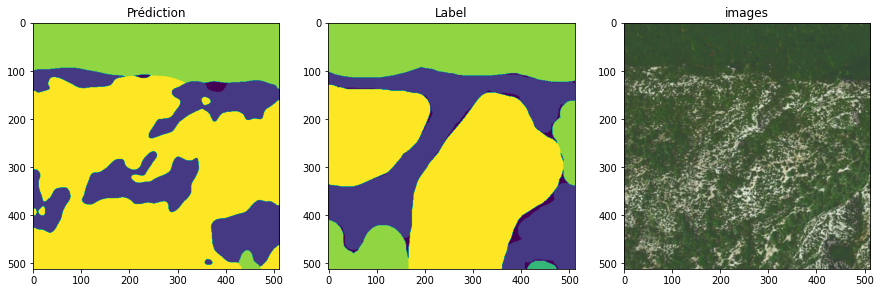

In [26]:
i = random.choice(valid_index)
print(i)
img = mmcv.imread('data/Real/images/img_{}.png'.format(i))
annotation = mmcv.imread('data/Real/annotations/img_{}.png'.format(i))

model.cfg = cfg
result = inference_segmentor(model, img)
result = np.array(result)

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(result[0,...])
plt.gca().set_title("Prédiction")

plt.subplot(132)
plt.imshow(annotation[...,0])
plt.gca().set_title("Label")

plt.subplot(133)
plt.imshow(img[:,:,::-1])
plt.gca().set_title("images")
plt.show()

In [12]:
valid_imgs=[]
valid_labels=[]

for i in valid_index:
    img = mmcv.imread('data/Real/images/img_{}.png'.format(i))
    label = mmcv.imread('data/Real/annotations/img_{}.png'.format(i))
    valid_imgs.append(img)
    valid_labels.append(label)
    
valid_imgs = np.array(valid_imgs)
valid_labels = np.array(valid_labels)
valid_imgs.shape,valid_labels.shape

((73, 512, 512, 3), (73, 512, 512, 3))

In [13]:
predictions = []

for img in valid_imgs:
    result = inference_segmentor(model, img)
    predictions.append(result)

predictions = np.array(predictions)
predictions = np.squeeze(predictions)

In [14]:
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

In [15]:
predictions = to_categorical(predictions,12)
valid_labels = to_categorical(valid_labels[...,0],12)

In [16]:
true_label = np.argmax(valid_labels,axis=3)
label_pred = np.argmax(predictions,axis=3)

In [17]:
predictions = np.zeros(predictions.shape)

for idx_class in range(12):
    predictions[...,idx_class][label_pred == idx_class] = 1

IOU moyen et par classe

In [18]:
iou = []
for idx_classe in range(12):
    prediction = predictions[...,idx_classe]
    target = valid_labels[...,idx_classe]

    intersection = np.logical_and(target,prediction)
    union = np.logical_or(target,prediction)
    iou_score = np.sum(intersection) / np.sum(union)

    iou.append(iou_score)
print(iou)
    
print("mIou: ", np.mean(iou))

[0.3027858598666884, 0.6833874419824998, 0.8089931701442487, 0.6893030613383088, 0.5506744980479643, 0.7359776185623849, 0.442474788462083, 0.6544061015011553, 0.5486126997762054, 0.4735775548069531, 0.6536349244765732, 0.6180268595041323]
mIou:  0.5968212148724331


matrice de confusion par classe

In [19]:
conf_mat = np.zeros((12,12))

for idx_pred_class in range(12):
    for idx_target_class in range(12):
        target = valid_labels[...,idx_target_class]

        intersection = np.logical_and(target,predictions[...,idx_pred_class])
        conf_mat[idx_pred_class,idx_target_class] = np.sum(intersection)

In [20]:
classes = list(CLASSES)

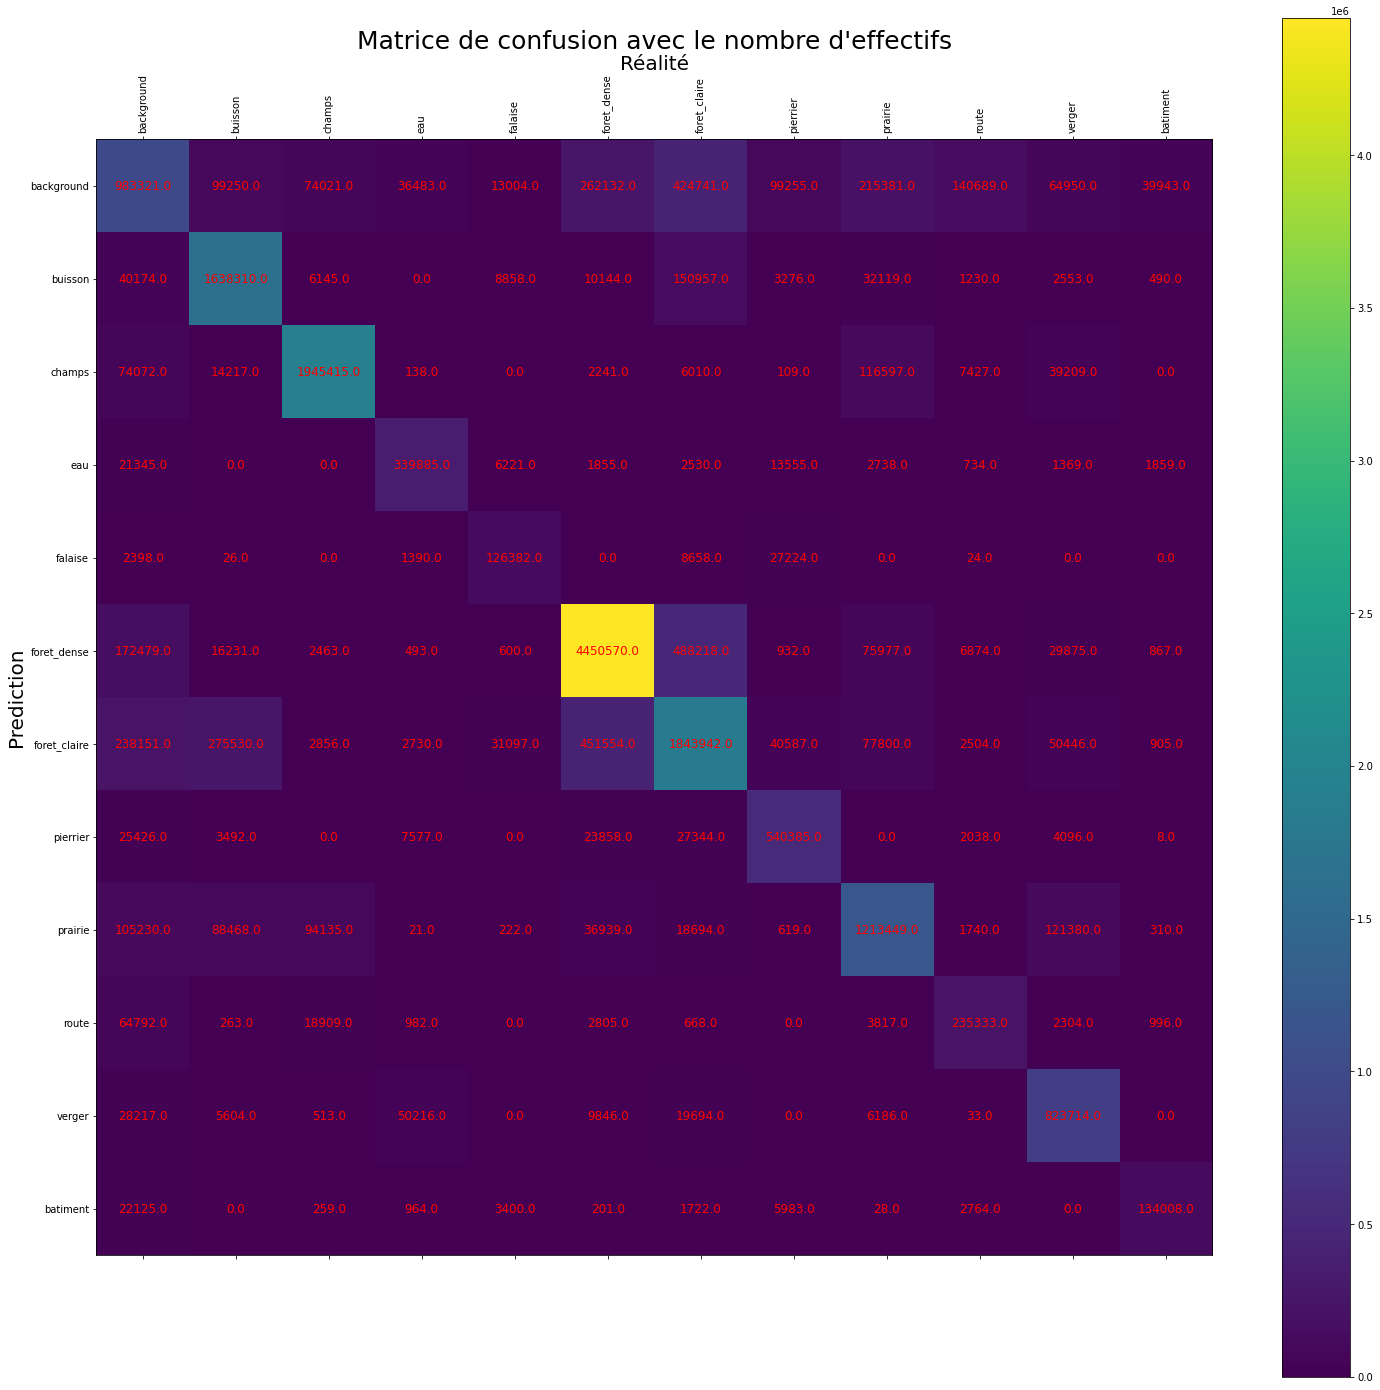

In [21]:
data = conf_mat

fig = plt.figure(figsize=(25,25))
ax = fig.add_subplot(111)
cax = ax.matshow(data, interpolation='nearest')
fig.colorbar(cax)

for i in range(len(data)):
    for j in range(len(data)):
        c = data[j,i]
        ax.text(i, j, str(round(c,2)), va='center', ha='center',
                color="red",size = "large")
        
plt.xticks(range(12), classes, rotation='vertical')
plt.yticks(range(12), classes, rotation='horizontal')
plt.xlabel('Réalité', fontsize=20)
plt.gca().xaxis.set_label_position('top') 
plt.ylabel('Prediction', fontsize=20)
plt.gca().set_title("Matrice de confusion avec le nombre d'effectifs", fontsize=25)
plt.show()
plt.show()


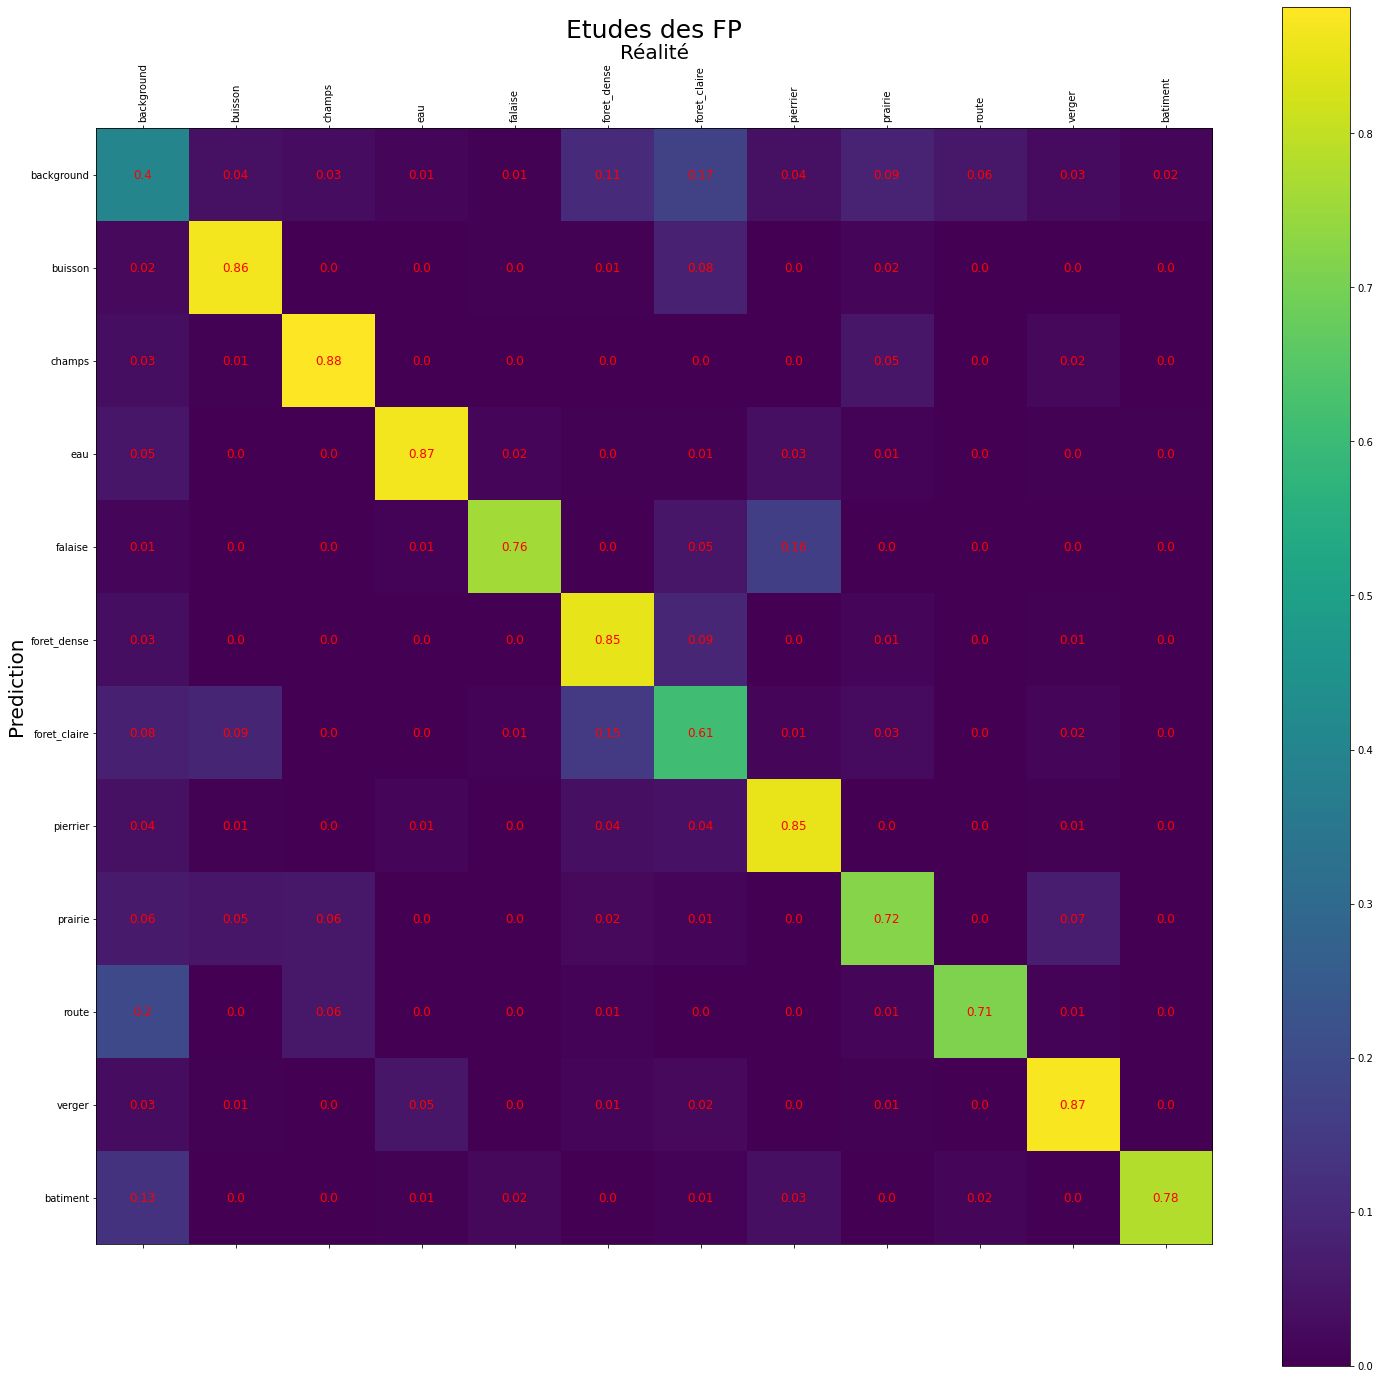

In [22]:
conf_mat_norm = conf_mat.T/conf_mat.sum(axis=1)

conf_mat_norm = conf_mat_norm.T

data = conf_mat_norm

fig = plt.figure(figsize=(25,25))
ax = fig.add_subplot(111)
cax = ax.matshow(data, interpolation='nearest')
fig.colorbar(cax)

for i in range(len(data)):
    for j in range(len(data)):
        c = data[j,i]
        ax.text(i, j, str(round(c,2)), va='center', ha='center',
                color="red",size = "large")
        
plt.xticks(range(12), classes, rotation='vertical')
plt.yticks(range(12), classes, rotation='horizontal')
plt.xlabel('Réalité', fontsize=20)
plt.gca().xaxis.set_label_position('top') 
plt.ylabel('Prediction', fontsize=20)
plt.gca().set_title("Etudes des FP", fontsize=25)
plt.show()
plt.show()

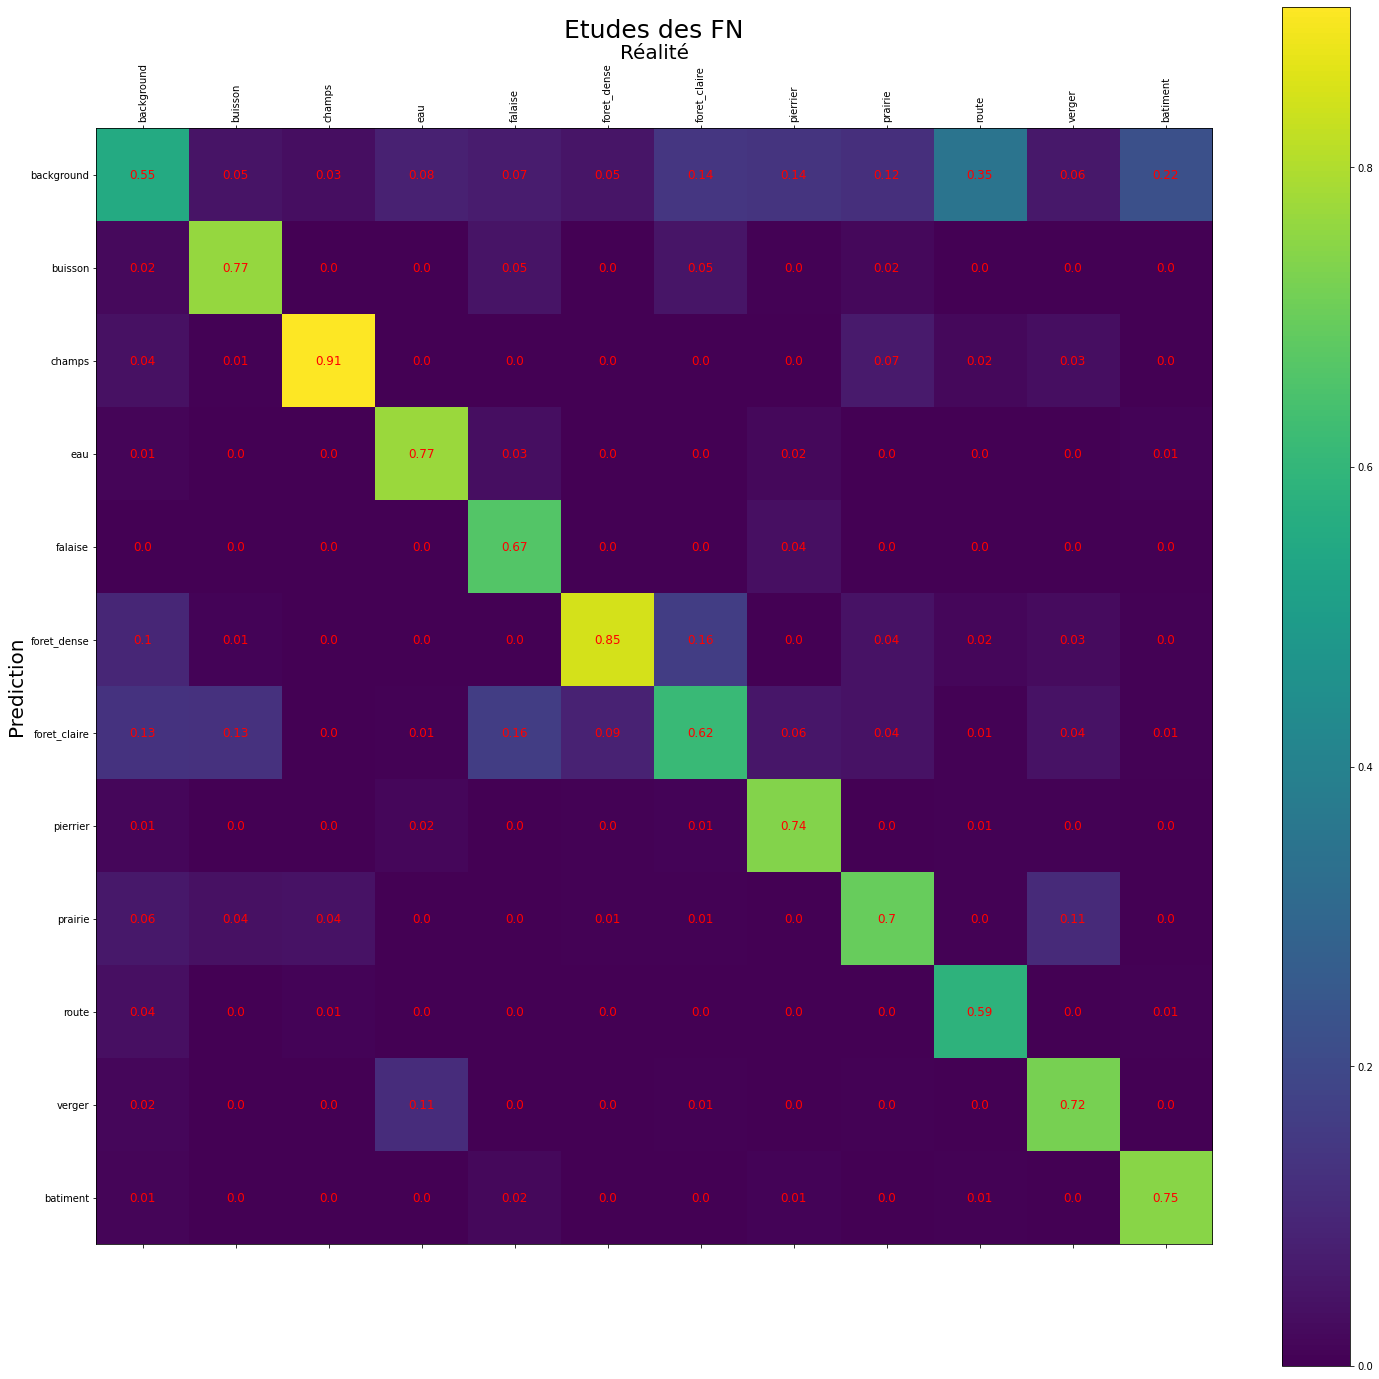

In [23]:
conf_mat_norm_bis = conf_mat / conf_mat.sum(axis=0)

data = conf_mat_norm_bis

fig = plt.figure(figsize=(25,25))
ax = fig.add_subplot(111)
cax = ax.matshow(data, interpolation='nearest')
fig.colorbar(cax)

for i in range(len(data)):
    for j in range(len(data)):
        c = data[j,i]
        ax.text(i, j, str(round(c,2)), va='center', ha='center',
                color="red",size = "large")
        
plt.xticks(range(12), classes, rotation='vertical')
plt.yticks(range(12), classes, rotation='horizontal')
plt.xlabel('Réalité', fontsize=20)
plt.gca().xaxis.set_label_position('top') 
plt.ylabel('Prediction', fontsize=20)
plt.gca().set_title("Etudes des FN", fontsize=25)
plt.show()
plt.show()


In [24]:
dico = {}
for idx,classe in zip(range(12),classes):
    precision = conf_mat[idx,idx]/np.sum(conf_mat[idx,:])
    recall = conf_mat[idx,idx]/np.sum(conf_mat[:,idx])
    f1score = 2 * precision * recall /(precision + recall)
    dico[classe] = {"precision":precision,"recall":recall,"f1":f1score}
    
dico

{'background': {'precision': 0.40083687636812776,
  'recall': 0.5531329279474386,
  'f1': 0.46482828712567065},
 'buisson': {'precision': 0.8648830992220693,
  'recall': 0.7650681262786665,
  'f1': 0.8119193774876742},
 'champs': {'precision': 0.882100356618989,
  'recall': 0.9070734773275343,
  'f1': 0.8944126307339676},
 'eau': {'precision': 0.8668523378501419,
  'recall': 0.77092580957587,
  'f1': 0.8160798107975077},
 'falaise': {'precision': 0.7608698269737872,
  'recall': 0.6659254731694979,
  'f1': 0.7102386719342711},
 'foret_dense': {'precision': 0.848442088089799,
  'recall': 0.8473814032171617,
  'f1': 0.8479114139407742},
 'foret_claire': {'precision': 0.6109607958909274,
  'recall': 0.6160482270015348,
  'f1': 0.6134939646797353},
 'pierrier': {'precision': 0.8520412346426499,
  'recall': 0.7383065204768248,
  'f1': 0.7911069729582937},
 'prairie': {'precision': 0.7217725122486404,
  'recall': 0.6957482747469743,
  'f1': 0.7085215042540811},
 'route': {'precision': 0.71125

In [25]:
sommef1,sommerecall,sommeprecision = 0,0,0
for key in dico:
    sommef1 += dico[key]["f1"]
    sommerecall += dico[key]["recall"]
    sommeprecision += dico[key]["precision"]
    
print("mean f1 score is:" ,sommef1/len(dico))
print("mean precision score is:" ,sommeprecision/len(dico))
print("mean recall score is:" ,sommerecall/len(dico))

mean f1 score is: 0.7379784439300866
mean precision score is: 0.7645142483493093
mean recall score is: 0.7179637119537707


###  test sur jeu de synthese

#split train/val set randomly
data_root = "data/synthese2/"
split_dir = 'splits_synthese/'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  #select first 4/5 as train set
  train_length = int(len(filename_list)*4/5)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  #select last 1/5 as train set
  f.writelines(line + '\n' for line in filename_list[train_length:])

In [ ]:
import re
valid_index = []
with open(osp.join(data_root, split_dir) + "val.txt", 'r') as f:
    for line in f:
        num = re.findall(r'\d+',str(line)).pop()
        valid_index.append(num)

In [ ]:
valid_imgs=[]
valid_labels=[]

for i in valid_index:
    img = mmcv.imread('data/synthese2/images/{}.png'.format(i))
    label = mmcv.imread('data/synthese2/annotations/{}.png'.format(i))
    valid_imgs.append(img)
    valid_labels.append(label)
    
valid_imgs = np.array(valid_imgs)
valid_labels = np.array(valid_labels)

In [ ]:
i = random.choice(valid_index)
print(i)
img = mmcv.imread('data/synthese2/images/{}.png'.format(i))
annotation = mmcv.imread('data/synthese2/annotations/{}.png'.format(i))

model.cfg = cfg
result = inference_segmentor(model, img)
result = np.array(result)

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(result[0,...])
plt.gca().set_title("Prédiction")

plt.subplot(132)
plt.imshow(annotation[...,0])
plt.gca().set_title("Label")

plt.subplot(133)
plt.imshow(img[:,:,::-1])
plt.gca().set_title("images")
plt.show()

In [ ]:
predictions = []

for img in valid_imgs:
    result = inference_segmentor(model, img)
    predictions.append(result)

predictions = np.array(predictions)
predictions = np.squeeze(predictions)

In [ ]:
predictions = to_categorical(predictions,12)
valid_labels = to_categorical(valid_labels[...,0],12)

true_label = np.argmax(valid_labels,axis=3)
label_pred = np.argmax(predictions,axis=3)

predictions = np.zeros(predictions.shape)

for idx_class in range(11):
    predictions[...,idx_class][label_pred == idx_class] = 1


In [ ]:
predictions.shape,valid_imgs.shape,valid_labels.shape

In [ ]:
classes_real = {0:"background",1:"buisson",2:"champs",3:"eau",
         4:"falaise",5:"foret_dense",6:"foret_claire",
         7:"pierrier",8:"prairie",9:"route",10:"verger",
         11:"batiment"}

classes_syn = {0: "falaise" , 1: "batiment", 2:"route",3:"pierrier",4:"verger",
            5:"champ",6:"prairie",7:"foret",8:"foret_claire",9:"buisson",10:"eau"}


correspondance = {0:4,1:11,2:9,3:7,4:10,5:2,6:8,7:5,8:6,9:1,10:3,11:0}

In [ ]:
a = list(classes_syn.values())
a.append("background")

In [ ]:
iou = {}
for idx_classe in range(11):
    # doesn't take into account background class since it is not present
    # in the synthese dataset
    target = valid_labels[...,idx_classe]

    intersection = np.logical_and(target,predictions[...,correspondance[idx_classe]])
    union = np.logical_or(target,predictions[...,correspondance[idx_classe]])
    iou_score = np.sum(intersection) / np.sum(union)
    iou[a[idx_classe]] = iou_score

print(iou)  
print("mIou: ", np.mean(list(iou.values())))